# EDA

## 1. Setup & Data Loading

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import math
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score
import xgboost as xgb
import lightgbm as lgb
import gc

In [2]:
data_folder = 'ieee-fraud-detection-data/'

train_identity = pd.read_csv(f'{data_folder}train_identity.csv')
train_transaction = pd.read_csv(f'{data_folder}train_transaction.csv')
test_identity = pd.read_csv(f'{data_folder}test_identity.csv')
test_transaction = pd.read_csv(f'{data_folder}test_transaction.csv')

In [3]:
# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


In [4]:
# replace - to _ in column names to keep consistent naming
train.columns = [col.replace('-', '_') for col in train.columns]
test.columns = [col.replace('-', '_') for col in test.columns]

## 2. Target Variable Analysis


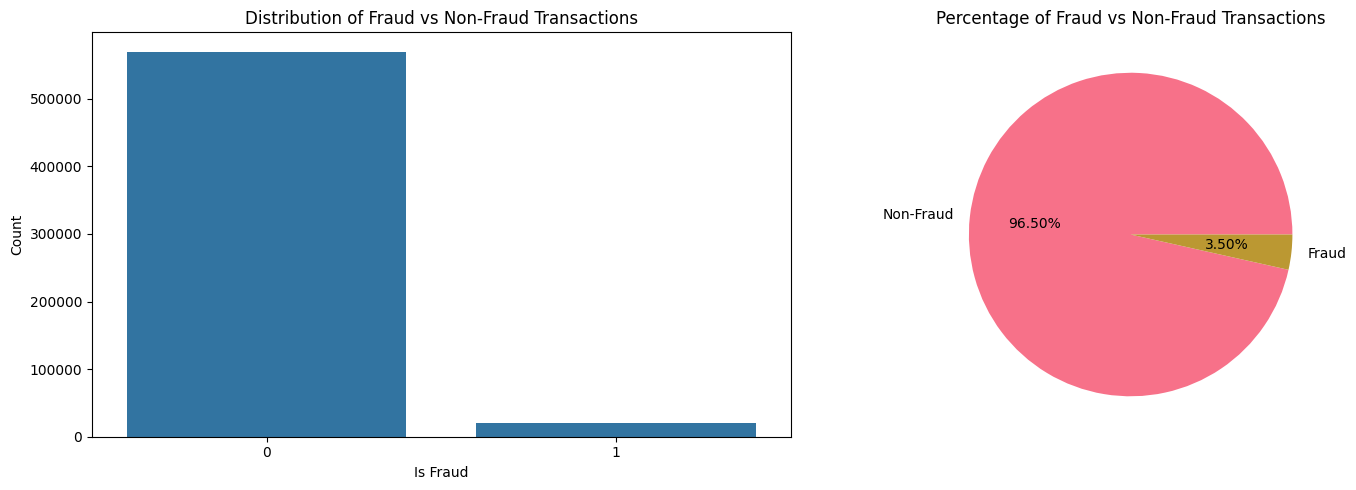


Detailed Statistics:
Total Transactions: 590,540
Fraud Transactions: 20,663
Non-Fraud Transactions: 569,877

Fraud Rate: 3.50%


In [95]:
# Calculate fraud distribution
fraud_dist = train['isFraud'].value_counts()
fraud_pct = train['isFraud'].value_counts(normalize=True) * 100

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Bar chart
sns.barplot(x=fraud_dist.index, y=fraud_dist.values, ax=ax1)
ax1.set_title('Distribution of Fraud vs Non-Fraud Transactions')
ax1.set_xlabel('Is Fraud')
ax1.set_ylabel('Count')

# Plot 2: Pie chart
colors = sns.color_palette('husl')[:2]
ax2.pie(fraud_pct, labels=['Non-Fraud', 'Fraud'], autopct='%1.2f%%', colors=colors)
ax2.set_title('Percentage of Fraud vs Non-Fraud Transactions')

plt.tight_layout()
plt.show()

print("\nDetailed Statistics:")
print(f"Total Transactions: {len(train):,}")
print(f"Fraud Transactions: {fraud_dist[1]:,}")
print(f"Non-Fraud Transactions: {fraud_dist[0]:,}")
print(f"\nFraud Rate: {fraud_pct[1]:.2f}%")

## 3. Missing Values

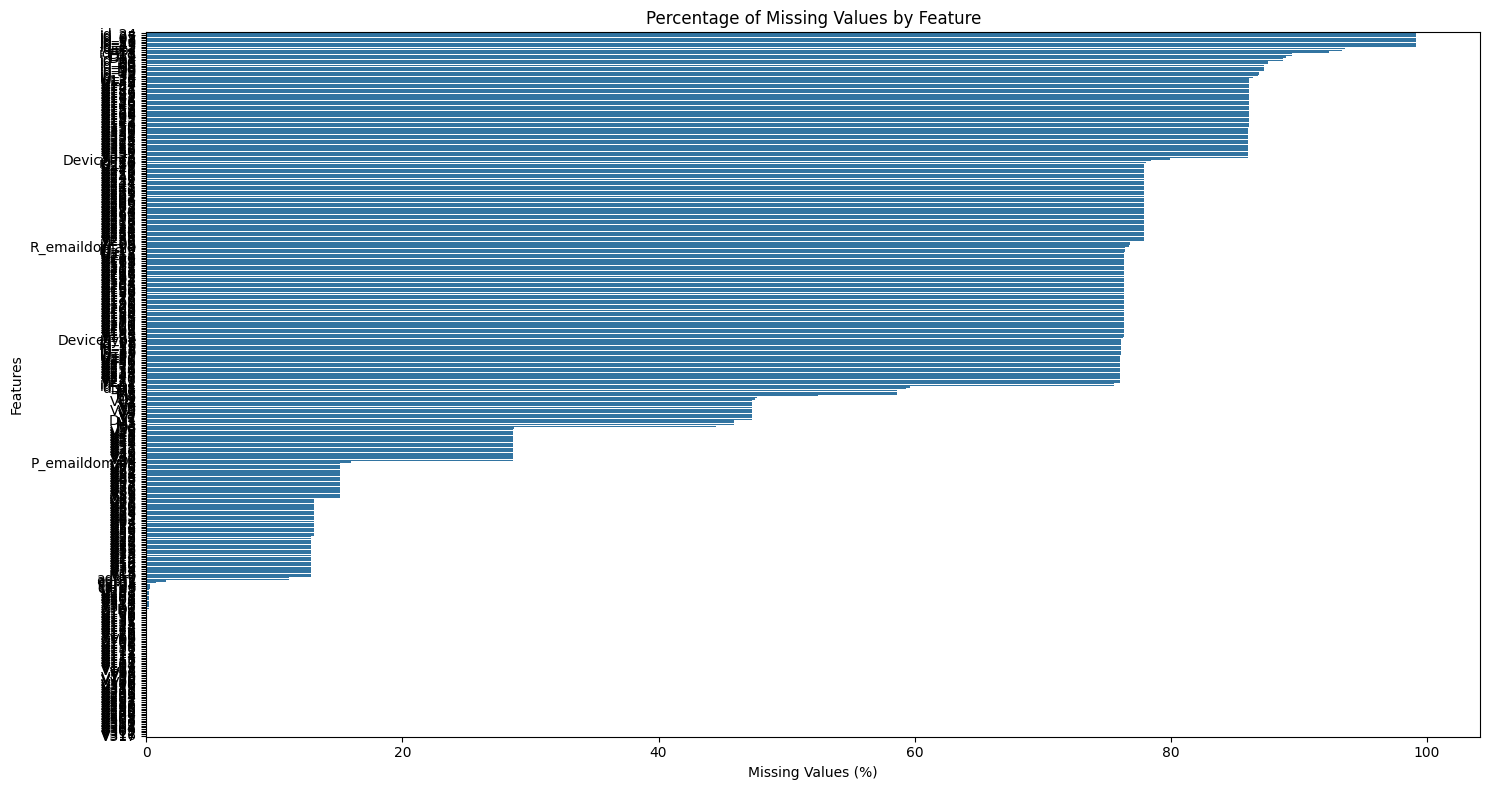


Features with more than 50% missing values:
id_24            99.196159
id_25            99.130965
id_07            99.127070
id_08            99.127070
id_21            99.126393
id_26            99.125715
id_27            99.124699
id_23            99.124699
id_22            99.124699
dist2            93.628374
D7               93.409930
id_18            92.360721
D13              89.509263
D14              89.469469
D12              89.041047
id_04            88.768923
id_03            88.768923
D6               87.606767
id_33            87.589494
id_09            87.312290
D8               87.312290
id_10            87.312290
D9               87.312290
id_30            86.865411
id_32            86.861855
id_34            86.824771
id_14            86.445626
V138             86.123717
V139             86.123717
V148             86.123717
V154             86.123717
V162             86.123717
V141             86.123717
V157             86.123717
V146             86.123717
V163      

In [5]:
# Calculate missing values percentage for each column
missing_values = (train.isnull().sum() / len(train) * 100).sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]  # Only keep columns with missing values

# Create a figure for missing values visualization
plt.figure(figsize=(15, 8))
sns.barplot(x=missing_values.values, y=missing_values.index)
plt.title('Percentage of Missing Values by Feature')
plt.xlabel('Missing Values (%)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Display features with high missingness (>50%)
print("\nFeatures with more than 50% missing values:")
print(missing_values[missing_values > 50].to_string())

# Display features with moderate missingness (20-50%)
print("\nFeatures with 20-50% missing values:")
print(missing_values[(missing_values > 20) & (missing_values <= 50)].to_string())

We see a lot of features with high percentage of missing values. That beeing said, we dont drop those features, because missingness of a feature might be an important indicator of fraud.

## 4. TransactionDT (Time)

In [5]:
# Convert TransactionDT to days
train['TransactionDay'] = train['TransactionDT'] / (24*60*60)
test['TransactionDay'] = test['TransactionDT'] / (24*60*60)

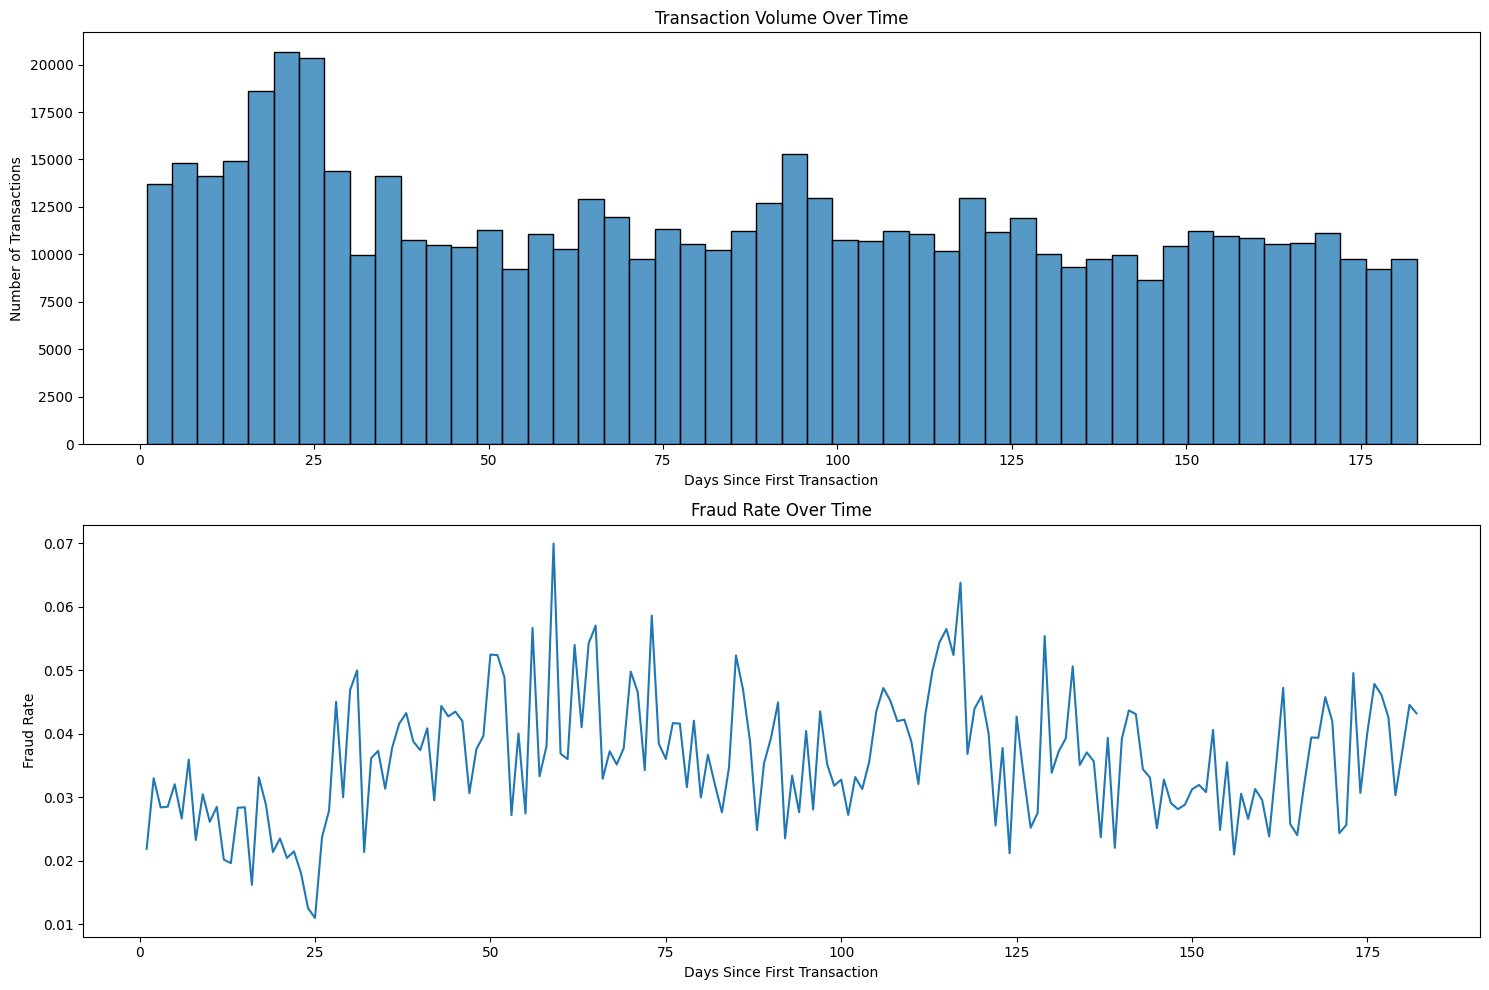


Time-based Statistics:
Total time span: 182.0 days
Average daily transactions: 3244.7

Fraud Rate Statistics:
Minimum daily fraud rate: 1.097%
Maximum daily fraud rate: 6.994%
Average daily fraud rate: 3.605%


In [ ]:
# Create time-based visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Transaction volume over time
plt.subplot(2, 1, 1)
sns.histplot(data=train, x='TransactionDay', bins=50)
plt.title('Transaction Volume Over Time')
plt.xlabel('Days Since First Transaction')
plt.ylabel('Number of Transactions')

# Plot 2: Fraud rate over time
plt.subplot(2, 1, 2)
fraud_rate = train.groupby(train['TransactionDay'].astype(int))['isFraud'].mean()
plt.plot(fraud_rate.index, fraud_rate.values)
plt.title('Fraud Rate Over Time')
plt.xlabel('Days Since First Transaction')
plt.ylabel('Fraud Rate')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nTime-based Statistics:")
print(f"Total time span: {train['TransactionDay'].max()-train['TransactionDay'].min():.1f} days")
print(f"Average daily transactions: {len(train)/len(fraud_rate):.1f}")
print("\nFraud Rate Statistics:")
print(f"Minimum daily fraud rate: {fraud_rate.min():.3%}")
print(f"Maximum daily fraud rate: {fraud_rate.max():.3%}")
print(f"Average daily fraud rate: {fraud_rate.mean():.3%}")

In [6]:
# create 'day of week' categorical feature
train['day_of_week'] = train['TransactionDT']//3600//24 % 7
test['day_of_week'] = train['TransactionDT']//3600//24 % 7

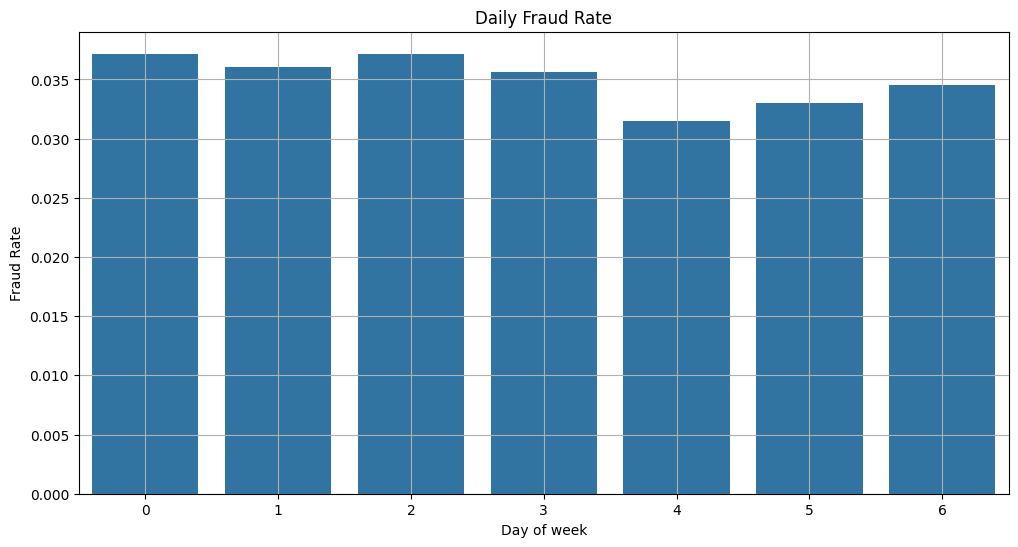


Daily Fraud Rate Statistics:
Minimum daily fraud rate: 3.145%
Maximum daily fraud rate: 3.717%
Average daily fraud rate: 3.500%


In [ ]:
# plot daily fraud
daily_fraud = train.groupby('day_of_week')['isFraud'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=daily_fraud.index, y=daily_fraud.values)
plt.title('Daily Fraud Rate')
plt.xlabel('Day of week')
plt.ylabel('Fraud Rate')
plt.xticks(range(0, 7))
plt.grid()
plt.show()

print("\nDaily Fraud Rate Statistics:")
print(f"Minimum daily fraud rate: {daily_fraud.min():.3%}")
print(f"Maximum daily fraud rate: {daily_fraud.max():.3%}")
print(f"Average daily fraud rate: {daily_fraud.mean():.3%}")

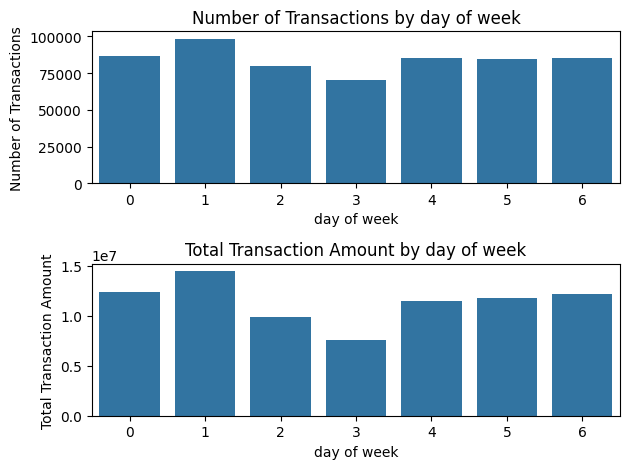


dayly Transaction Statistics:
day with minimum transactions: 3 (70223 transactions)
day with maximum transactions: 1 (98502 transactions)
day with minimum transaction amount: 3 ($7,554,714.29)
day with maximum transaction amount: 1 ($14,470,095.08)


In [98]:
#plot amount of transactions (number of transactions and total amount) based on day
plt.subplot(2,1,1)
dayly_transactions = train.groupby('day_of_week').size()
sns.barplot(x=dayly_transactions.index, y=dayly_transactions.values)
plt.title('Number of Transactions by day of week')
plt.xlabel('day of week')
plt.ylabel('Number of Transactions')

plt.subplot(2,1,2)
dayly_amount = train.groupby('day_of_week')['TransactionAmt'].sum()
sns.barplot(x=dayly_amount.index, y=dayly_amount.values)
plt.title('Total Transaction Amount by day of week')
plt.xlabel('day of week')
plt.ylabel('Total Transaction Amount')

plt.tight_layout()
plt.show()

print("\ndayly Transaction Statistics:")
print(f"day with minimum transactions: {dayly_transactions.idxmin()} ({dayly_transactions.min()} transactions)")
print(f"day with maximum transactions: {dayly_transactions.idxmax()} ({dayly_transactions.max()} transactions)")
print(f"day with minimum transaction amount: {dayly_amount.idxmin()} (${dayly_amount.min():,.2f})")
print(f"day with maximum transaction amount: {dayly_amount.idxmax()} (${dayly_amount.max():,.2f})")


In [7]:
# create 'hour of day' categorical feature
train['hour_of_day'] = train['TransactionDT']//3600 % 24
test['hour_of_day'] = test['TransactionDT']//3600 % 24

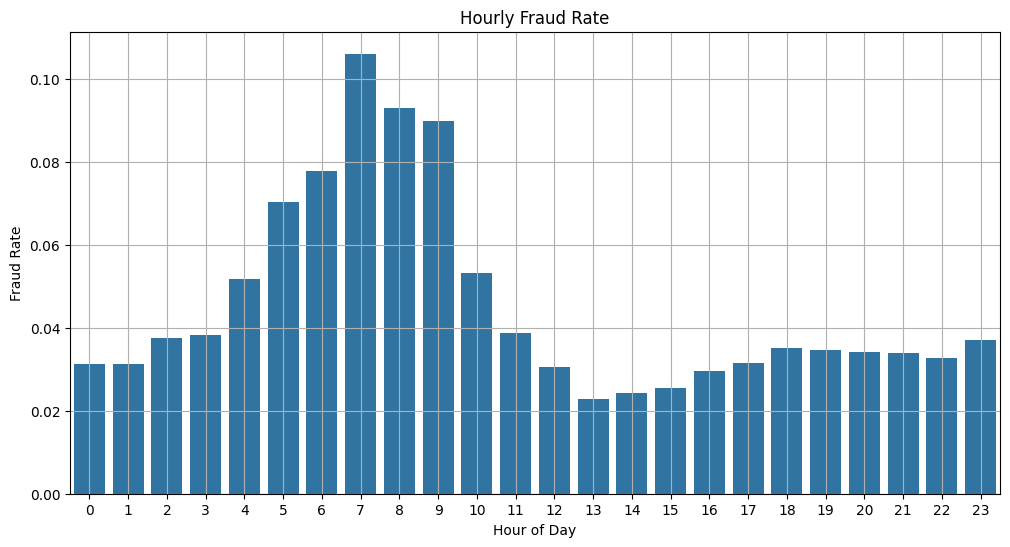


Hourly Fraud Rate Statistics:
Minimum hourly fraud rate: 2.289%
Maximum hourly fraud rate: 10.610%
Average hourly fraud rate: 4.548%


In [6]:
# plot hourly fraud
hourly_fraud = train.groupby('hour_of_day')['isFraud'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_fraud.index, y=hourly_fraud.values)
plt.title('Hourly Fraud Rate')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.xticks(range(0, 24))
plt.grid()
plt.show()

print("\nHourly Fraud Rate Statistics:")
print(f"Minimum hourly fraud rate: {hourly_fraud.min():.3%}")
print(f"Maximum hourly fraud rate: {hourly_fraud.max():.3%}")
print(f"Average hourly fraud rate: {hourly_fraud.mean():.3%}")

There is a possible relationship shown between hour of transaction and fraud rate.

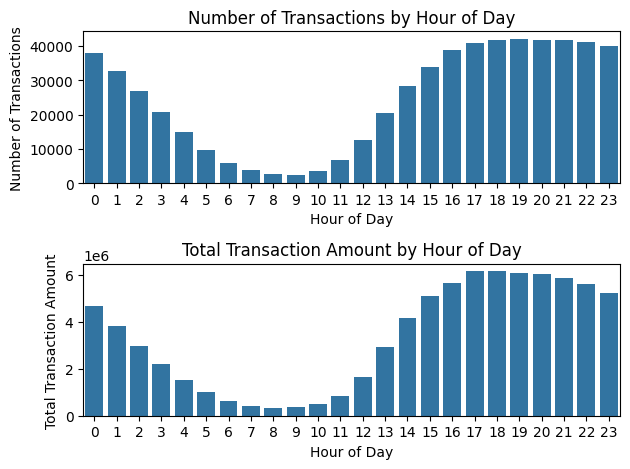


Hourly Transaction Statistics:
Hour with minimum transactions: 9 (2479 transactions)
Hour with maximum transactions: 19 (42115 transactions)
Hour with minimum transaction amount: 8 ($325,013.26)
Hour with maximum transaction amount: 17 ($6,150,905.44)


In [100]:
#plot amount of transactions (number of transactions and total amount) based on hour
plt.subplot(2,1,1)
hourly_transactions = train.groupby('hour_of_day').size()
sns.barplot(x=hourly_transactions.index, y=hourly_transactions.values)
plt.title('Number of Transactions by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')

plt.subplot(2,1,2)
hourly_amount = train.groupby('hour_of_day')['TransactionAmt'].sum()
sns.barplot(x=hourly_amount.index, y=hourly_amount.values)
plt.title('Total Transaction Amount by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Transaction Amount')

plt.tight_layout()
plt.show()

print("\nHourly Transaction Statistics:")
print(f"Hour with minimum transactions: {hourly_transactions.idxmin()} ({hourly_transactions.min()} transactions)")
print(f"Hour with maximum transactions: {hourly_transactions.idxmax()} ({hourly_transactions.max()} transactions)")
print(f"Hour with minimum transaction amount: {hourly_amount.idxmin()} (${hourly_amount.min():,.2f})")
print(f"Hour with maximum transaction amount: {hourly_amount.idxmax()} (${hourly_amount.max():,.2f})")


## 5. TransactionAMT


In [8]:
# create decimal places columns (since decimal places might indicate currency conversion)
train['DecimalPlaces'] = train['TransactionAmt'].apply(lambda x: len(str(x).split('.')[-1]) if '.' in str(x) else 0)
test['DecimalPlaces'] = test['TransactionAmt'].apply(lambda x: len(str(x).split('.')[-1]) if '.' in str(x) else 0)

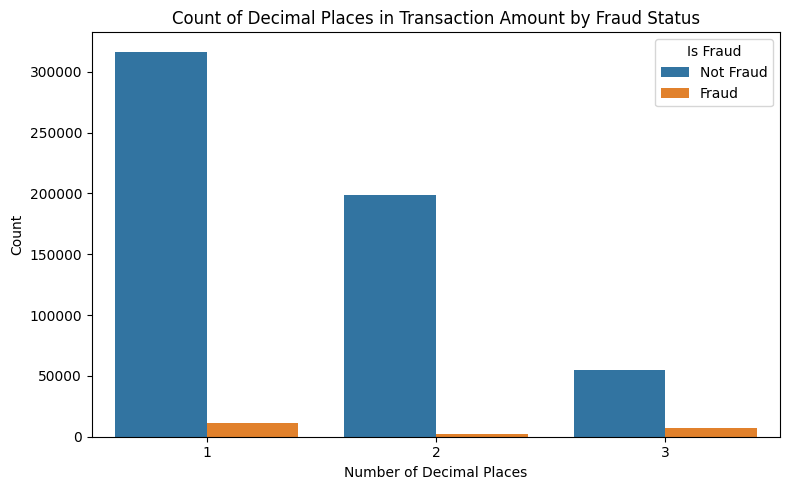


Decimal Places Value Counts by Fraud Status:
DecimalPlaces       1       2      3
isFraud                             
0              316638  198565  54674
1               11312    2092   7259


In [24]:
# plot count of decimal places by fraud
plt.figure(figsize=(8, 5))
sns.countplot(data=train, x='DecimalPlaces', hue='isFraud')
plt.title('Count of Decimal Places in Transaction Amount by Fraud Status')
plt.xlabel('Number of Decimal Places')
plt.ylabel('Count')
plt.legend(title='Is Fraud', labels=['Not Fraud', 'Fraud'])
plt.tight_layout()
plt.show()

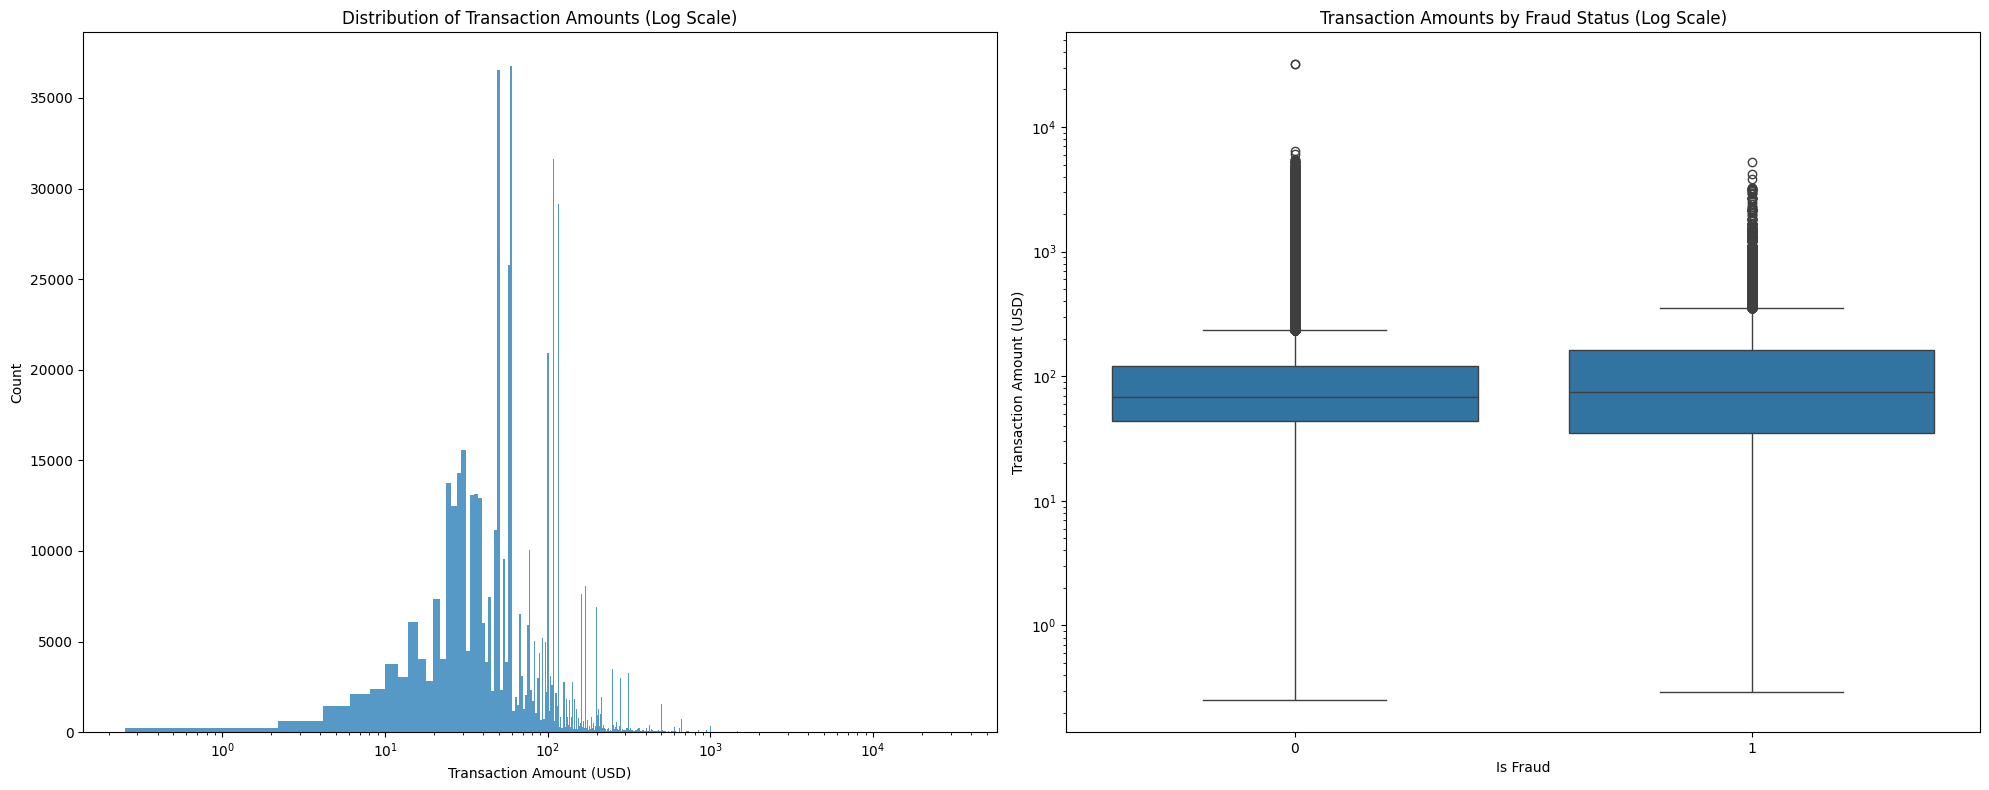

In [36]:
# Create visualizations for TransactionAMT
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Distribution of transaction amounts (log scale)
sns.histplot(data=train, x='TransactionAmt', ax=ax1)
ax1.set_xscale('log')
ax1.set_title('Distribution of Transaction Amounts (Log Scale)')
ax1.set_xlabel('Transaction Amount (USD)')
ax1.set_ylabel('Count')

# Plot 2: Box plot of amounts by fraud status (log scale)
sns.boxplot(data=train, x='isFraud', y='TransactionAmt', ax=ax2)
ax2.set_yscale('log')
ax2.set_title('Transaction Amounts by Fraud Status (Log Scale)')
ax2.set_xlabel('Is Fraud')
ax2.set_ylabel('Transaction Amount (USD)')

plt.tight_layout()
plt.show()

In [31]:
# Print statistics about transaction amounts
print("\nTransaction Amount Statistics:")
print(f"Minimum amount: ${train['TransactionAmt'].min():.2f}")
print(f"Maximum amount: ${train['TransactionAmt'].max():.2f}")
print(f"Mean amount: ${train['TransactionAmt'].mean():.2f}")
print(f"Median amount: ${train['TransactionAmt'].median():.2f}")
# Print quartile values for Transaction Amount
quartiles = train['TransactionAmt'].quantile([0.25, 0.5, 0.75])
print(f"Q1: ${quartiles[0.25]:.2f}")
print(f"Q2: ${quartiles[0.5]:.2f}")
print(f"Q3: ${quartiles[0.75]:.2f}")
# Calculate fraud rate by transaction amount quartiles
amount_quartiles = pd.qcut(train['TransactionAmt'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
fraud_by_amount = train.groupby(amount_quartiles, observed=True)['isFraud'].mean()

print("\nFraud Rate by Transaction Amount Quartile:")
print(fraud_by_amount.to_string())


Transaction Amount Statistics:
Minimum amount: $0.25
Maximum amount: $31937.39
Mean amount: $135.03
Median amount: $68.77
Q1: $43.32
Q2: $68.77
Q3: $125.00

Fraud Rate by Transaction Amount Quartile:
TransactionAmt
Q1    0.042428
Q2    0.025090
Q3    0.028252
Q4    0.044388



## 6. Categorical Features
- **ProductCD, card1–card6, addr1/addr2, email domains, M1–M9**


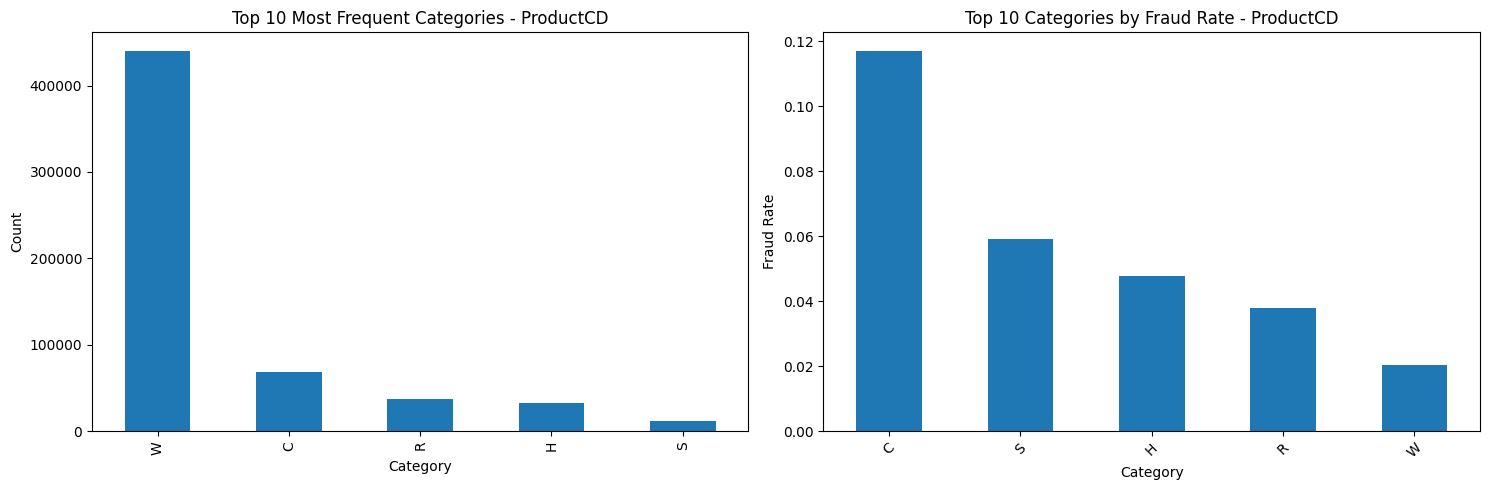


Analysis for ProductCD:
Number of unique values: 5
Missing values: 0 (0.00%)

Top 5 categories by frequency:
ProductCD
W    439670
C     68519
R     37699
H     33024
S     11628


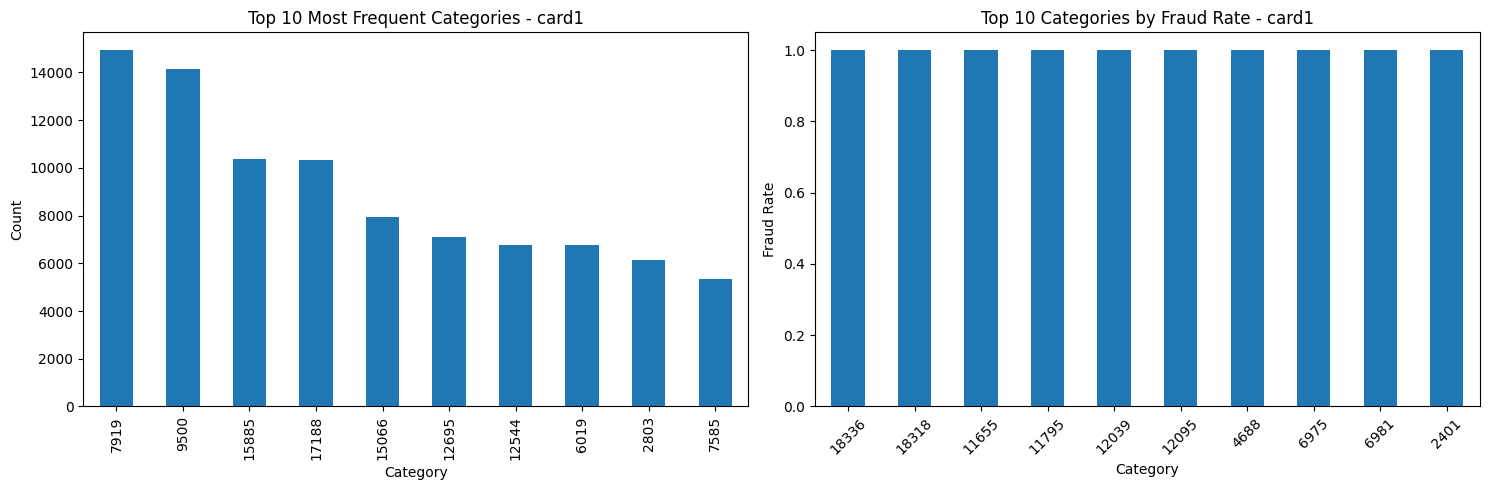


Analysis for card1:
Number of unique values: 13553
Missing values: 0 (0.00%)

Top 5 categories by frequency:
card1
7919     14932
9500     14162
15885    10361
17188    10344
15066     7945


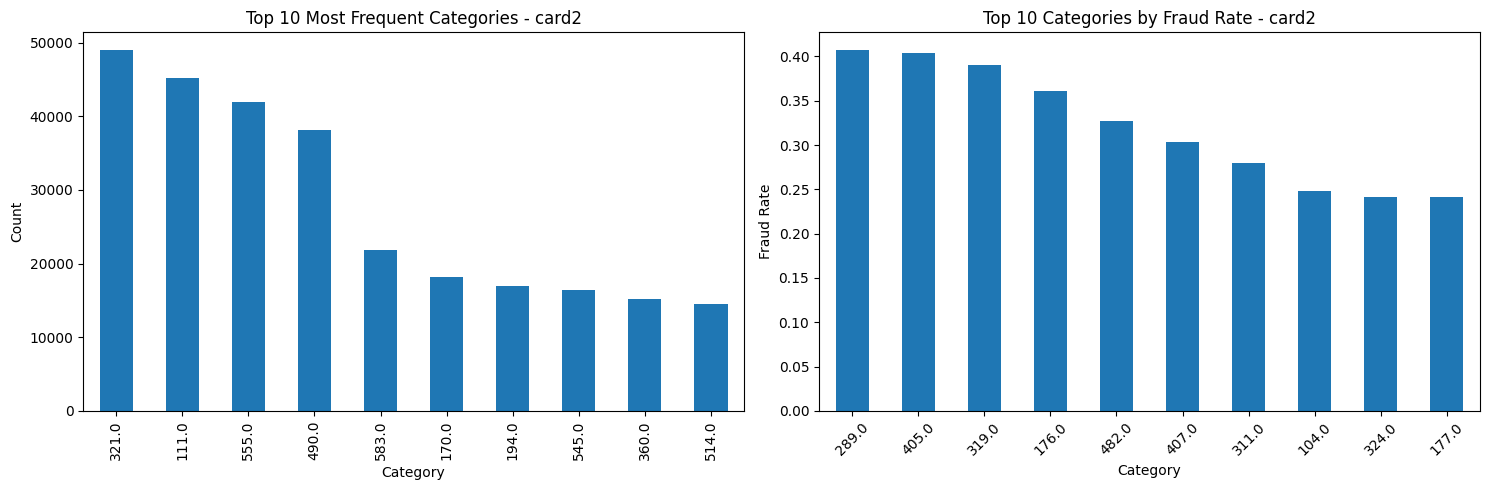


Analysis for card2:
Number of unique values: 500
Missing values: 8933 (1.51%)

Top 5 categories by frequency:
card2
321.0    48935
111.0    45191
555.0    41995
490.0    38145
583.0    21803


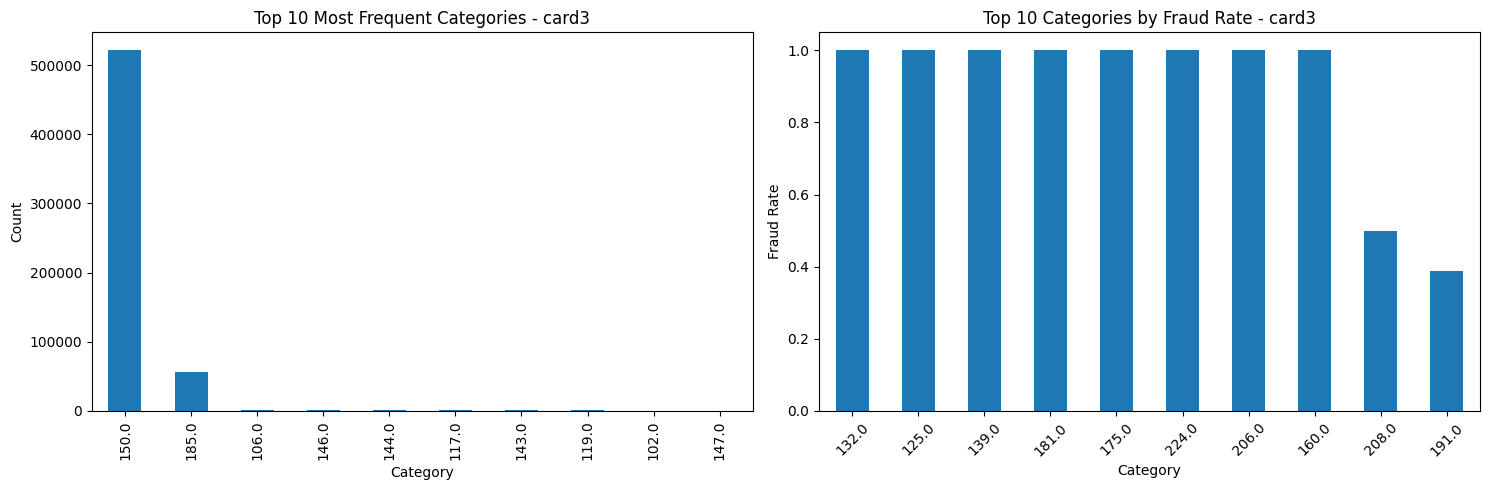


Analysis for card3:
Number of unique values: 114
Missing values: 1565 (0.27%)

Top 5 categories by frequency:
card3
150.0    521287
185.0     56346
106.0      1571
146.0      1252
144.0      1252


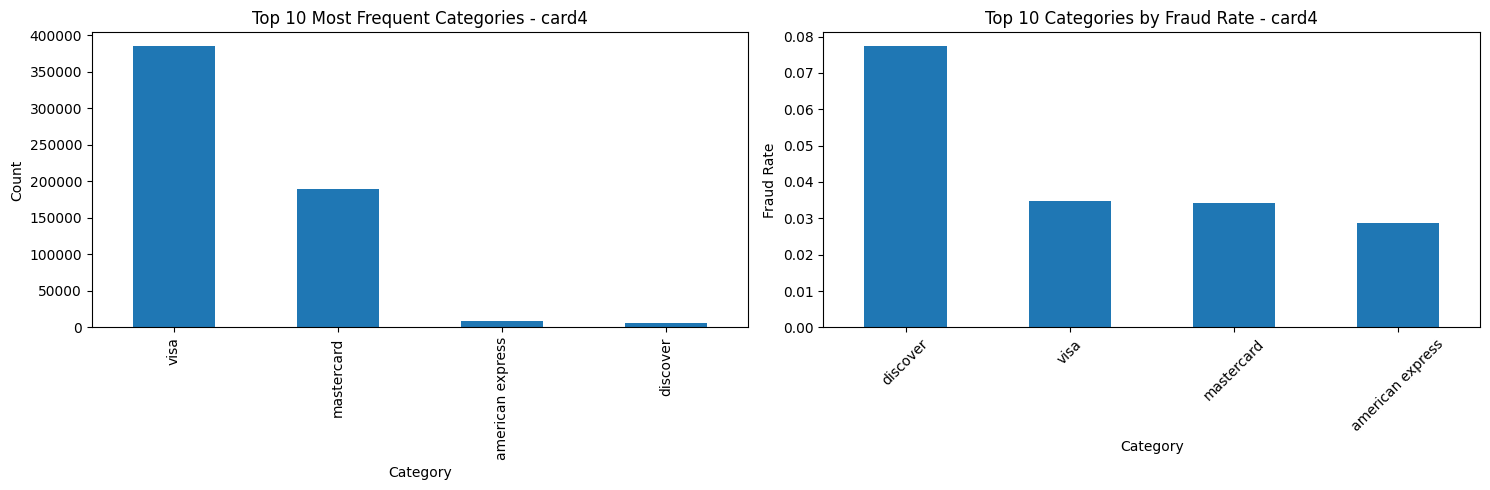


Analysis for card4:
Number of unique values: 4
Missing values: 1577 (0.27%)

Top 5 categories by frequency:
card4
visa                384767
mastercard          189217
american express      8328
discover              6651


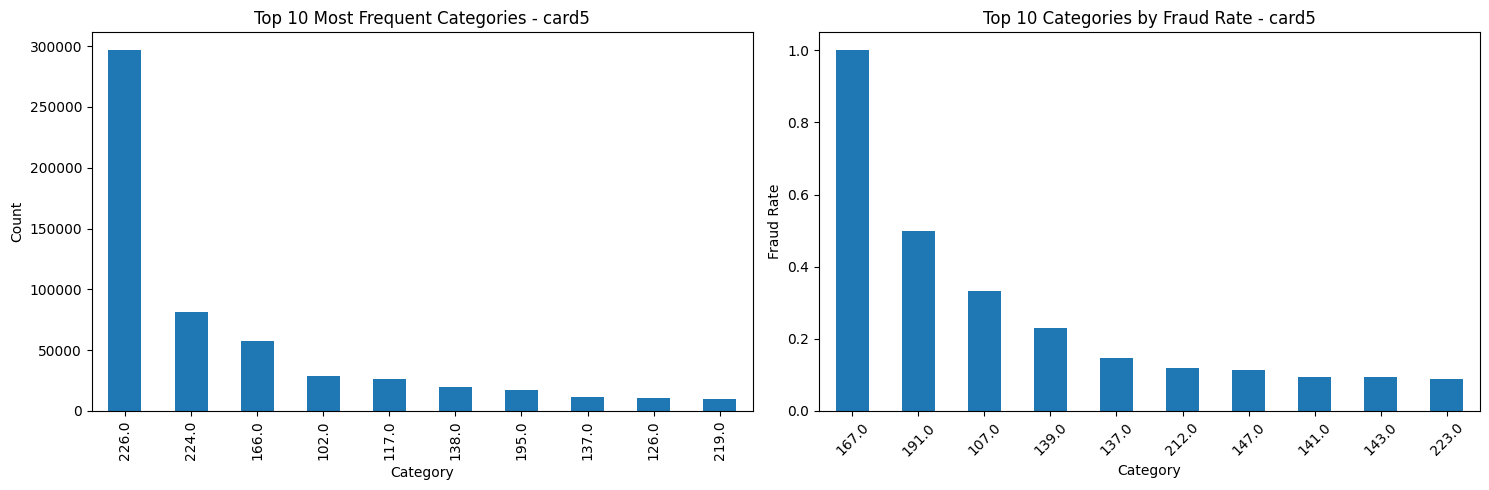


Analysis for card5:
Number of unique values: 119
Missing values: 4259 (0.72%)

Top 5 categories by frequency:
card5
226.0    296546
224.0     81513
166.0     57140
102.0     29105
117.0     25941


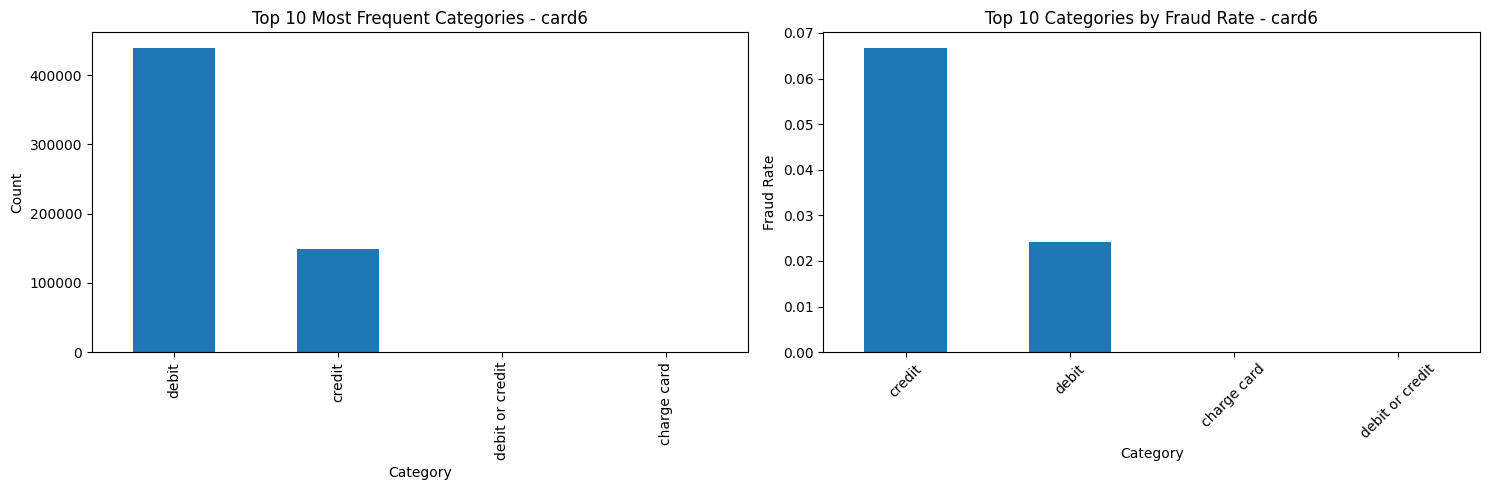


Analysis for card6:
Number of unique values: 4
Missing values: 1571 (0.27%)

Top 5 categories by frequency:
card6
debit              439938
credit             148986
debit or credit        30
charge card            15


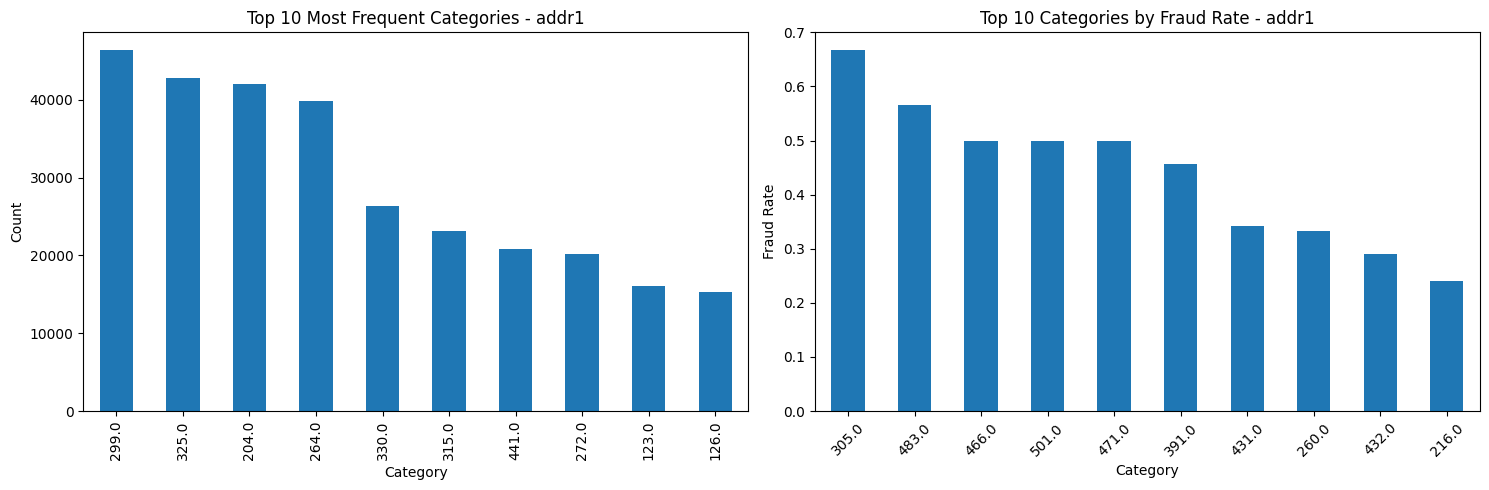


Analysis for addr1:
Number of unique values: 332
Missing values: 65706 (11.13%)

Top 5 categories by frequency:
addr1
299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287


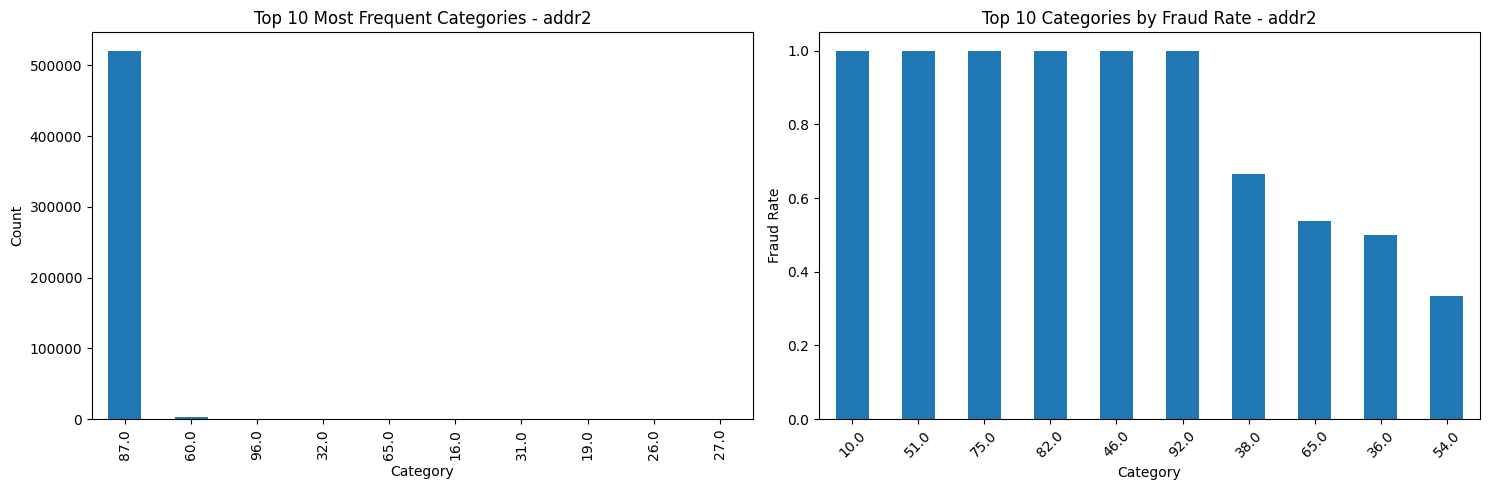


Analysis for addr2:
Number of unique values: 74
Missing values: 65706 (11.13%)

Top 5 categories by frequency:
addr2
87.0    520481
60.0      3084
96.0       638
32.0        91
65.0        82


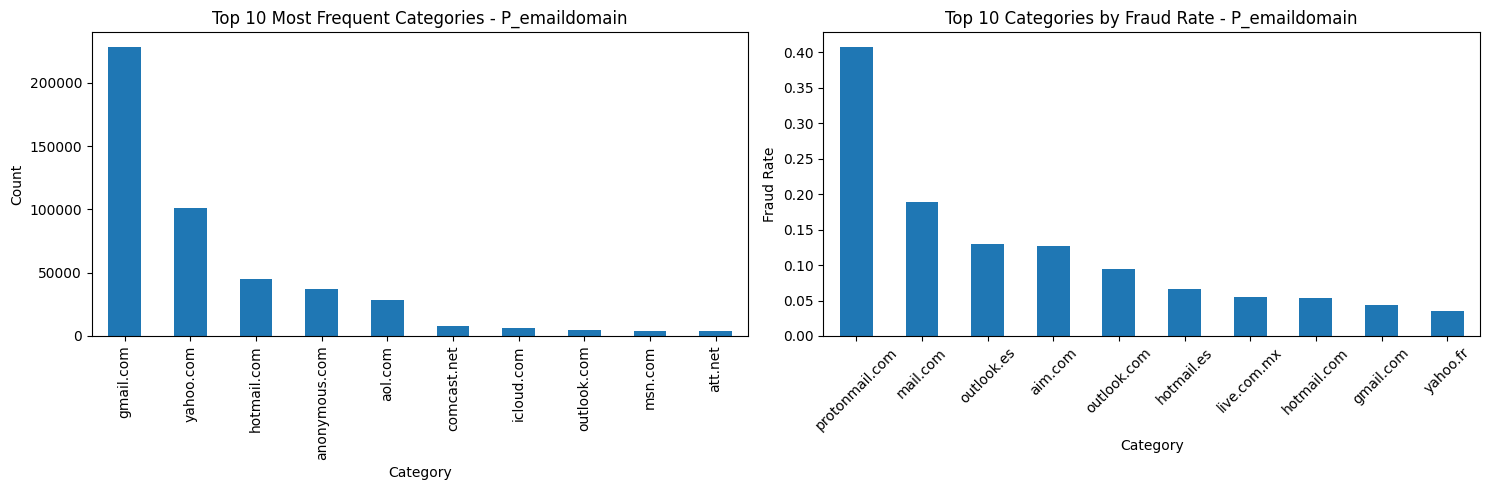


Analysis for P_emaildomain:
Number of unique values: 59
Missing values: 94456 (15.99%)

Top 5 categories by frequency:
P_emaildomain
gmail.com        228355
yahoo.com        100934
hotmail.com       45250
anonymous.com     36998
aol.com           28289


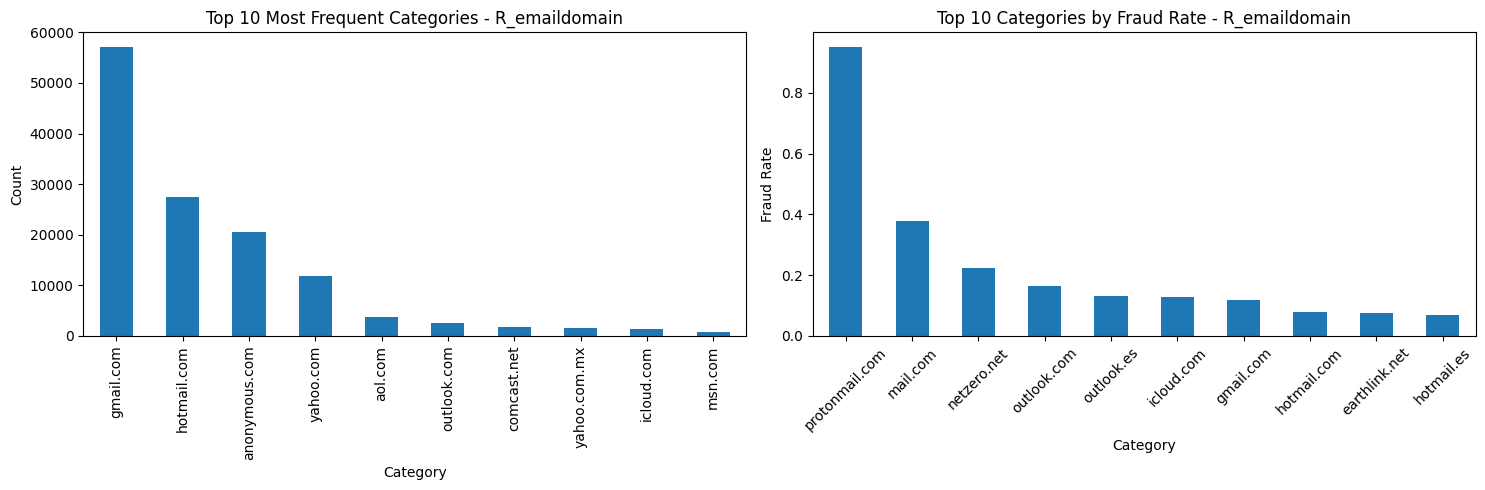


Analysis for R_emaildomain:
Number of unique values: 60
Missing values: 453249 (76.75%)

Top 5 categories by frequency:
R_emaildomain
gmail.com        57147
hotmail.com      27509
anonymous.com    20529
yahoo.com        11842
aol.com           3701


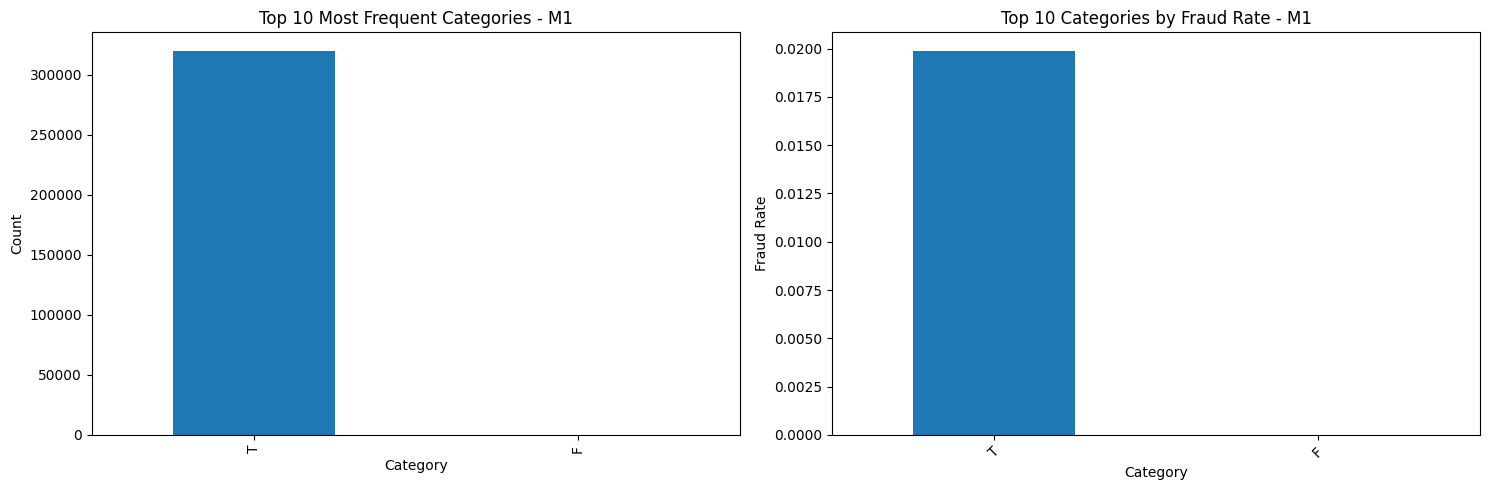


Analysis for M1:
Number of unique values: 2
Missing values: 271100 (45.91%)

Top 5 categories by frequency:
M1
T    319415
F        25


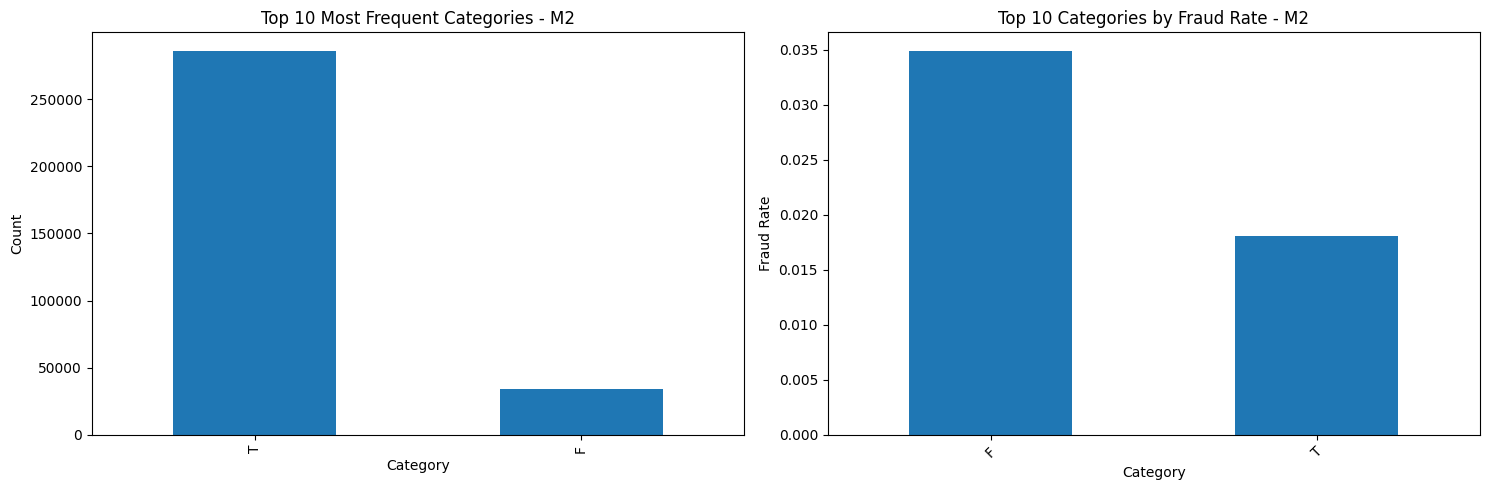


Analysis for M2:
Number of unique values: 2
Missing values: 271100 (45.91%)

Top 5 categories by frequency:
M2
T    285468
F     33972


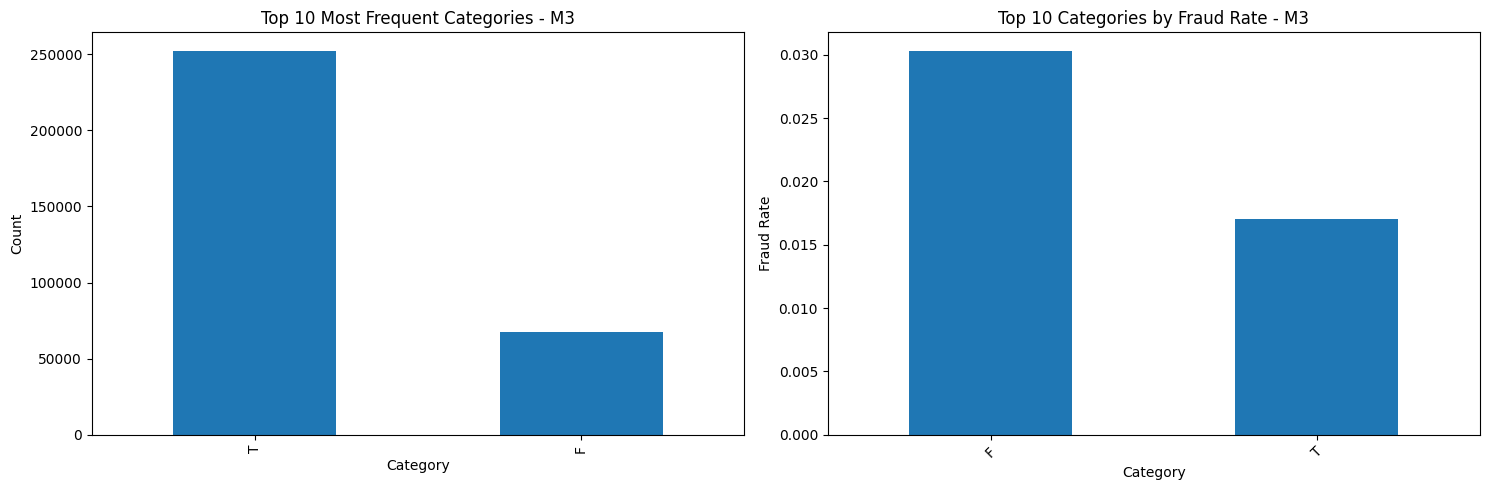


Analysis for M3:
Number of unique values: 2
Missing values: 271100 (45.91%)

Top 5 categories by frequency:
M3
T    251731
F     67709


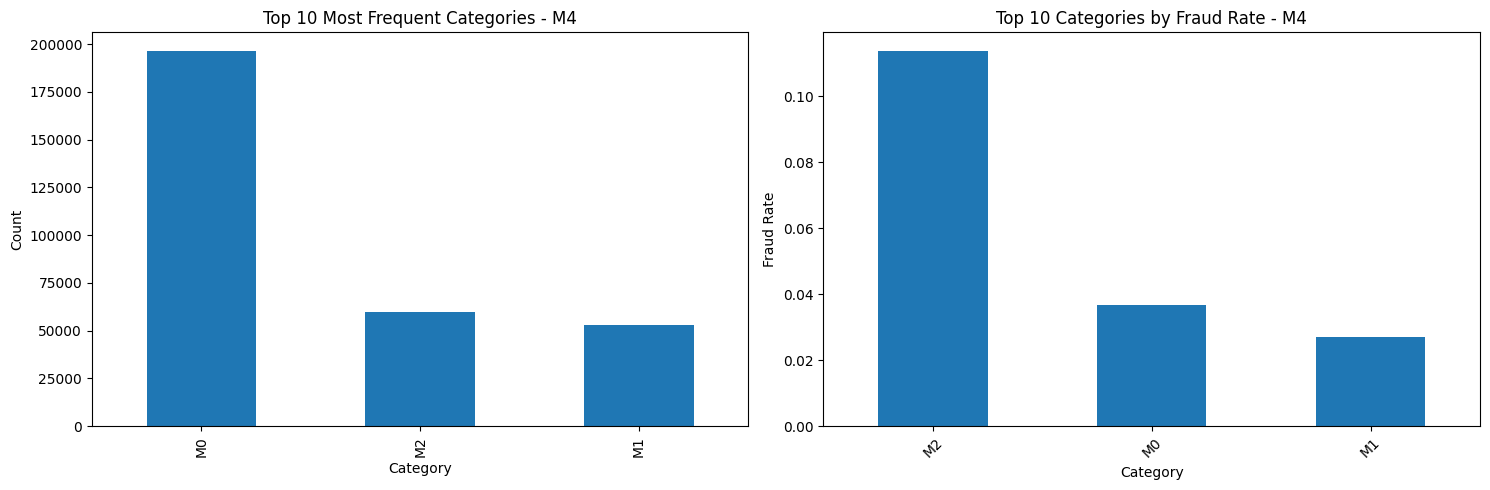


Analysis for M4:
Number of unique values: 3
Missing values: 281444 (47.66%)

Top 5 categories by frequency:
M4
M0    196405
M2     59865
M1     52826


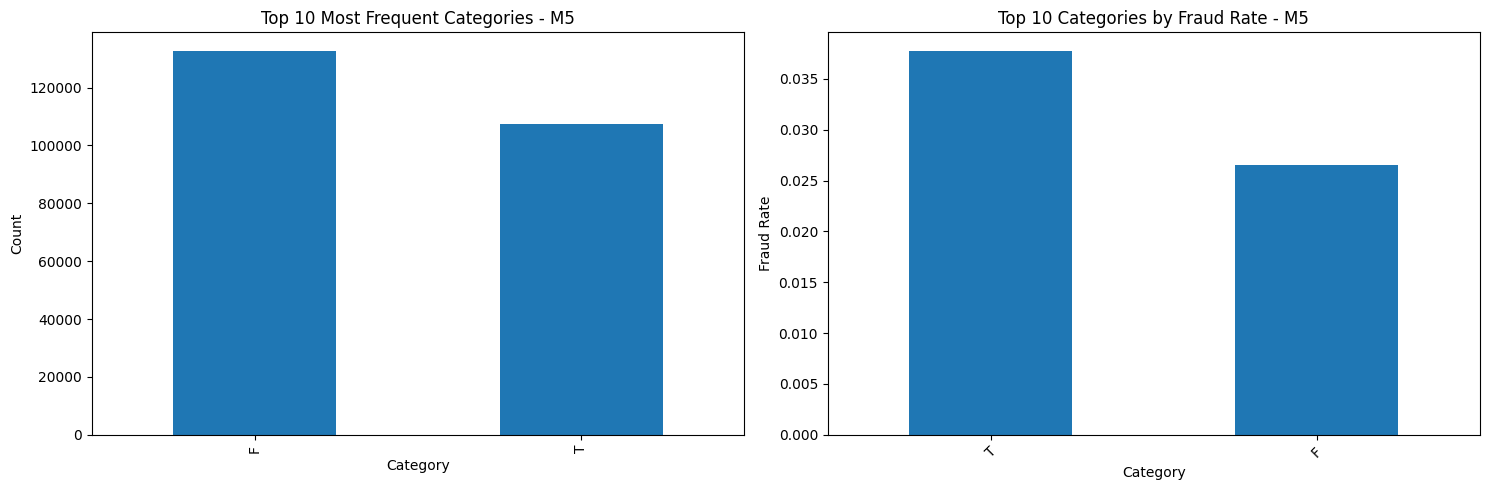


Analysis for M5:
Number of unique values: 2
Missing values: 350482 (59.35%)

Top 5 categories by frequency:
M5
F    132491
T    107567


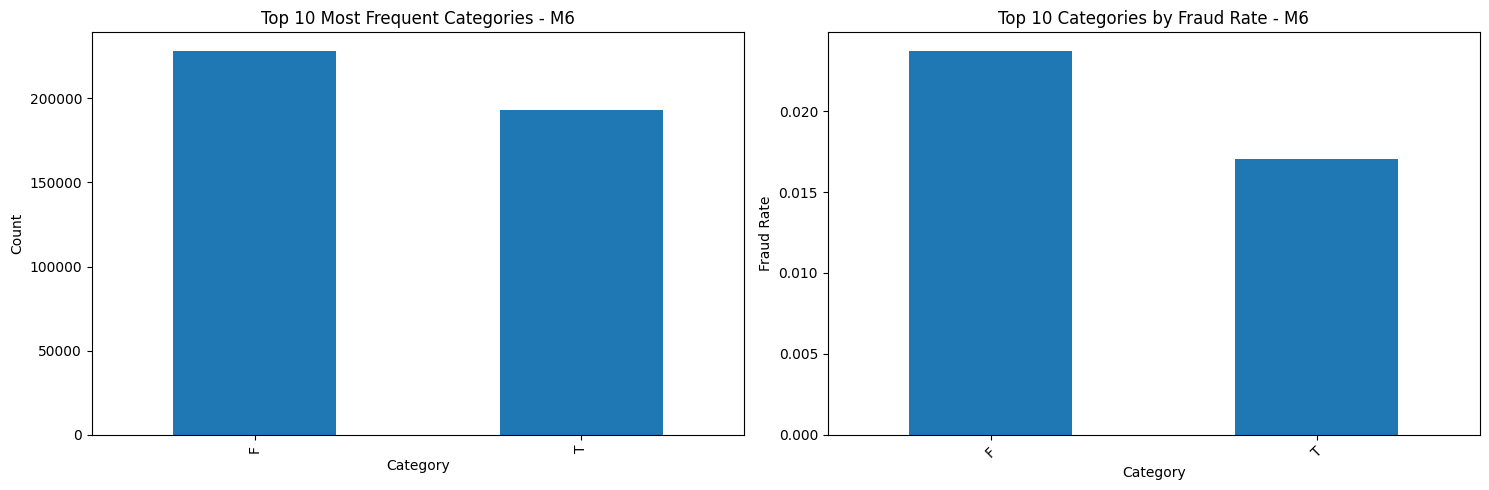


Analysis for M6:
Number of unique values: 2
Missing values: 169360 (28.68%)

Top 5 categories by frequency:
M6
F    227856
T    193324


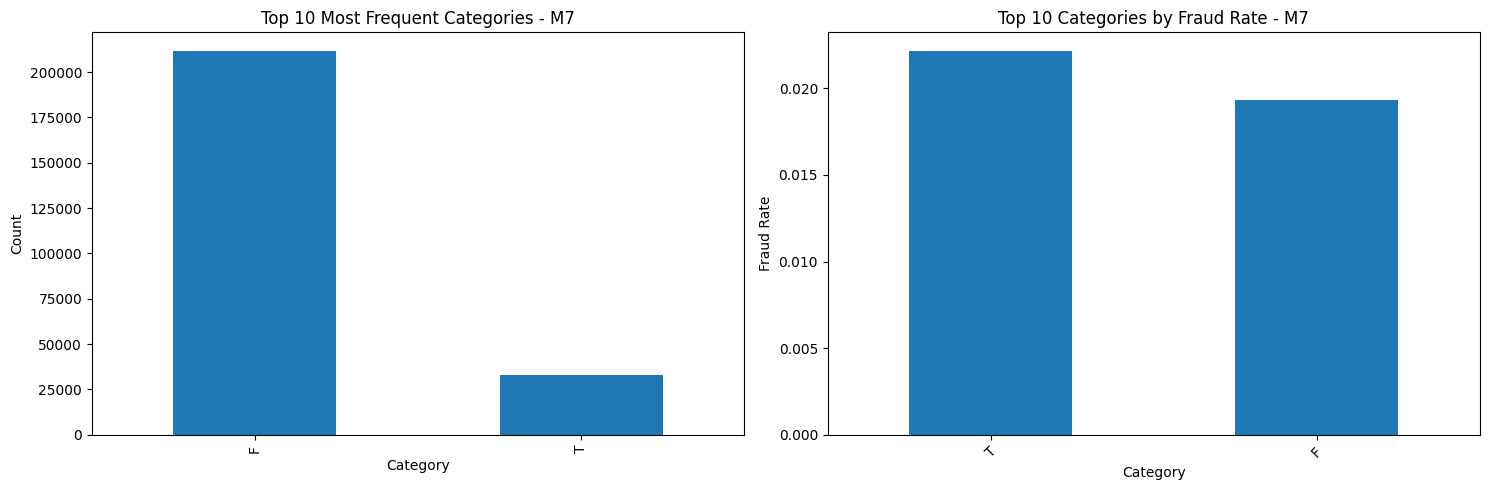


Analysis for M7:
Number of unique values: 2
Missing values: 346265 (58.64%)

Top 5 categories by frequency:
M7
F    211374
T     32901


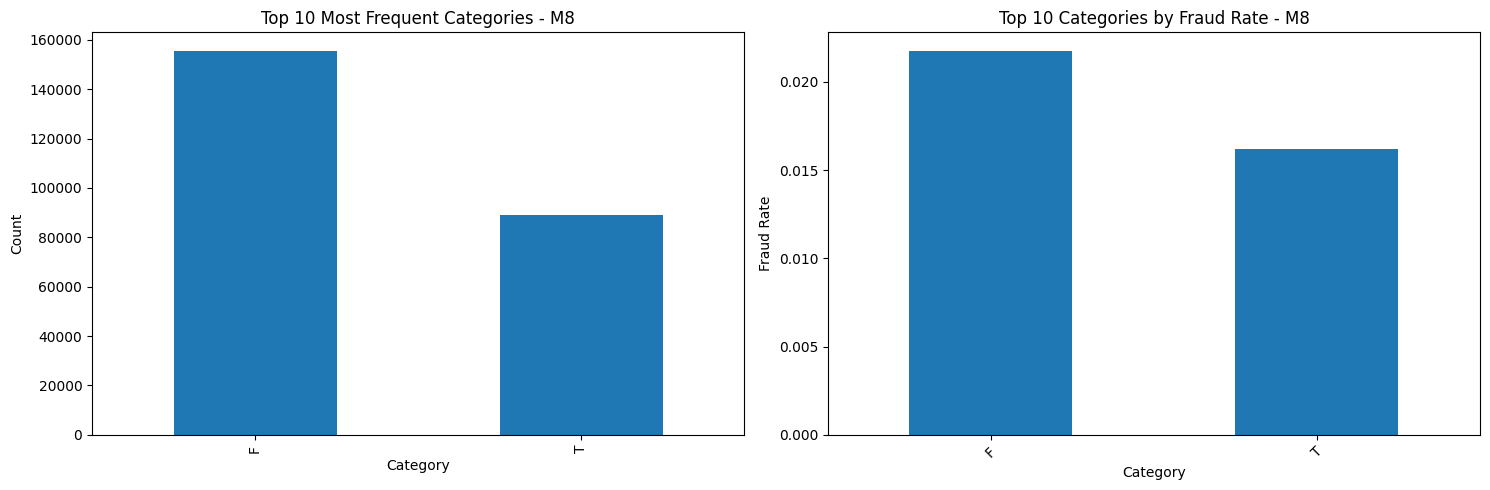


Analysis for M8:
Number of unique values: 2
Missing values: 346252 (58.63%)

Top 5 categories by frequency:
M8
F    155251
T     89037


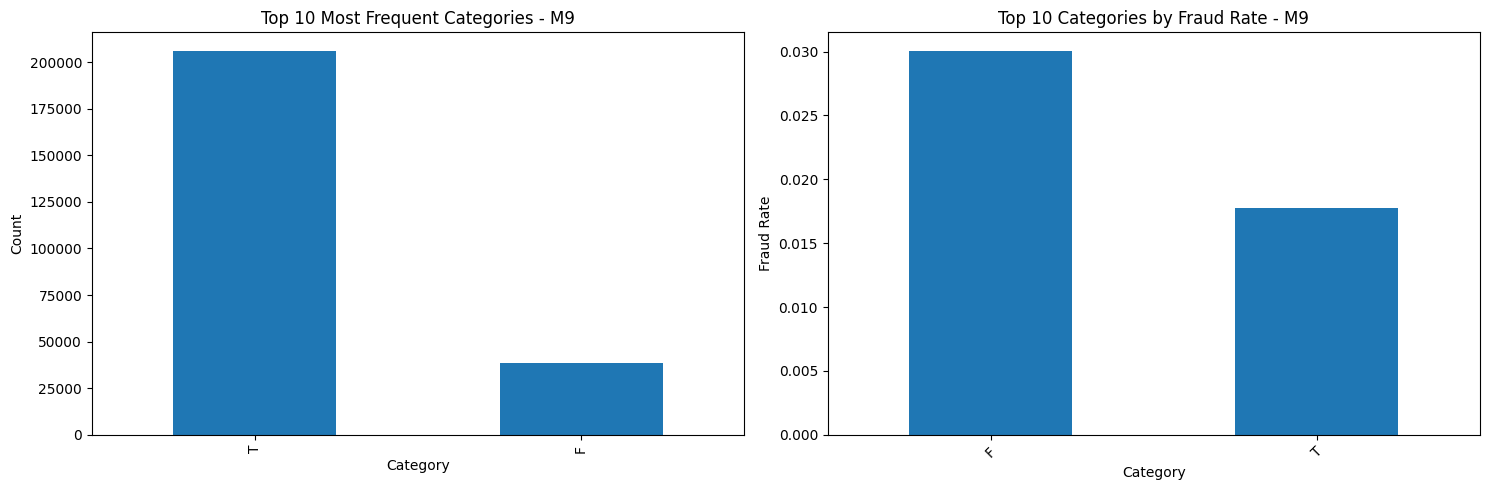


Analysis for M9:
Number of unique values: 2
Missing values: 346252 (58.63%)

Top 5 categories by frequency:
M9
T    205656
F     38632


In [8]:
# List of categorical features to analyze
categorical_features = ['ProductCD'] + [f'card{i}' for i in range(1,7)] + ['addr1', 'addr2'] + \
                      ['P_emaildomain', 'R_emaildomain'] + [f'M{i}' for i in range(1,10)]

def analyze_categorical(feature):
    if feature not in train.columns:
        return None
    
    # Get value counts and fraud rates
    value_counts = train[feature].value_counts()
    fraud_rates = train.groupby(feature)['isFraud'].mean().sort_values(ascending=False)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Top 10 most frequent categories
    value_counts.head(10).plot(kind='bar', ax=ax1)
    ax1.set_title(f'Top 10 Most Frequent Categories - {feature}')
    ax1.set_xlabel('Category')
    ax1.set_ylabel('Count')
    plt.xticks(rotation=45)
    
    # Plot 2: Fraud rate by category (top 10)
    fraud_rates.head(10).plot(kind='bar', ax=ax2)
    ax2.set_title(f'Top 10 Categories by Fraud Rate - {feature}')
    ax2.set_xlabel('Category')
    ax2.set_ylabel('Fraud Rate')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nAnalysis for {feature}:")
    print(f"Number of unique values: {len(value_counts)}")
    print(f"Missing values: {train[feature].isnull().sum()} ({train[feature].isnull().mean():.2%})")
    print("\nTop 5 categories by frequency:")
    print(value_counts.head().to_string())

# Analyze each categorical feature
for feature in categorical_features:
    analyze_categorical(feature)


## 7. Count & Time Features



- **C1–C14 (counts)**:

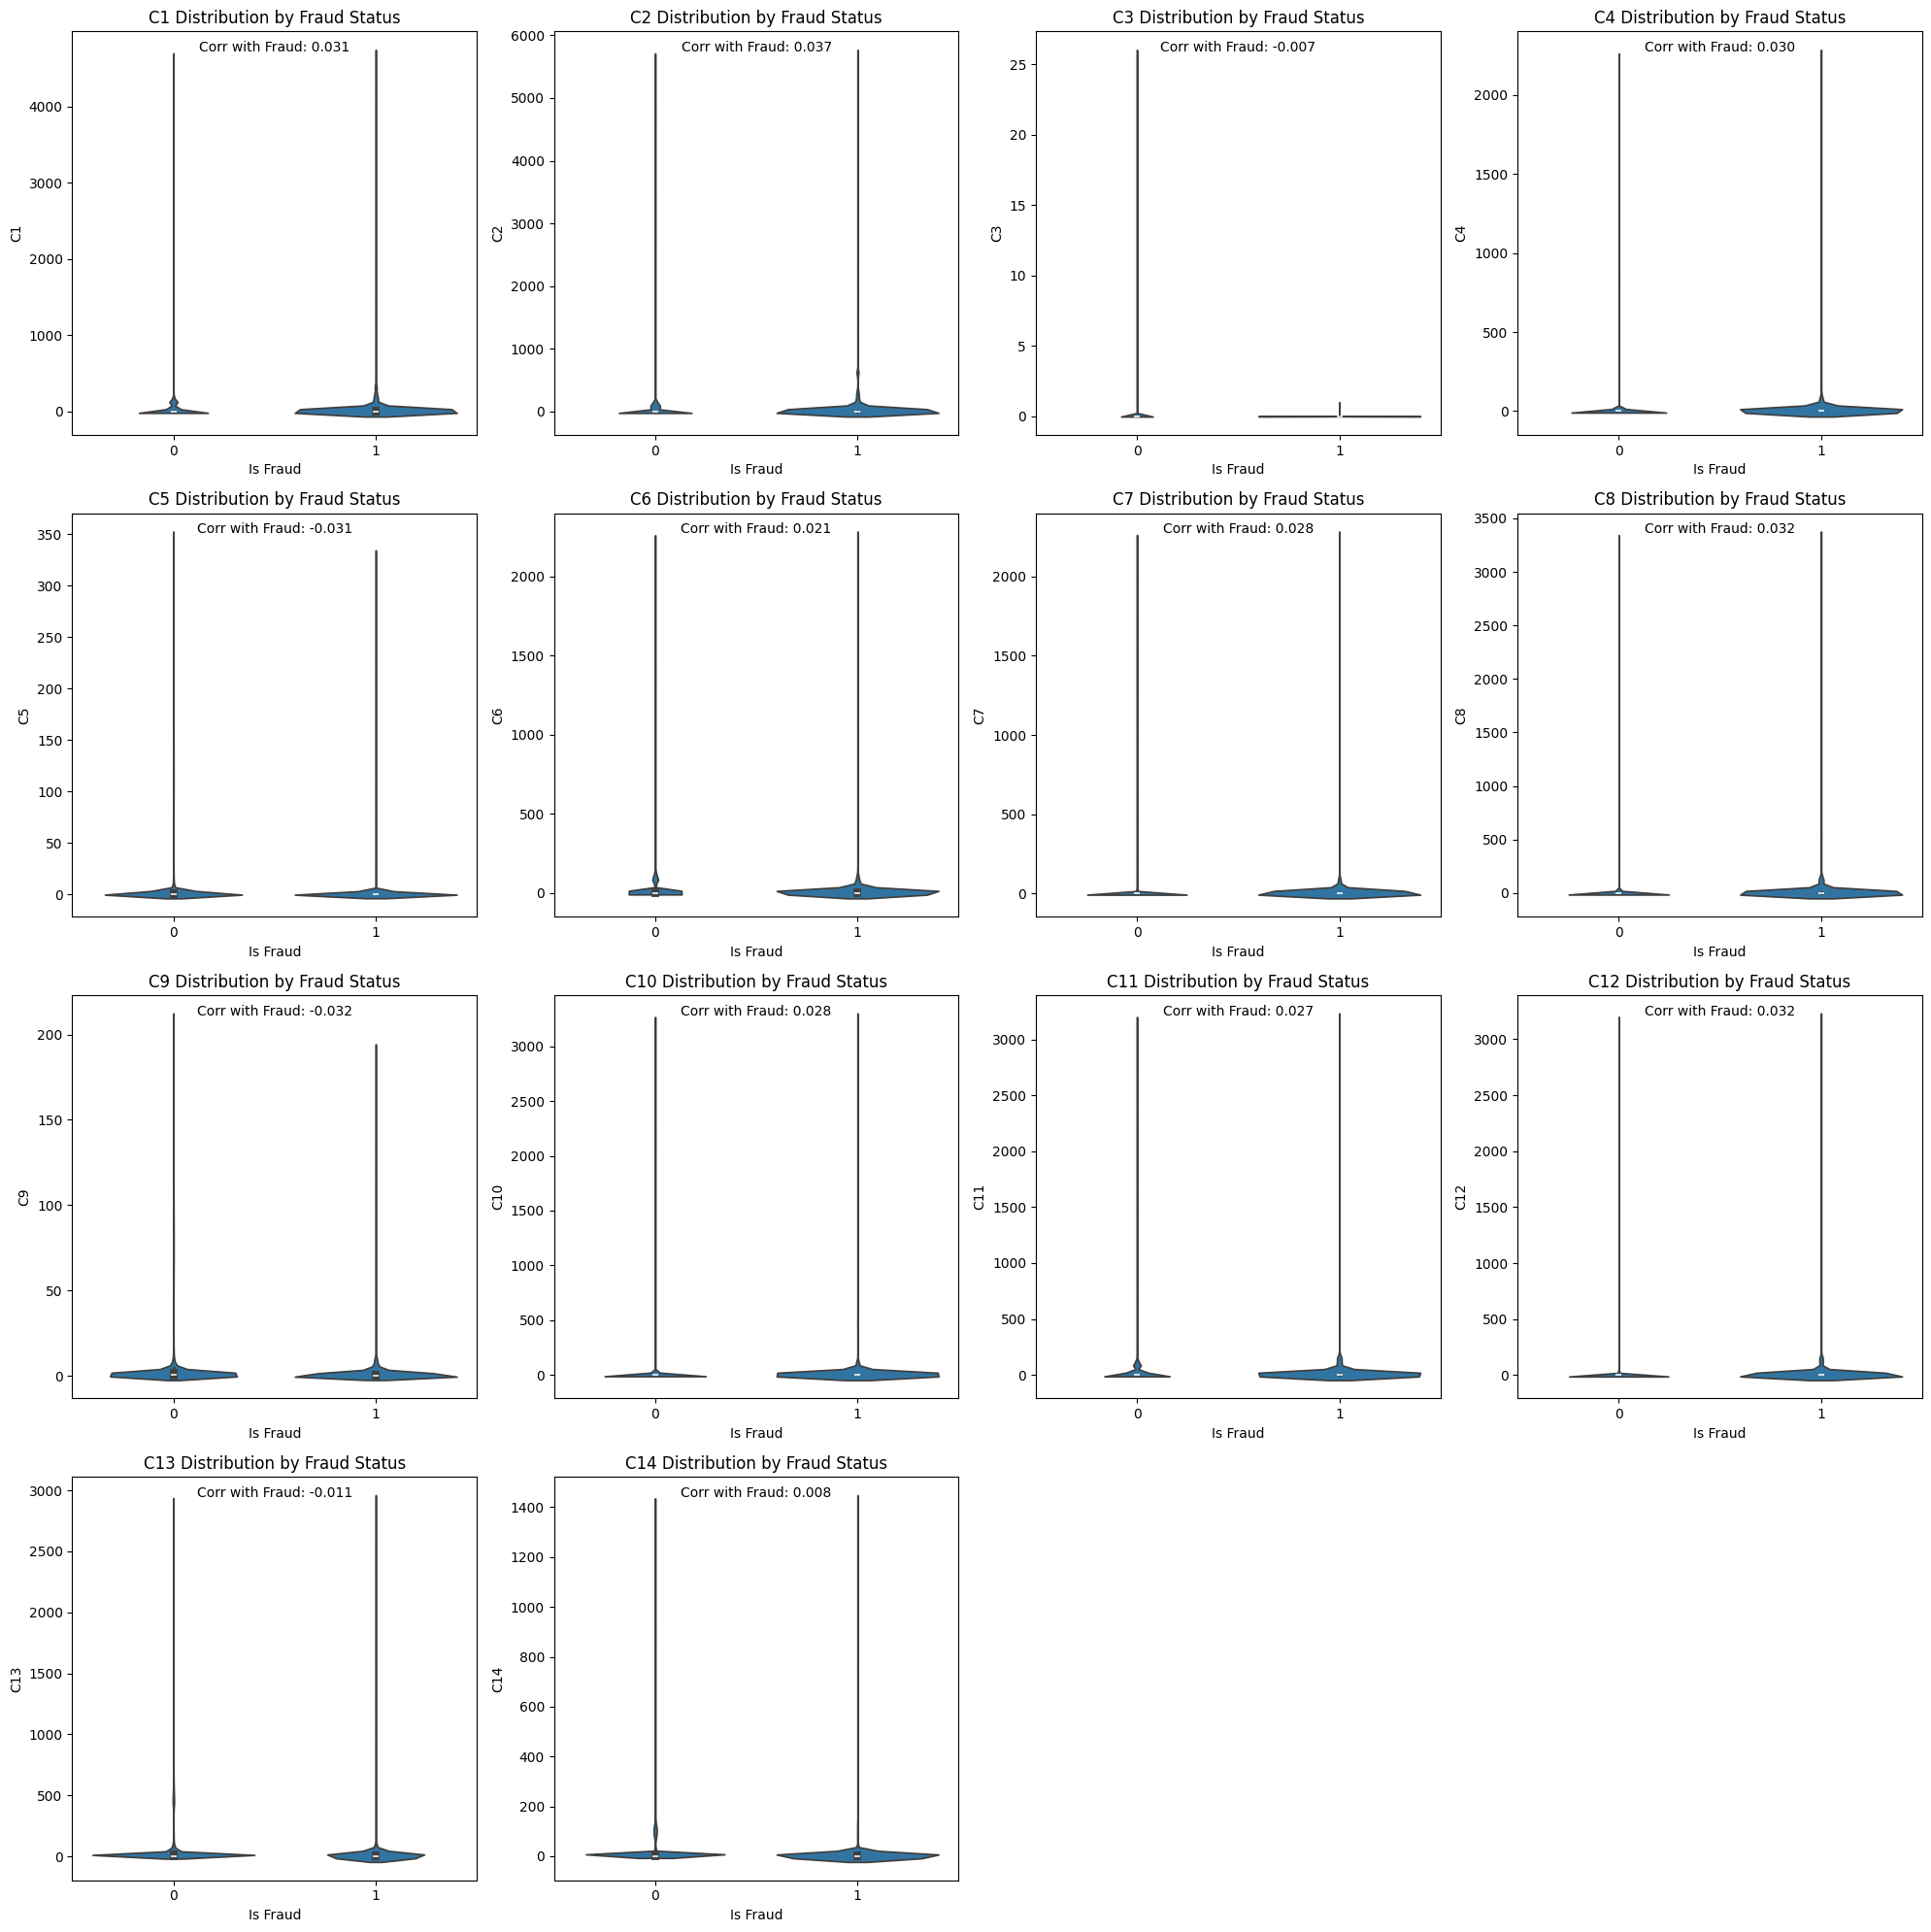


Count Features Statistics:

C1:
Missing values: 0 (0.00%)
Mean value: 14.09
Correlation with fraud: 0.031
Mean for non-fraud: 13.31
Mean for fraud: 35.54
----------------------------------------

C2:
Missing values: 0 (0.00%)
Mean value: 15.27
Correlation with fraud: 0.037
Mean for non-fraud: 14.17
Mean for fraud: 45.51
----------------------------------------

C3:
Missing values: 0 (0.00%)
Mean value: 0.01
Correlation with fraud: -0.007
Mean for non-fraud: 0.01
Mean for fraud: 0.00
----------------------------------------

C4:
Missing values: 0 (0.00%)
Mean value: 4.09
Correlation with fraud: 0.030
Mean for non-fraud: 3.69
Mean for fraud: 15.08
----------------------------------------

C5:
Missing values: 0 (0.00%)
Mean value: 5.57
Correlation with fraud: -0.031
Mean for non-fraud: 5.72
Mean for fraud: 1.41
----------------------------------------

C6:
Missing values: 0 (0.00%)
Mean value: 9.07
Correlation with fraud: 0.021
Mean for non-fraud: 8.79
Mean for fraud: 16.92
-------------

In [149]:
# Analyze count features (C1-C14)
count_features = [f'C{i}' for i in range(1, 15)]

# Create a figure for count features distribution
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.ravel()

# Plot distribution for each count feature
for idx, feature in enumerate(count_features):
    if feature in train.columns:
        # Create violin plot split by fraud status
        sns.violinplot(data=train, x='isFraud', y=feature, ax=axes[idx])
        axes[idx].set_title(f'{feature} Distribution by Fraud Status')
        axes[idx].set_xlabel('Is Fraud')
        
        # Calculate and display correlation with fraud
        correlation = train[[feature, 'isFraud']].corr().iloc[0,1]
        axes[idx].text(0.5, 0.95, f'Corr with Fraud: {correlation:.3f}', 
                      horizontalalignment='center', transform=axes[idx].transAxes)

# Remove empty subplots if any
for idx in range(len(count_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Print statistics for count features
print("\nCount Features Statistics:")
for feature in count_features:
    if feature in train.columns:
        print(f"\n{feature}:")
        print(f"Missing values: {train[feature].isnull().sum()} ({train[feature].isnull().mean():.2%})")
        print(f"Mean value: {train[feature].mean():.2f}")
        print(f"Correlation with fraud: {train[[feature, 'isFraud']].corr().iloc[0,1]:.3f}")
        
        # Calculate mean values for fraud vs non-fraud
        mean_by_fraud = train.groupby('isFraud')[feature].mean()
        print(f"Mean for non-fraud: {mean_by_fraud[0]:.2f}")
        print(f"Mean for fraud: {mean_by_fraud[1]:.2f}")
        print("-" * 40)


- **D1–D15 (timedeltas)**:


We see that timedeltas are increasing over time (like transactionDT) (apart from D9)

In [ ]:
train

In [53]:
def plot_d_cols():
    fig, axes = plt.subplots(5, 3, figsize=(20, 24), squeeze=False)
    axes = axes.flatten()

    for idx, i in enumerate(range(1,16)):
        ax = axes[idx]
        col = 'D'+str(i)
        # scatter plot of D columns by TransactionDT
        ax.scatter(train['TransactionDT'], train[col])
        ax.set_title(f'{col}')
        ax.set_xlabel('Transaction DT')
        ax.set_ylabel(col)

    plt.tight_layout()
    plt.show()

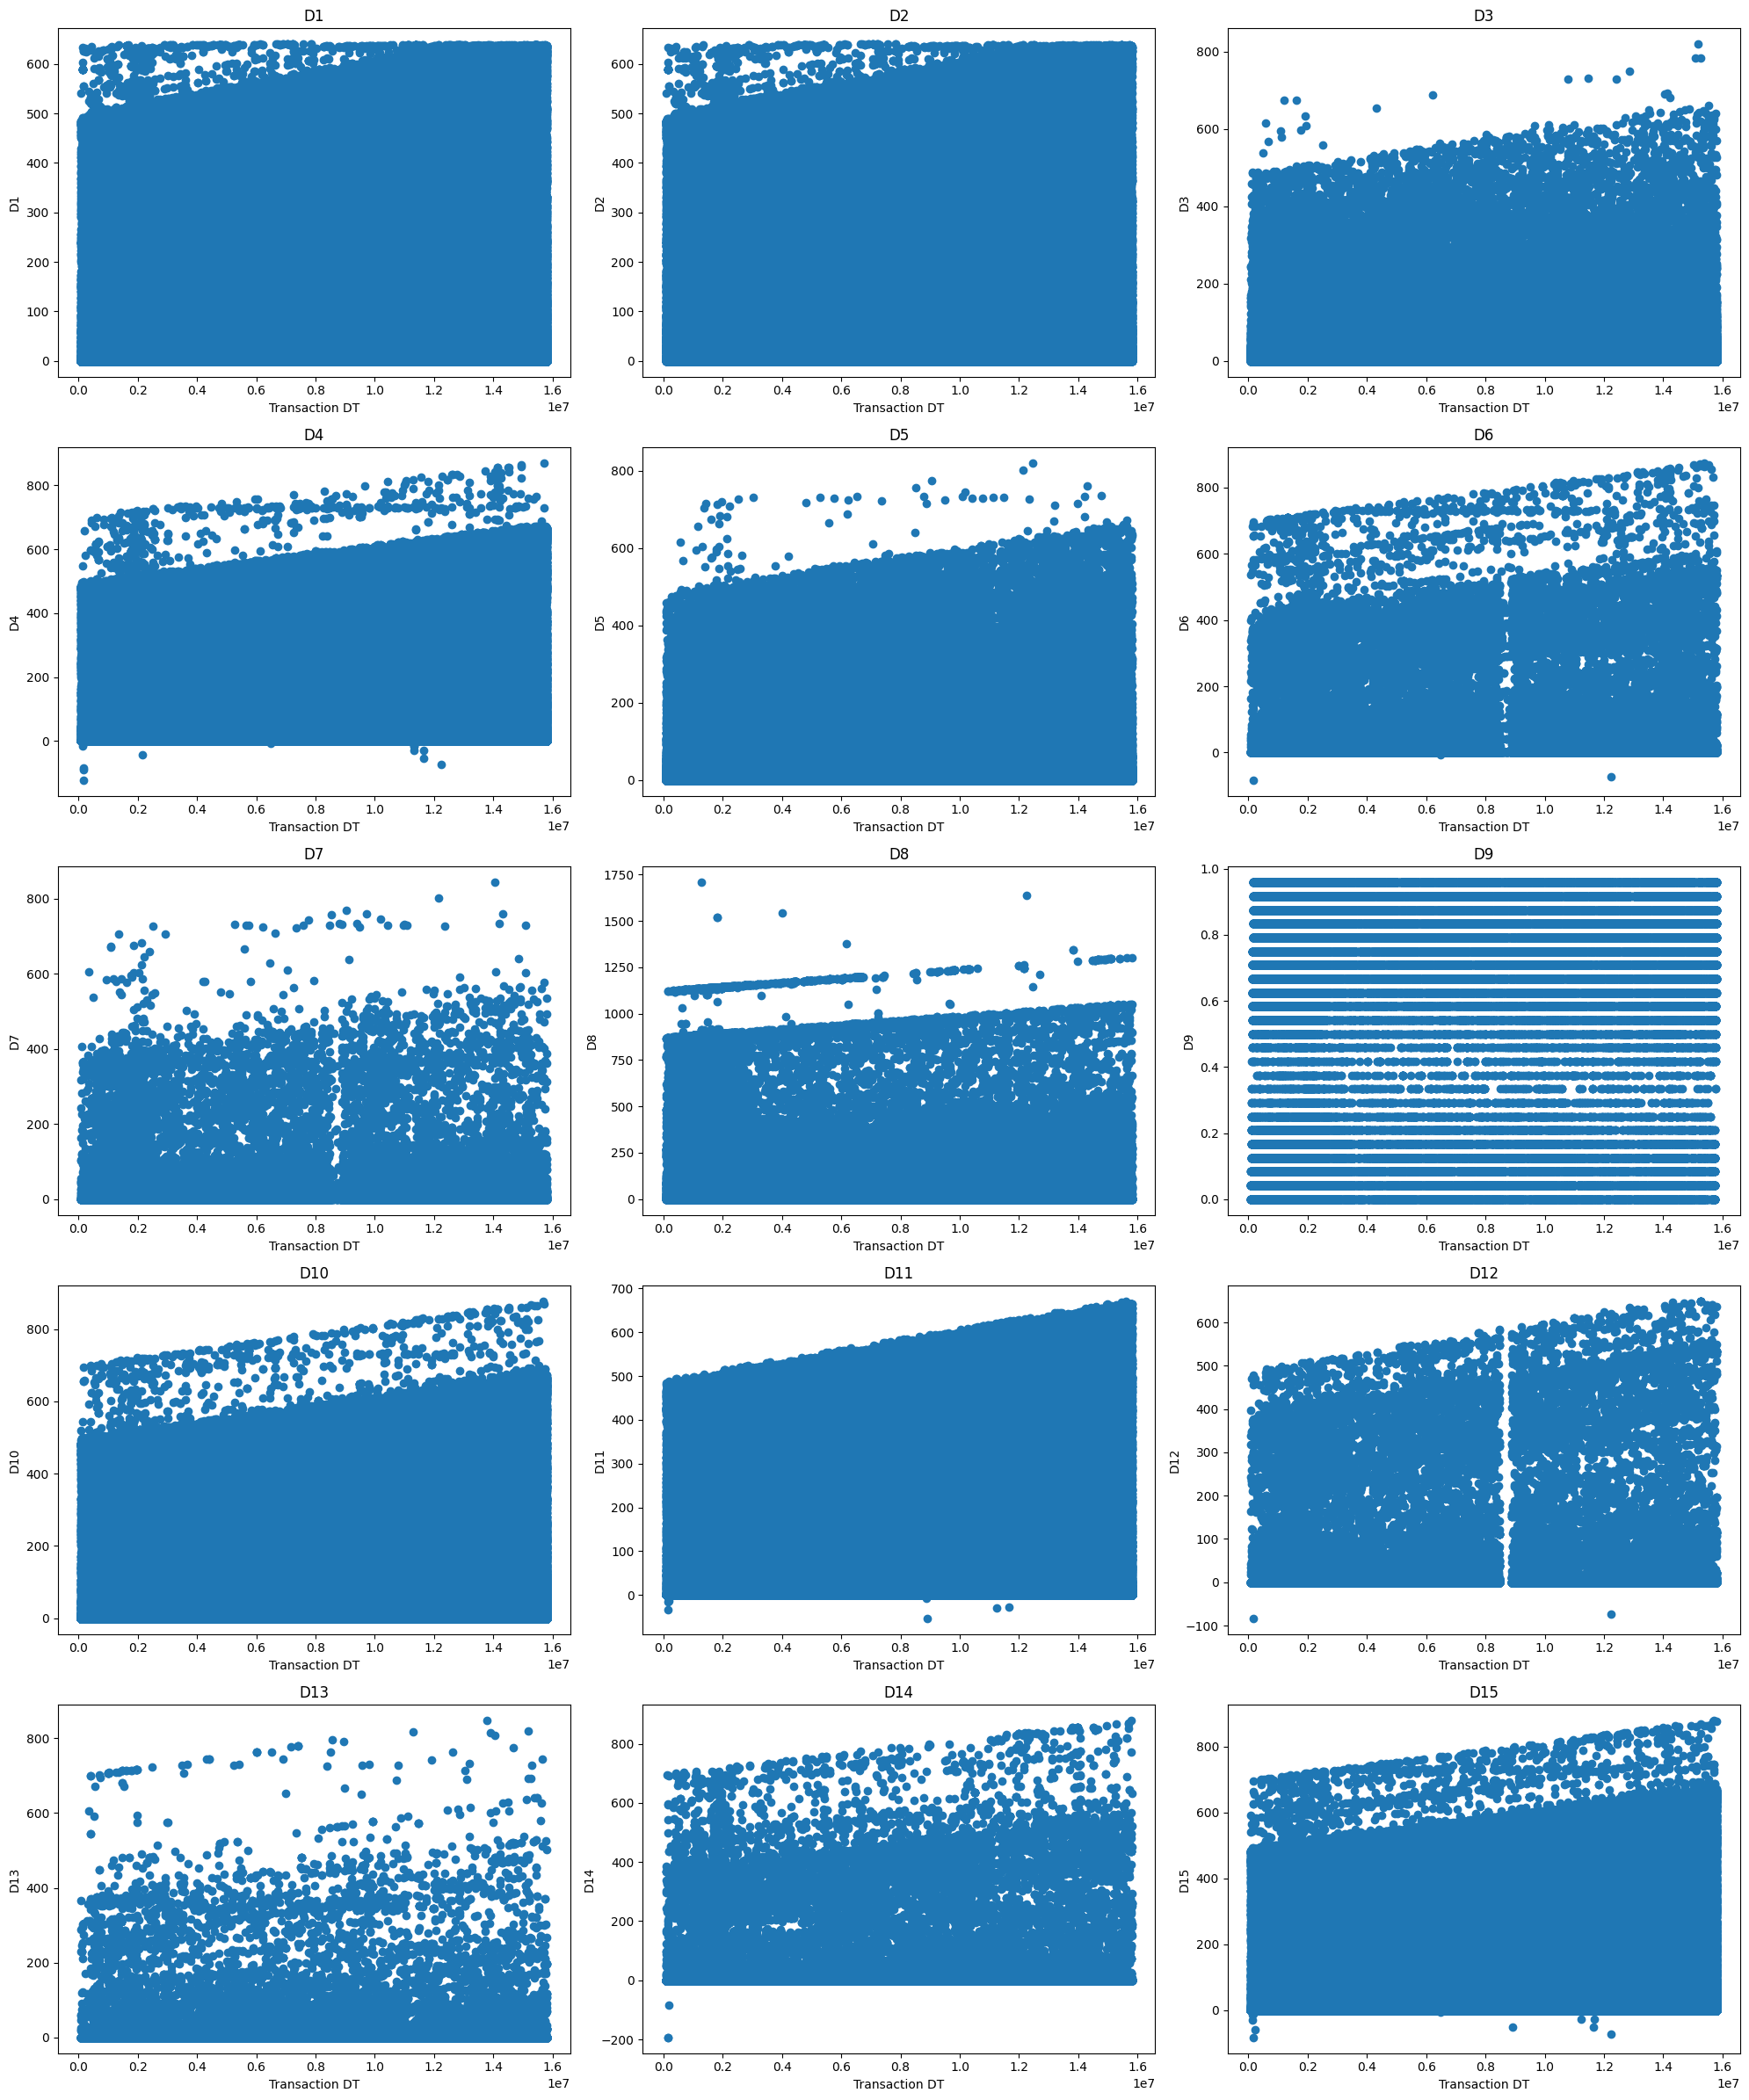

In [57]:
plot_d_cols()

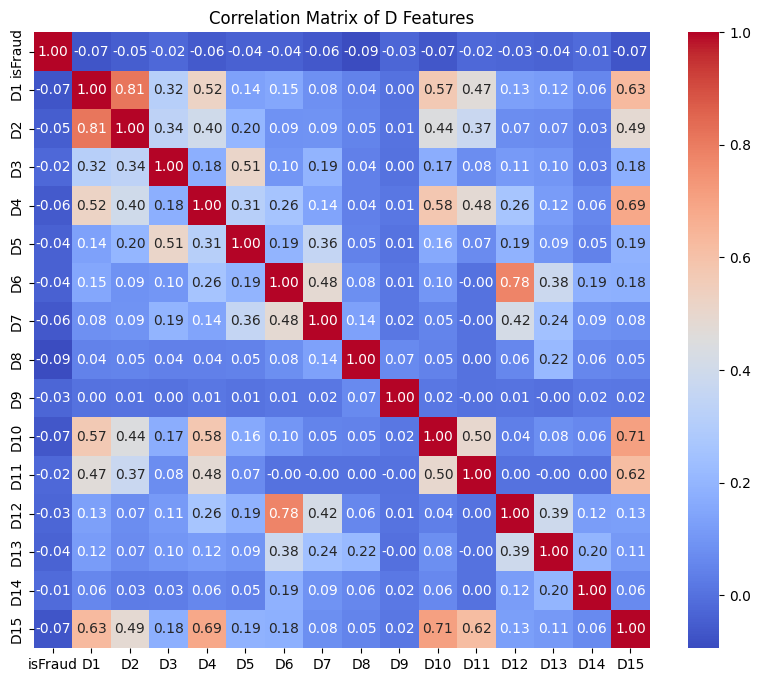

In [63]:
# D features correlation analysis 
d_cols = [f'D{i}' for i in range(1, 16) if f'D{i}' in train.columns]
d_data = train[d_cols].copy()
# Fill missing values with the mean of each column
d_data.fillna(d_data.mean(), inplace=True)
# Standardize the data
scaler = StandardScaler()
d_data_scaled = scaler.fit_transform(d_data)
d_data_scaled = pd.DataFrame(d_data_scaled, columns=d_cols)
# Compute the correlation matrix
corr_matrix = pd.concat([train['isFraud'],d_data_scaled], axis=1).corr()
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of D Features') 
plt.show()


Timedeltas features are measuring time (in days) passed from a certain time in the past, so in order to get some value over these features, we will get the time difference from the D\<index\> feature to the transactionDT (converted to days)

In [62]:
# normalize D columns
for i in range(1,16):
    if i == 9: continue
    train['D'+str(i)] =  train['D'+str(i)] - train.TransactionDT/np.float32(24*60*60)
    test['D'+str(i)] = test['D'+str(i)] - test.TransactionDT/np.float32(24*60*60) 
    # train['D'+str(i)] = train_transaction['D'+str(i)]
    # test['D'+str(i)] = test_transaction['D'+str(i)]

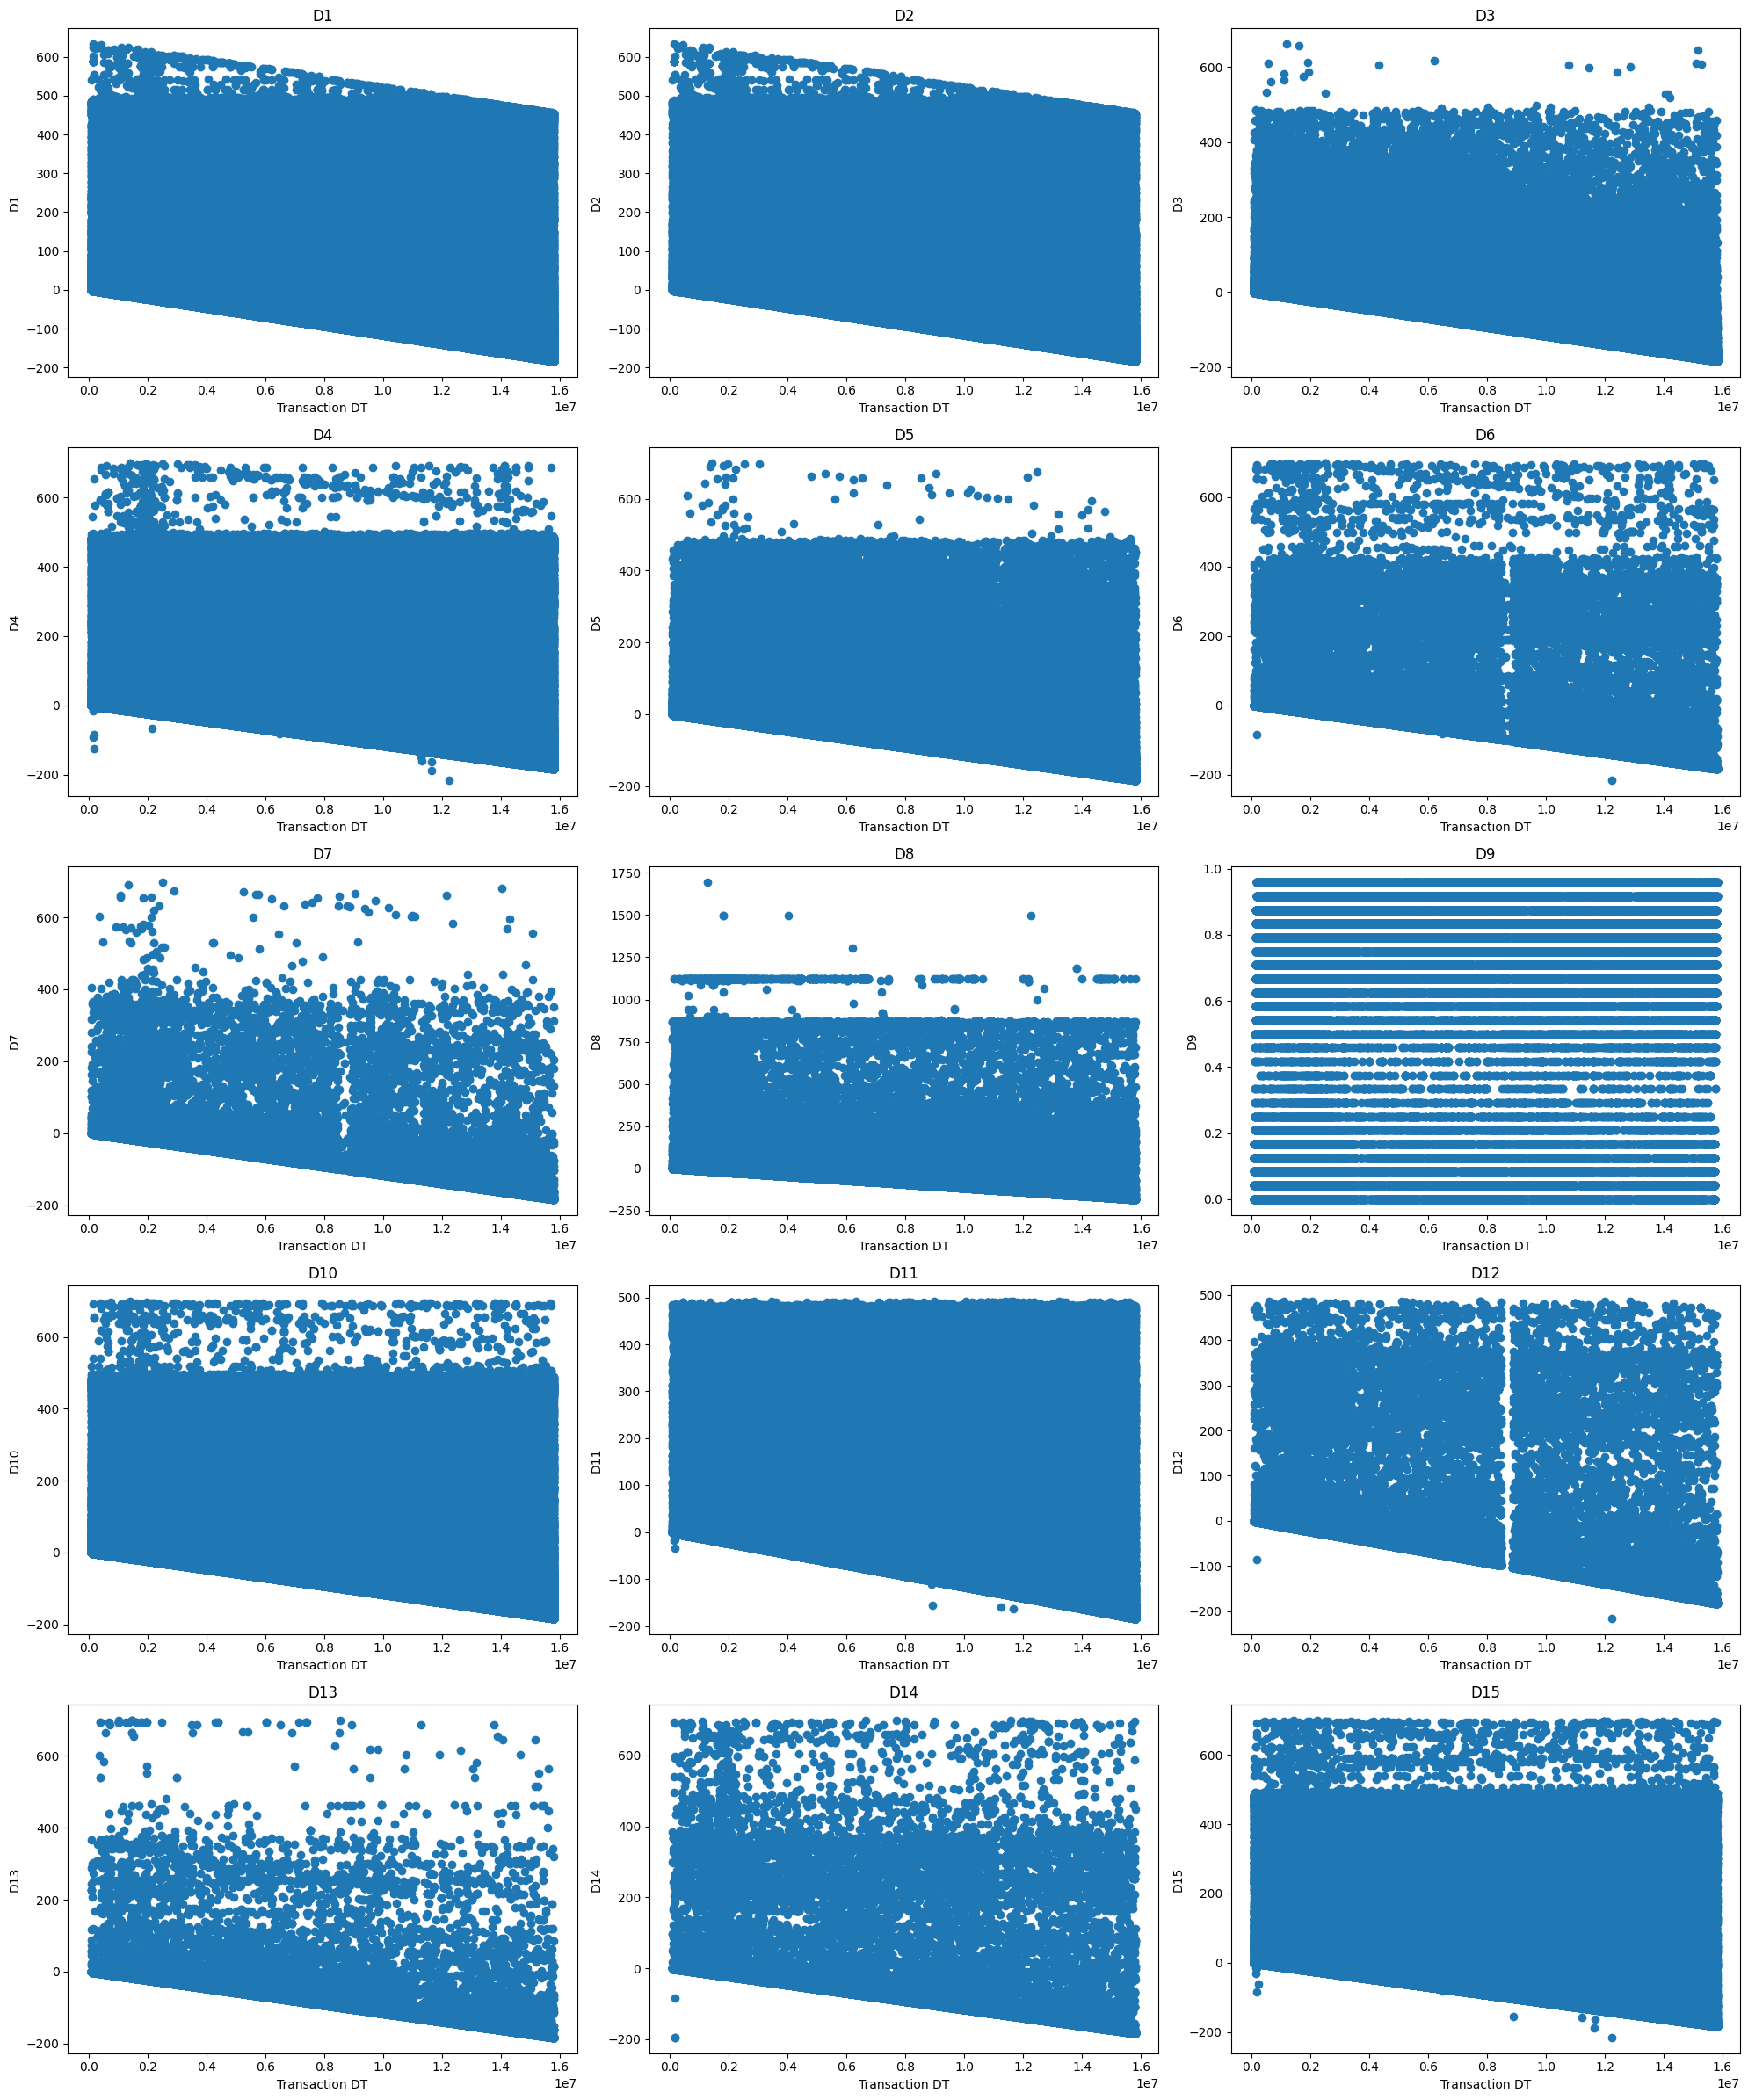

In [55]:
plot_d_cols()

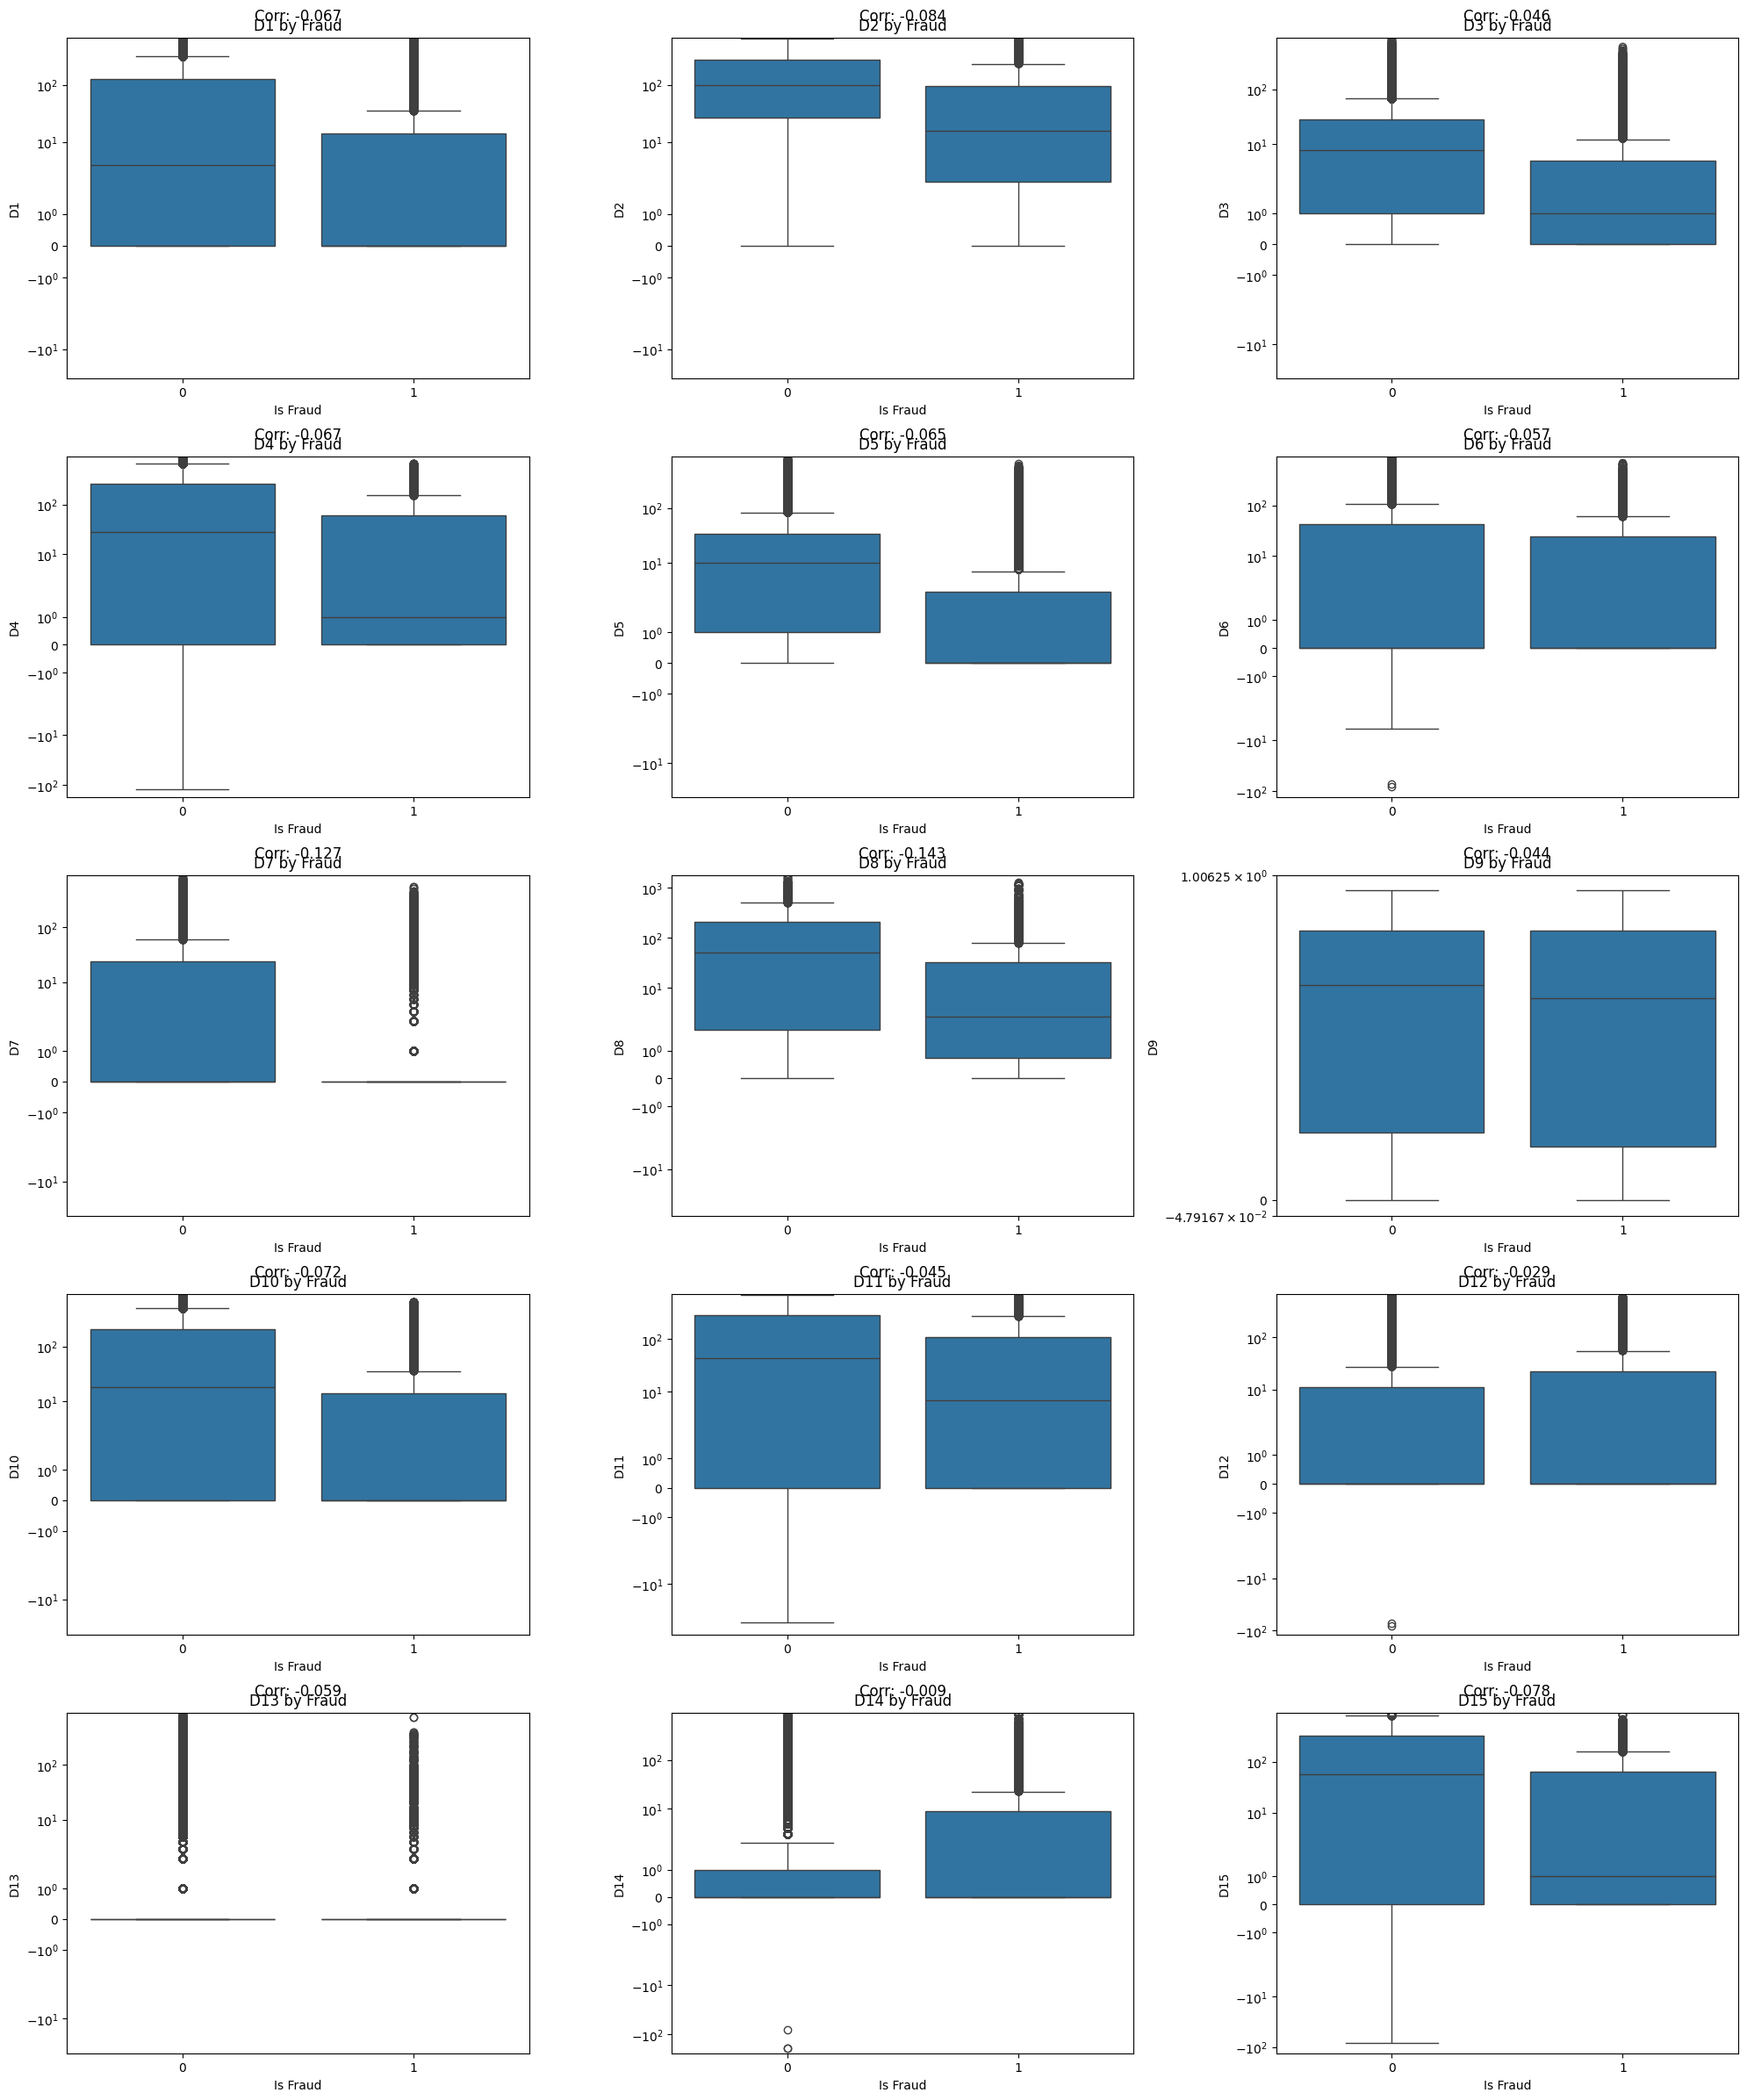

In [ ]:
fig, axes = plt.subplots(5, 3, figsize=(20, 24))
axes = axes.flatten()

for idx, i in enumerate(range(1,16)):
    ax = axes[idx]
    col = 'D'+str(i)
    # box plot of D columns by fraud
    sns.boxplot(data=train, x='isFraud', y=col, ax=ax)
    ax.set_title(f'{col} by Fraud')
    ax.set_xlabel('Is Fraud')
    ax.set_ylabel(col)
    ax.set_yscale('symlog')
    # Calculate correlation and annotate
    if train[col].notna().sum() > 0:
        corr = train[[col, 'isFraud']].corr().iloc[0,1]
        annot_text = f"Corr: {corr:.3f}" if pd.notnull(corr) else ""
        ax.text(0.5, 1.04, annot_text, fontsize=12, ha='center', va='bottom', transform=ax.transAxes)
    else:
        ax.text(0.5, 1.04, "Corr: nan", fontsize=12, ha='center', va='bottom', transform=ax.transAxes)

plt.tight_layout()
plt.show()


## 8. Vesta Engineered Features (Vxxx)


**Study of v features [here](https://www.kaggle.com/code/cdeotte/eda-for-columns-v-and-id) determined 219 V columns as redundant by correlation analysis**

In [8]:
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]
v += [96, 98, 99, 104]
v += [107, 108, 111, 115, 117, 120, 121, 123]
v += [124, 127, 129, 130, 136]
v += [138, 139, 142, 147, 156, 162]
v += [165, 160, 166]
v += [178, 176, 173, 182]
v += [187, 203, 205, 207, 215]
v += [169, 171, 175, 180, 185, 188, 198, 210, 209]
v += [218, 223, 224, 226, 228, 229, 235]
v += [240, 258, 257, 253, 252, 260, 261]
v += [264, 266, 267, 274, 277]
v += [220, 221, 234, 238, 250, 271]
v += [294, 284, 285, 286, 291, 297]
v += [303, 305, 307, 309, 310, 320]
v += [281, 283, 289, 296, 301, 314]
v += [332, 325, 335, 338]

In [9]:
v_features = [f'V{i}' for i in v if f'V{i}' in train.columns]
v_data = train[v_features]

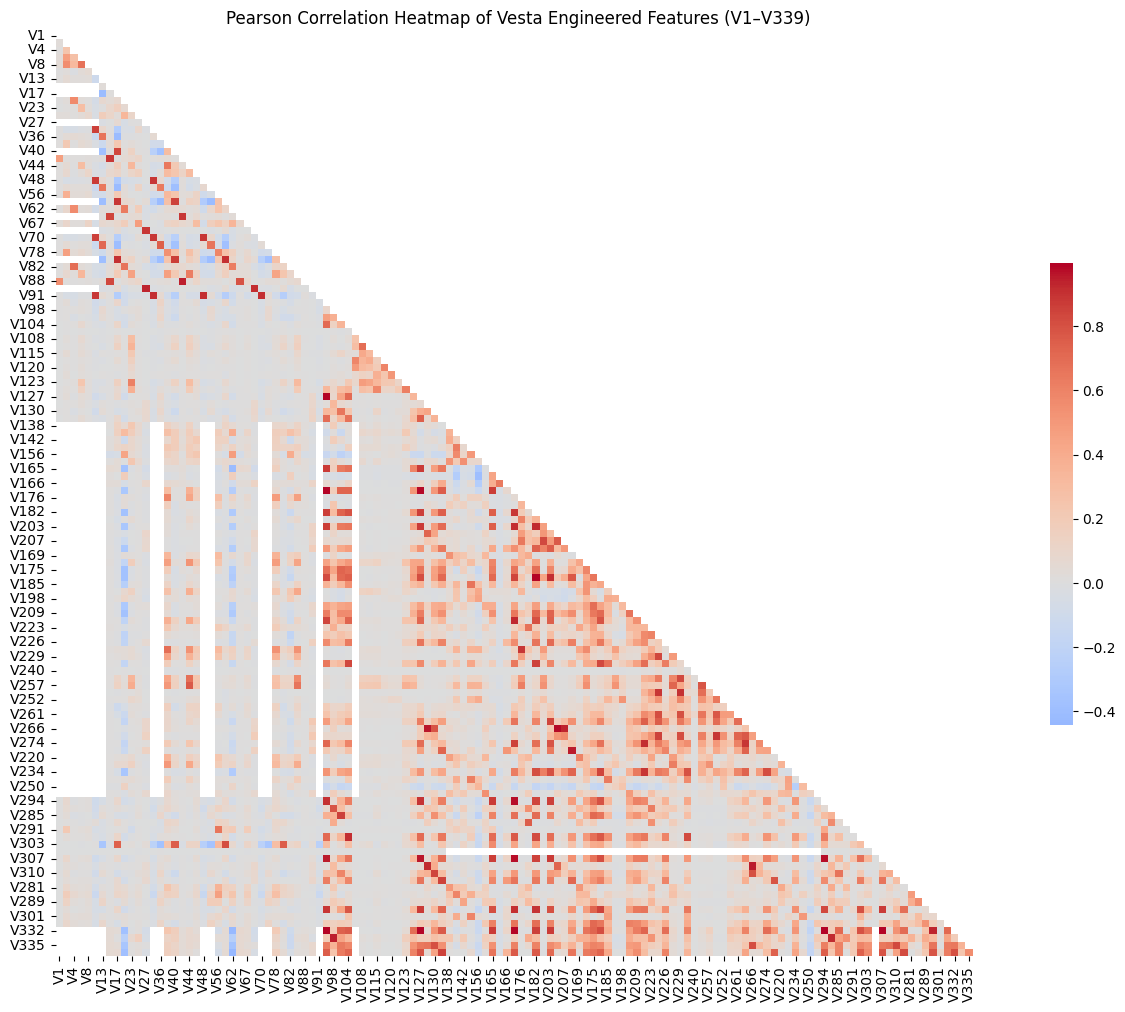

In [6]:
# Compute Pearson and Spearman correlation matrices
pearson_corr = v_data.corr(method='pearson')

# Plot Pearson correlation heatmap (show only lower triangle for clarity)
plt.figure(figsize=(18, 12))
mask = np.triu(np.ones_like(pearson_corr, dtype=bool))
sns.heatmap(pearson_corr, mask=mask, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': .5}, linewidths=0)
plt.title('Pearson Correlation Heatmap of Vesta Engineered Features (V1–V339)')
plt.show()

In [10]:
# pca on V features
v_data_clean = v_data.dropna(axis=1, how='all')  # Drop columns that are all NaN
#fill NaNs with mean of each column for PCA
v_data_clean = v_data_clean.fillna(1)

In [14]:
explained_variances = []
n_components_list = [128, 100, 50, 40, 30, 25, 20, 15, 13, 12, 11, 10, 5, 2, 1]
# try from 200 to 10 components to see explained variance ratio
for n_components in n_components_list:
    pca = PCA(n_components=n_components)
    pca.fit(v_data_clean)  # Fill NaNs with 0 for PCA
    e_var = np.sum(pca.explained_variance_ratio_)
    explained_variances.append(e_var)
    print(f'Number of components: {n_components}, Explained variance ratio: {e_var:.4f}')

Number of components: 128, Explained variance ratio: 1.0000
Number of components: 100, Explained variance ratio: 1.0000
Number of components: 50, Explained variance ratio: 1.0000
Number of components: 40, Explained variance ratio: 1.0000
Number of components: 30, Explained variance ratio: 1.0000
Number of components: 25, Explained variance ratio: 1.0000
Number of components: 20, Explained variance ratio: 1.0000
Number of components: 15, Explained variance ratio: 1.0000
Number of components: 13, Explained variance ratio: 1.0000
Number of components: 12, Explained variance ratio: 0.9999
Number of components: 11, Explained variance ratio: 0.9999
Number of components: 10, Explained variance ratio: 0.9999
Number of components: 5, Explained variance ratio: 0.9996
Number of components: 2, Explained variance ratio: 0.9973
Number of components: 1, Explained variance ratio: 0.9729


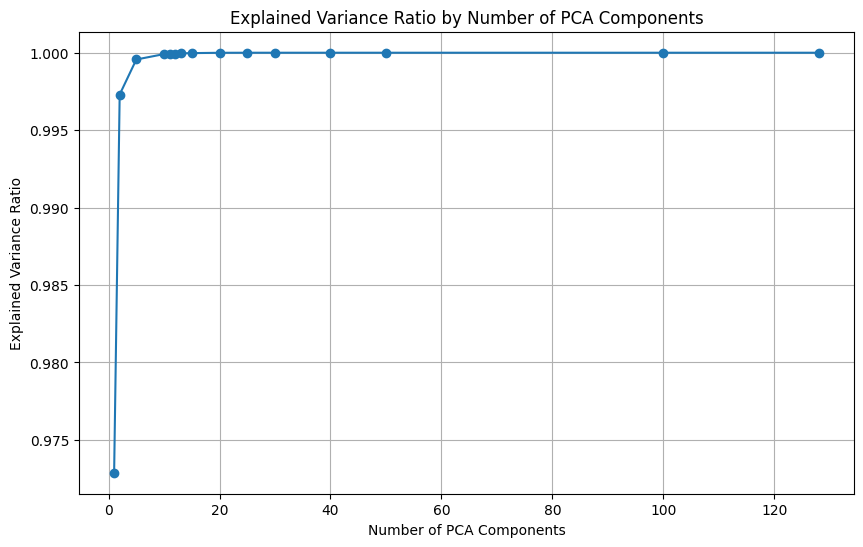

In [15]:
# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(n_components_list, explained_variances, marker='o')
plt.title('Explained Variance Ratio by Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

13 components still achieve 100% explained variance.

### 8.1 v features clustering

In [ ]:
# print("\n=== V-FEATURE CLUSTERING & GROUP-BASED PCA ===")

# # Standardize the data for clustering
# scaler = StandardScaler()
# v_data_scaled = scaler.fit_transform(v_data_clean)
# v_data_scaled_df = pd.DataFrame(v_data_scaled, columns=v_features)


=== V-FEATURE CLUSTERING & GROUP-BASED PCA ===



=== KMEANS CLUSTERING OF V-FEATURES ===
Candidate k: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Silhouette scores: [0.344 0.364 0.349 0.314 0.301 0.293 0.322 0.331 0.321 0.32  0.312 0.346
 0.339]


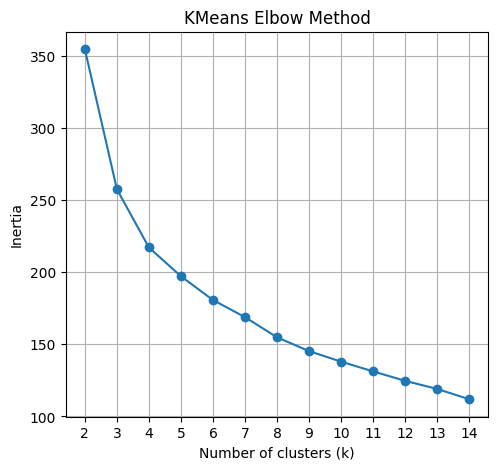

In [ ]:
# # 8. KMeans Clustering of V-Features (feature-wise) and Group PCA
# print("\n=== KMEANS CLUSTERING OF V-FEATURES ===")

# # Use absolute correlation profiles as feature descriptors (cluster features, not rows)
# # Each V-feature is represented by its absolute correlation vector to all V-features
# v_corr_matrix = v_data_scaled_df.corr().abs()
# feature_profiles = v_corr_matrix.values  # shape: (n_features, n_features)

# # Dimensionality reduction for stability before KMeans
# profile_pca_components = min(50, feature_profiles.shape[1]-1) if feature_profiles.shape[1] > 2 else feature_profiles.shape[1]
# profile_pca = PCA(n_components=profile_pca_components, random_state=42)
# feature_profiles_reduced = profile_pca.fit_transform(feature_profiles)

# # Choose k via silhouette score
# candidate_k = list(range(2, 15))
# sil_scores = []
# inertias = []
# for k in candidate_k:
#     km = KMeans(n_clusters=k, random_state=42, n_init=10)
#     labels_tmp = km.fit_predict(feature_profiles_reduced)
#     inertias.append(km.inertia_)
#     try:
#         sil = silhouette_score(feature_profiles_reduced, labels_tmp)
#     except Exception:
#         sil = np.nan
#     sil_scores.append(sil)


# #plot elbow with inertias
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(candidate_k, inertias, marker='o')
# plt.title('KMeans Elbow Method')
# plt.xlabel('Number of clusters (k)')
# plt.ylabel('Inertia')
# plt.xticks(candidate_k)
# plt.grid()
# #plot silhouette 
# print(f"Candidate k: {candidate_k}")
# print(f"Silhouette scores: {np.round(sil_scores, 3)}")


In [ ]:
# best_k = 1


KMeans V-feature groups:
KM_Group_1: 128 features -> ['V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14']...


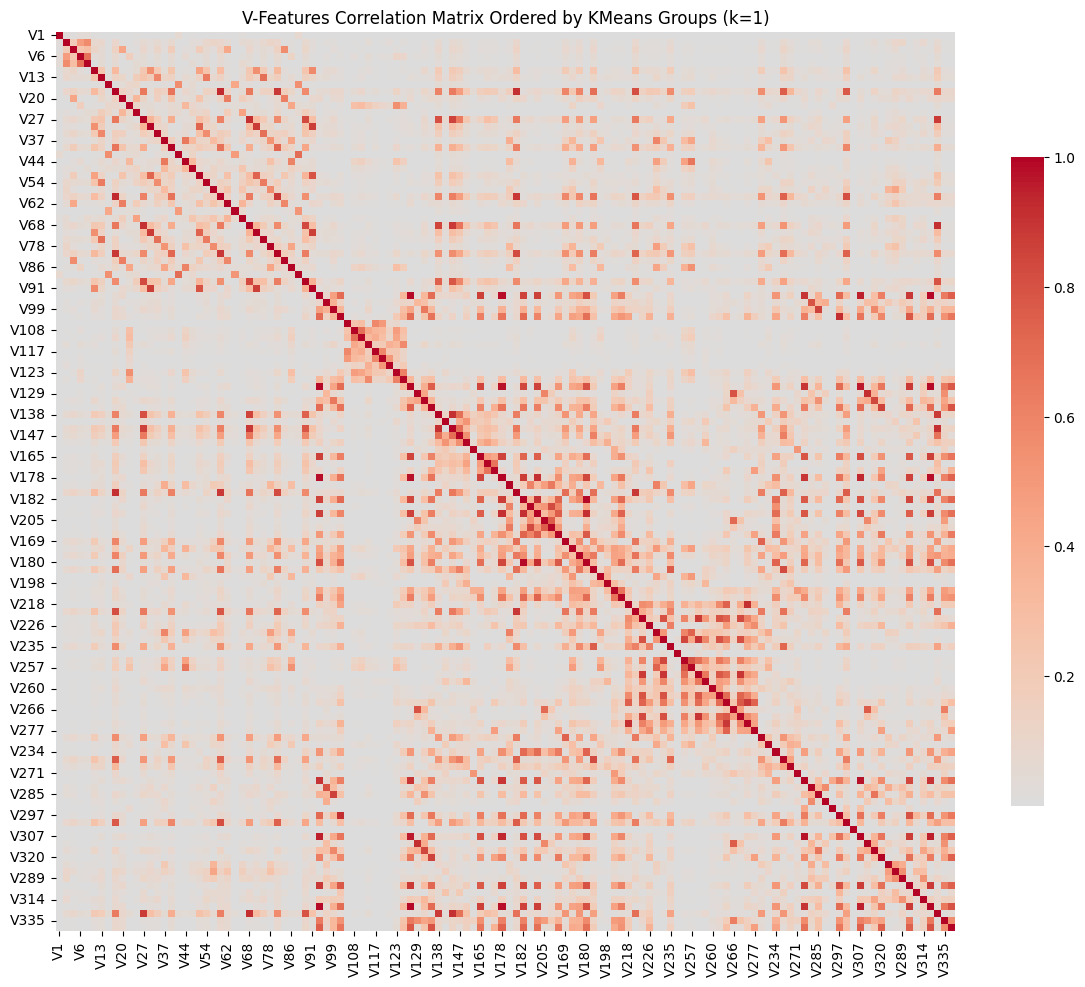


=== PCA PER KMEANS GROUP ===
KM_Group_1: features=128, n90=50, n95=69, using=69, var@using=0.951

Top 10 KMeans PCA components by correlation with fraud:
KM_Group_1_PC4     0.209086
KM_Group_1_PC3     0.197990
KM_Group_1_PC6     0.100366
KM_Group_1_PC2     0.079233
KM_Group_1_PC15    0.068496
KM_Group_1_PC23    0.068052
KM_Group_1_PC7     0.054526
KM_Group_1_PC33    0.054417
KM_Group_1_PC25    0.053640
KM_Group_1_PC12    0.053126


In [ ]:
# # Fit final KMeans
# kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
# km_labels = kmeans.fit_predict(feature_profiles_reduced)

# # Build groups
# v_groups_km = {}
# for g in range(best_k):
#     feats = [v_features[i] for i in range(len(v_features)) if km_labels[i] == g]
#     v_groups_km[f'KM_Group_{g+1}'] = feats

# print("\nKMeans V-feature groups:")
# for gname, feats in v_groups_km.items():
#     print(f"{gname}: {len(feats)} features -> {feats[:8]}{'...' if len(feats) > 8 else ''}")

# # Visualize correlation matrix ordered by KMeans groups
# order_idx = []
# for g in range(best_k):
#     idxs = [i for i, lab in enumerate(km_labels) if lab == g]
#     order_idx.extend(idxs)

# v_corr_km_ordered = v_corr_matrix.iloc[order_idx, order_idx]
# plt.figure(figsize=(12, 10))
# sns.heatmap(v_corr_km_ordered, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': .7})
# plt.title(f'V-Features Correlation Matrix Ordered by KMeans Groups (k={best_k})')
# plt.tight_layout()
# plt.show()

# # PCA per KMeans group (mirrors earlier group-based PCA)
# print("\n=== PCA PER KMEANS GROUP ===")
# km_pca_results = {}
# km_group_components = {}

# for gname, feats in v_groups_km.items():
#     if len(feats) < 2:
#         print(f"Skipping {gname} (only {len(feats)} feature)")
#         continue
#     data_g = v_data_clean[feats]
#     scaler_g = StandardScaler()
#     Xg = scaler_g.fit_transform(data_g)
#     pca_g = PCA()
#     pca_g.fit(Xg)
#     evr = pca_g.explained_variance_ratio_
#     cum = np.cumsum(evr)
#     n90 = np.argmax(cum >= 0.90) + 1
#     n95 = np.argmax(cum >= 0.95) + 1
#     n_opt = min(n95, len(feats)-1)
#     km_pca_results[gname] = {'pca': pca_g, 'scaler': scaler_g, 'evr': evr, 'cum': cum, 'n90': n90, 'n95': n95, 'features': feats}
#     comp = PCA(n_components=n_opt).fit(Xg).transform(Xg)
#     km_group_components[gname] = comp
#     print(f"{gname}: features={len(feats)}, n90={n90}, n95={n95}, using={n_opt}, var@using={cum[n_opt-1]:.3f}")

# # Rank KM PCA components by correlation with fraud
# if len(km_group_components) > 0:
#     km_combined = []
#     km_names = []
#     for gname, comp in km_group_components.items():
#         for i in range(comp.shape[1]):
#             km_combined.append(comp[:, i])
#             km_names.append(f'{gname}_PC{i+1}')
#     km_df = pd.DataFrame(np.column_stack(km_combined), columns=km_names, index=train.index)
#     km_corr = km_df.corrwith(train['isFraud']).abs().sort_values(ascending=False)
#     print("\nTop 10 KMeans PCA components by correlation with fraud:")
#     print(km_corr.head(10).to_string())


In [ ]:
# print("\n=== PLOTTING SHELL FOR V-FEATURE ANALYSIS ===")

# def plot_clustering_metrics(candidate_k, sil_scores, inertias, title_suffix=""):
#     """Plot silhouette scores and inertias for clustering evaluation"""
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
#     # Silhouette scores
#     ax1.plot(candidate_k, sil_scores, 'bo-', linewidth=2, markersize=8)
#     ax1.set_xlabel('Number of Clusters (k)')
#     ax1.set_ylabel('Silhouette Score')
#     ax1.set_title(f'Silhouette Score vs k {title_suffix}')
#     ax1.grid(True, alpha=0.3)
#     ax1.axvline(x=candidate_k[np.nanargmax(sil_scores)], color='red', linestyle='--', alpha=0.7, label='Best k')
#     ax1.legend()
    
#     # Elbow curve
#     ax2.plot(candidate_k, inertias, 'ro-', linewidth=2, markersize=8)
#     ax2.set_xlabel('Number of Clusters (k)')
#     ax2.set_ylabel('Inertia (Within-cluster Sum of Squares)')
#     ax2.set_title(f'Elbow Curve {title_suffix}')
#     ax2.grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.show()

# def plot_correlation_matrix_clustered(corr_matrix, labels, feature_names, title="Clustered Correlation Matrix", figsize=(12, 10)):
#     """Plot correlation matrix ordered by cluster labels"""
#     # Create ordering by clusters
#     order_idx = []
#     unique_labels = np.unique(labels)
#     for label in unique_labels:
#         idxs = [i for i, lab in enumerate(labels) if lab == label]
#         order_idx.extend(idxs)
    
#     # Reorder correlation matrix
#     corr_ordered = corr_matrix.iloc[order_idx, order_idx]
    
#     plt.figure(figsize=figsize)
#     sns.heatmap(corr_ordered, cmap='coolwarm', center=0, square=True, 
#                 cbar_kws={'shrink': 0.7}, xticklabels=False, yticklabels=False)
#     plt.title(title)
    
#     # Add cluster boundaries
#     cluster_boundaries = []
#     current_pos = 0
#     for label in unique_labels:
#         count = np.sum(labels == label)
#         current_pos += count
#         cluster_boundaries.append(current_pos)
    
#     for boundary in cluster_boundaries[:-1]:
#         plt.axhline(y=boundary, color='black', linewidth=2)
#         plt.axvline(x=boundary, color='black', linewidth=2)
    
#     plt.tight_layout()
#     plt.show()

# def plot_pca_variance_by_group(pca_results, title_suffix=""):
#     """Plot explained variance for each group's PCA"""
#     n_groups = len(pca_results)
#     if n_groups == 0:
#         print("No PCA results to plot")
#         return
    
#     fig, axes = plt.subplots(2, n_groups, figsize=(5*n_groups, 10))
#     if n_groups == 1:
#         axes = axes.reshape(2, 1)
    
#     for i, (group_name, results) in enumerate(pca_results.items()):
#         evr = results['evr']
#         cum_var = results['cum']
        
#         # Individual and cumulative variance
#         axes[0, i].plot(range(1, len(evr) + 1), evr, 'bo-', label='Individual', alpha=0.7)
#         axes[0, i].plot(range(1, len(cum_var) + 1), cum_var, 'ro-', label='Cumulative', linewidth=2)
#         axes[0, i].axhline(y=0.95, color='g', linestyle='--', alpha=0.7, label='95% threshold')
#         axes[0, i].axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
#         axes[0, i].set_xlabel('Number of Components')
#         axes[0, i].set_ylabel('Explained Variance Ratio')
#         axes[0, i].set_title(f'{group_name} - Explained Variance {title_suffix}')
#         axes[0, i].legend()
#         axes[0, i].grid(True, alpha=0.3)
        
#         # Component importance (first 10)
#         n_show = min(10, len(evr))
#         axes[1, i].bar(range(1, n_show + 1), evr[:n_show], alpha=0.7, color='skyblue')
#         axes[1, i].set_xlabel('Component Number')
#         axes[1, i].set_ylabel('Explained Variance Ratio')
#         axes[1, i].set_title(f'{group_name} - First {n_show} Components')
#         axes[1, i].grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.show()

# def plot_group_comparison(group_results_dict, comparison_type="size"):
#     """Compare different grouping methods"""
#     methods = list(group_results_dict.keys())
    
#     if comparison_type == "size":
#         sizes = [len(features) for features in group_results_dict.values()]
#         plt.figure(figsize=(10, 6))
#         bars = plt.bar(methods, sizes, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen'])
#         plt.ylabel('Number of Features')
#         plt.title('Group Size Comparison')
#         plt.xticks(rotation=45)
        
#         # Add value labels on bars
#         for bar, size in zip(bars, sizes):
#             plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
#                     str(size), ha='center', va='bottom')
#         plt.tight_layout()
#         plt.show()
    
#     elif comparison_type == "pca_components":
#         # Compare PCA components across methods
#         fig, ax = plt.subplots(figsize=(12, 6))
#         x_pos = np.arange(len(methods))
#         component_counts = []
        
#         for method, results in group_results_dict.items():
#             if isinstance(results, dict) and 'pca_results' in results:
#                 total_components = sum([len(comp[0]) for comp in results['pca_results'].values()])
#                 component_counts.append(total_components)
#             else:
#                 component_counts.append(0)
        
#         bars = ax.bar(x_pos, component_counts, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen'])
#         ax.set_xlabel('Clustering Method')
#         ax.set_ylabel('Total PCA Components')
#         ax.set_title('PCA Components Comparison')
#         ax.set_xticks(x_pos)
#         ax.set_xticklabels(methods, rotation=45)
        
#         # Add value labels
#         for bar, count in zip(bars, component_counts):
#             ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
#                    str(count), ha='center', va='bottom')
#         plt.tight_layout()
#         plt.show()

# def plot_fraud_correlation_ranking(correlation_series, title="Top Features by Fraud Correlation", top_n=20):
#     """Plot top N features by correlation with fraud"""
#     top_features = correlation_series.head(top_n)
    
#     plt.figure(figsize=(12, 8))
#     bars = plt.barh(range(len(top_features)), top_features.values, alpha=0.7, color='steelblue')
#     plt.yticks(range(len(top_features)), top_features.index)
#     plt.xlabel('Absolute Correlation with Fraud')
#     plt.title(f'{title} (Top {top_n})')
#     plt.grid(True, alpha=0.3, axis='x')
    
#     # Add value labels
#     for i, (bar, value) in enumerate(zip(bars, top_features.values)):
#         plt.text(value + 0.001, bar.get_y() + bar.get_height()/2, 
#                 f'{value:.3f}', va='center', ha='left', fontsize=8)
    
#     plt.tight_layout()
#     plt.show()

# def plot_group_statistics(group_dict, stat_type="correlation"):
#     """Plot statistics for each group"""
#     if stat_type == "correlation":
#         group_stats = []
#         for group_name, features in group_dict.items():
#             if len(features) > 1:
#                 group_corr = v_corr_matrix.loc[features, features]
#                 avg_corr = group_corr.values[np.triu_indices_from(group_corr.values, k=1)].mean()
#                 group_stats.append({
#                     'Group': group_name,
#                     'Size': len(features),
#                     'Avg_Correlation': avg_corr
#                 })
        
#         if group_stats:
#             df_stats = pd.DataFrame(group_stats)
            
#             fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
#             # Group sizes
#             ax1.bar(df_stats['Group'], df_stats['Size'], alpha=0.7, color='lightblue')
#             ax1.set_ylabel('Number of Features')
#             ax1.set_title('Group Sizes')
#             ax1.tick_params(axis='x', rotation=45)
            
#             # Average correlations
#             ax2.bar(df_stats['Group'], df_stats['Avg_Correlation'], alpha=0.7, color='lightcoral')
#             ax2.set_ylabel('Average Within-Group Correlation')
#             ax2.set_title('Average Within-Group Correlations')
#             ax2.tick_params(axis='x', rotation=45)
            
#             # Add value labels
#             for i, (size, corr) in enumerate(zip(df_stats['Size'], df_stats['Avg_Correlation'])):
#                 ax1.text(i, size + 0.5, str(size), ha='center', va='bottom')
#                 ax2.text(i, corr + 0.001, f'{corr:.3f}', ha='center', va='bottom')
            
#             plt.tight_layout()
#             plt.show()


=== PLOTTING SHELL FOR V-FEATURE ANALYSIS ===


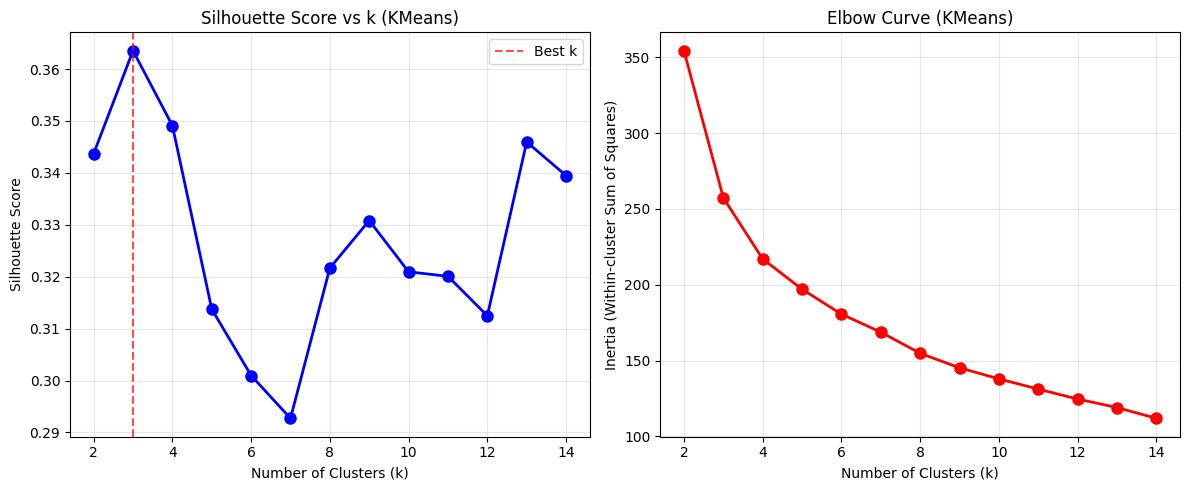

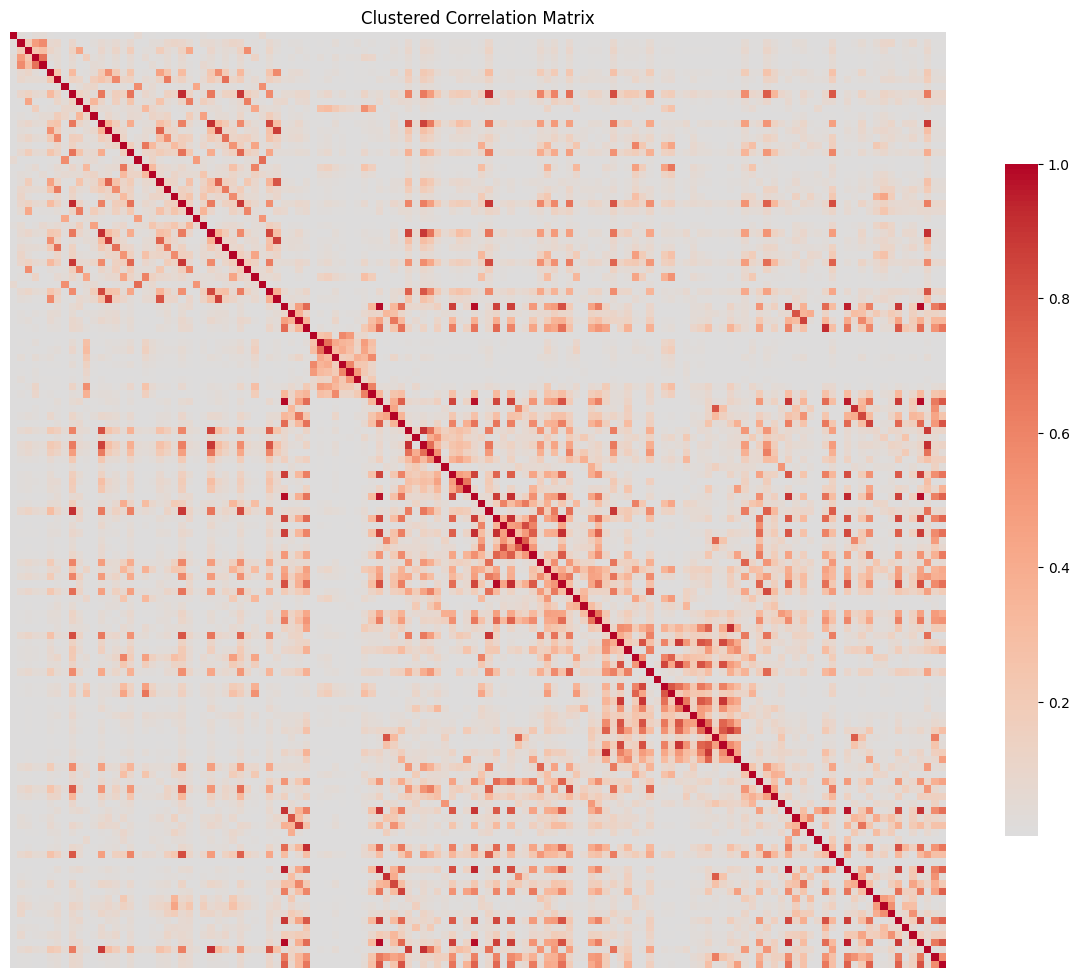

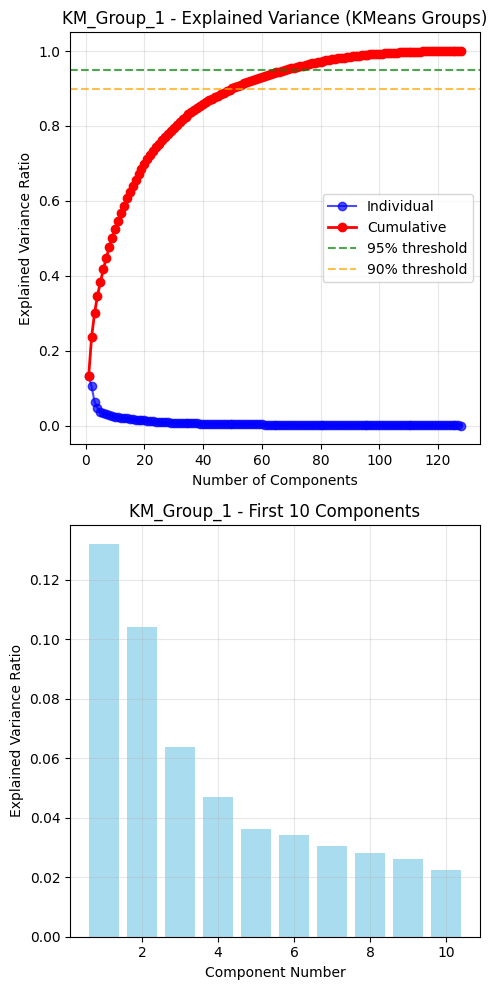

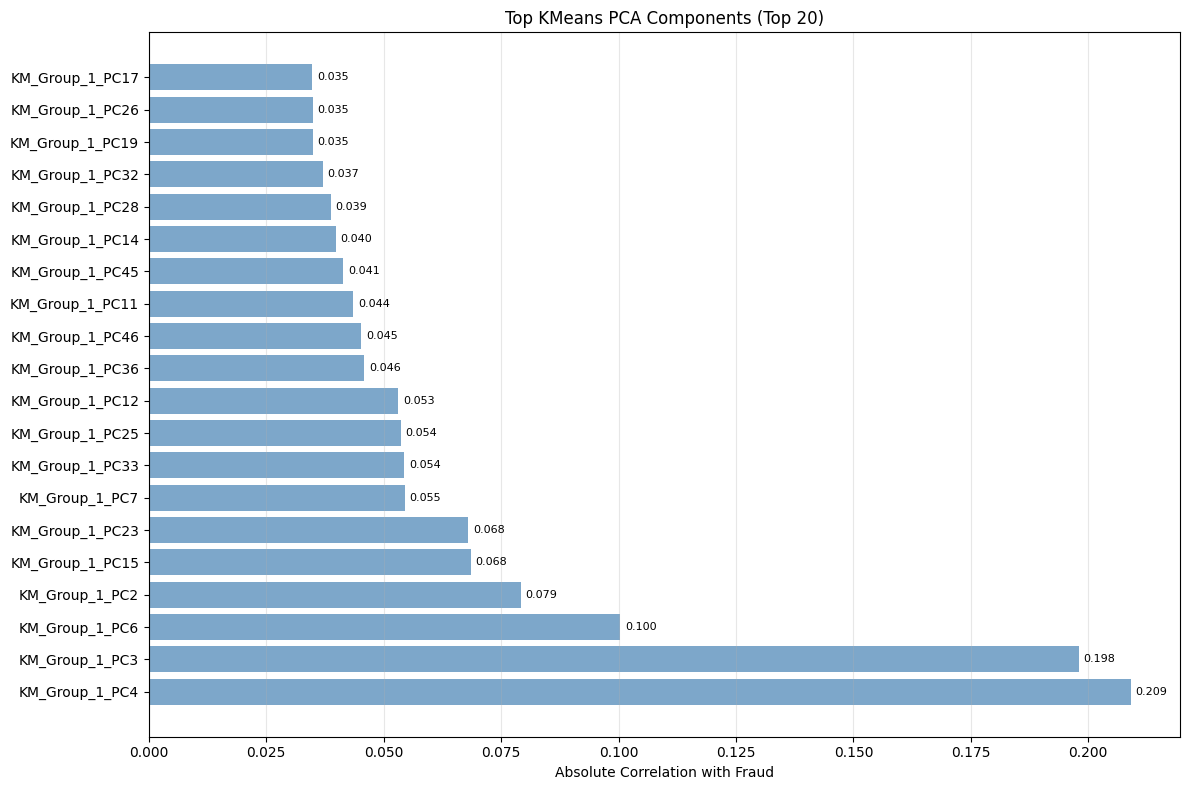

In [ ]:
# # Individual function calls
# plot_clustering_metrics(candidate_k, sil_scores, inertias, "(KMeans)")
# plot_correlation_matrix_clustered(v_corr_matrix, km_labels, v_features)
# plot_pca_variance_by_group(km_pca_results, "(KMeans Groups)")
# plot_fraud_correlation_ranking(km_corr, "Top KMeans PCA Components")


## 9. Identity Features


In [14]:
train_identity.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  ...                id_31  id_32      id_33           id_34  id_35  \
0    NaN  ...  samsung browser 6.2   32.0  2220x1080  match_status:2      T   
1    NaN  ...   mobile safari 11.0   32.0   1334x750  match_status:1      T   
2    0.0  ...          chrome 62.0    NaN        NaN             NaN      F   
3    NaN  ...          chrome 62.0    NaN        NaN             NaN      F   
4    0.0  ...          chrome 62.0   24.0   1280x800  match_status:2      T   

  id_36 id_37  id_38  DeviceType                     DeviceInfo  
0     F     T      T      mobile  SAMSUNG SM-G892A Build/NRD90M  
1     F     F      T      mobile                     iOS Device  
2     F     T      T     desktop                        Windows  
3     F     T      T     desktop                            NaN  
4     F     T      T     desktop                          MacOS  

[5 rows x 41 columns]

In [15]:
# ---------------------------
# Basic Overview
# ---------------------------
print("Shape of dataset:", train_identity.shape)
print("\nColumns:", train_identity.columns.tolist())
print("\nInfo:")
train_identity.info()

Shape of dataset: (144233, 41)

Columns: ['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8 


Missing Values (%):
 id_24            96.708798
id_25            96.441868
id_07            96.425922
id_08            96.425922
id_21            96.423149
id_26            96.420375
id_23            96.416215
id_27            96.416215
id_22            96.416215
id_18            68.722137
id_04            54.016071
id_03            54.016071
id_33            49.187079
id_10            48.052110
id_09            48.052110
id_30            46.222432
id_32            46.207872
id_34            46.056034
id_14            44.503685
DeviceInfo       17.726179
id_13            11.726165
id_16            10.325654
id_06             5.108401
id_05             5.108401
id_20             3.447200
id_19             3.407681
id_17             3.372321
id_31             2.739318
DeviceType        2.373243
id_02             2.330257
id_28             2.256765
id_29             2.256765
id_11             2.256765
id_38             2.251912
id_35             2.251912
id_36             2.251912
id_15 

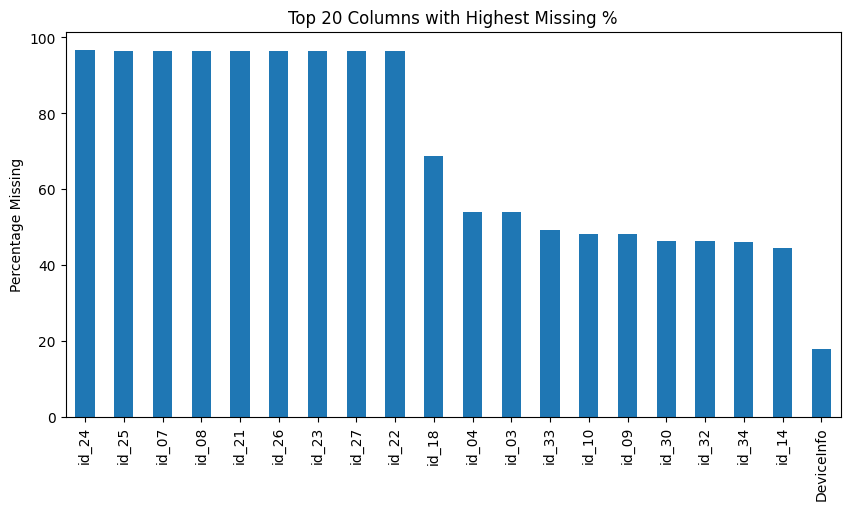

In [16]:
# ---------------------------
# Missing Values
# ---------------------------
missing = train_identity.isnull().mean().sort_values(ascending=False) * 100
print("\nMissing Values (%):\n", missing)

plt.figure(figsize=(10,5))
missing.head(20).plot(kind="bar")
plt.title("Top 20 Columns with Highest Missing %")
plt.ylabel("Percentage Missing")
plt.show()

In [17]:
# ---------------------------
# Descriptive Statistics
# ---------------------------
print("\nDescriptive Statistics:")
display(train_identity.fillna(-1).describe(include="all").transpose())


Descriptive Statistics:


count unique          top      freq            mean  \
TransactionID  144233.0    NaN          NaN       NaN  3236329.311288   
id_01          144233.0    NaN          NaN       NaN      -10.170502   
id_02          144233.0    NaN          NaN       NaN    170645.21545   
id_03          144233.0    NaN          NaN       NaN       -0.512483   
id_04          144233.0    NaN          NaN       NaN       -0.567263   
id_05          144233.0    NaN          NaN       NaN         1.48197   
id_06          144233.0    NaN          NaN       NaN       -6.407597   
id_07          144233.0    NaN          NaN       NaN        -0.48943   
id_08          144233.0    NaN          NaN       NaN       -2.343867   
id_09          144233.0    NaN          NaN       NaN       -0.433236   
id_10          144233.0    NaN          NaN       NaN       -0.636949   
id_11          144233.0    NaN          NaN       NaN       97.471739   
id_12            144233      2     NotFound    123025             NaN   
id_13          144233.0    NaN          NaN       NaN       42.301027   
id_14          144233.0    NaN          NaN       NaN     -191.633808   
id_15            144233      4        Found     67728             NaN   
id_16            144233      3        Found     66324             NaN   
id_17          144233.0    NaN          NaN       NaN      183.028745   
id_18          144233.0    NaN          NaN       NaN        3.765913   
id_19          144233.0    NaN          NaN       NaN      341.060617   
id_20          144233.0    NaN          NaN       NaN      389.925551   
id_21          144233.0    NaN          NaN       NaN       12.208233   
id_22          144233.0    NaN          NaN       NaN        -0.39066   
id_23          144233.0    4.0         -1.0  139064.0             NaN   
id_24          144233.0    NaN          NaN       NaN       -0.545784   
id_25          144233.0    NaN          NaN       NaN       10.763501   
id_26          144233.0    NaN          NaN       NaN        4.371954   
id_27          144233.0    3.0         -1.0  139064.0             NaN   
id_28            144233      3        Found     76232             NaN   
id_29            144233      3        Found     74926             NaN   
id_30          144233.0   76.0         -1.0   66668.0             NaN   
id_31            144233    131  chrome 63.0     22000             NaN   
id_32          144233.0    NaN          NaN       NaN        13.79746   
id_33          144233.0  261.0         -1.0   70944.0             NaN   
id_34          144233.0    5.0         -1.0   66428.0             NaN   
id_35            144233      3            T     77814             NaN   
id_36            144233      3            F    134066             NaN   
id_37            144233      3            T    110452             NaN   
id_38            144233      3            F     73922             NaN   
DeviceType       144233      3      desktop     85165             NaN   
DeviceInfo       144233   1787      Windows     47722             NaN   

                         std        min        25%        50%        75%  \
TransactionID  178849.571186  2987004.0  3077142.0  3198818.0  3392923.0   
id_01              14.347949     -100.0      -10.0       -5.0       -5.0   
id_02           159967.23017       -1.0    64159.0   122552.0   225093.0   
id_03                0.66615      -13.0       -1.0       -1.0        0.0   
id_04               0.667792      -28.0       -1.0       -1.0        0.0   
id_05               5.146328      -72.0        0.0        0.0        1.0   
id_06              16.113287     -100.0       -5.0        0.0        0.0   
id_07               3.415286      -46.0       -1.0       -1.0       -1.0   
id_08               8.546259     -100.0       -1.0       -1.0       -1.0   
id_09               0.894403      -36.0       -1.0        0.0        0.0   
id_10                2.04058     -100.0       -1.0        0.0        0.0   
id_11              15.004274       -1.0

In [42]:
# ---------------------------
# Separate Numerical & Categorical Features
# ---------------------------
num_cols = train_identity.select_dtypes(include=["int64", "float64"]).columns
cat_cols = train_identity.select_dtypes(include=["object"]).columns

print(f"\nNumerical columns ({len(num_cols)}): {num_cols.tolist()}")
print(f"Categorical columns ({len(cat_cols)}): {cat_cols.tolist()}")


Numerical columns (24): ['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_32']
Categorical columns (17): ['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


In [43]:
for c in cat_cols: print (c,train_identity[c].unique()[:10])

id_12 ['NotFound' 'Found']
id_15 ['New' 'Found' nan 'Unknown']
id_16 ['NotFound' 'Found' nan]
id_23 [nan 'IP_PROXY:TRANSPARENT' 'IP_PROXY:ANONYMOUS' 'IP_PROXY:HIDDEN']
id_27 [nan 'Found' 'NotFound']
id_28 ['New' 'Found' nan]
id_29 ['NotFound' 'Found' nan]
id_30 ['Android 7.0' 'iOS 11.1.2' nan 'Mac OS X 10_11_6' 'Windows 10' 'Android'
 'Linux' 'iOS 11.0.3' 'Mac OS X 10_7_5' 'Mac OS X 10_12_6']
id_31 ['samsung browser 6.2' 'mobile safari 11.0' 'chrome 62.0' nan
 'chrome 62.0 for android' 'edge 15.0' 'mobile safari generic'
 'chrome 49.0' 'chrome 61.0' 'edge 16.0']
id_33 ['2220x1080' '1334x750' nan '1280x800' '1366x768' '1920x1080' '1680x1050'
 '1136x640' '5120x2880' '2880x1800']
id_34 ['match_status:2' 'match_status:1' nan 'match_status:0' 'match_status:-1']
id_35 ['T' 'F' nan]
id_36 ['F' nan 'T']
id_37 ['T' 'F' nan]
id_38 ['T' nan 'F']
DeviceType ['mobile' 'desktop' nan]
DeviceInfo ['SAMSUNG SM-G892A Build/NRD90M' 'iOS Device' 'Windows' nan 'MacOS'
 'SM-G930V Build/NRD90M' 'BLADE A602 B

We see boolean (True False / Found - Not Found) -> encode

In [11]:
mp = {'Unknown':-1,'NotFound':0,'Found':1,'New':2,'F':0,'T':1}
boolean = ['id_12','id_15','id_16','id_27','id_28','id_29','id_35','id_36','id_37','id_38']
for c in boolean: 
    train[c] = train[c].map(mp)
    test[c] = test[c].map(mp)

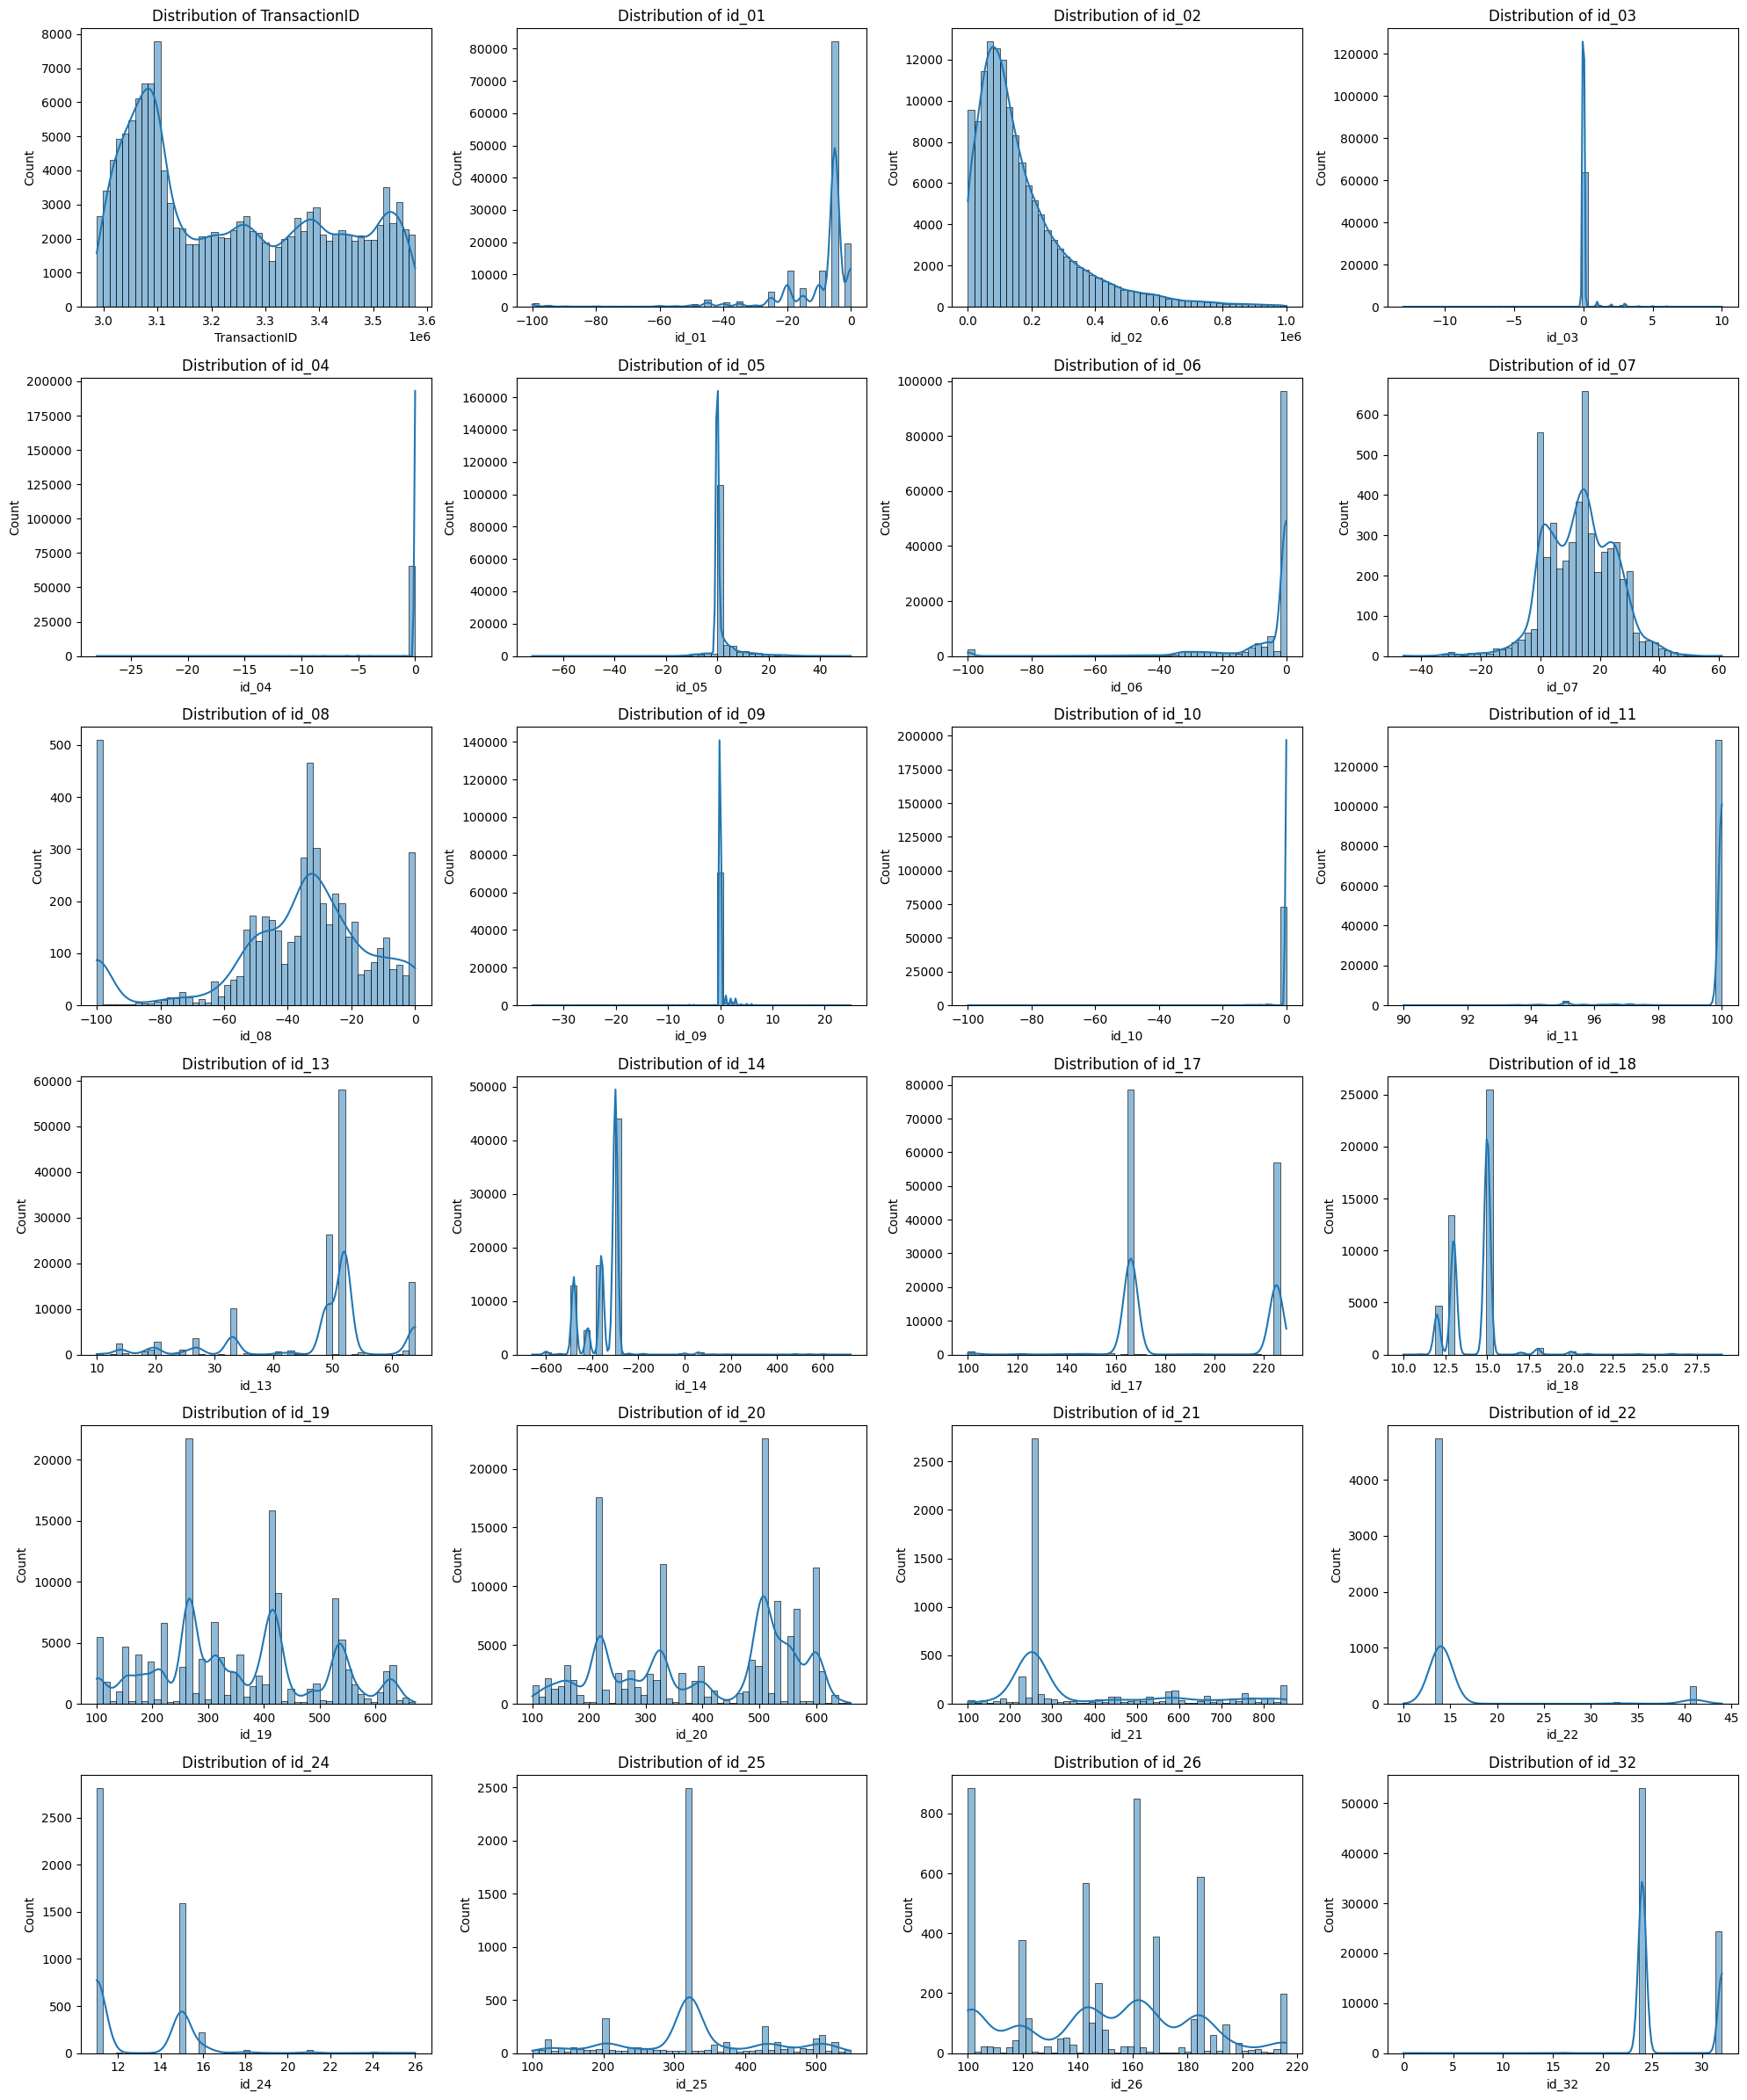

In [45]:
# ---------------------------
# Distribution Plots (Numerical) - 4 per row
# ---------------------------

n_cols = 4
n_rows = math.ceil(len(num_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(train_identity[col].dropna(), kde=True, bins=50, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

# Hide any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Remove empty subplots if any
for idx in range(len(num_cols), len(axes)):
    fig.delaxes(axes[idx])

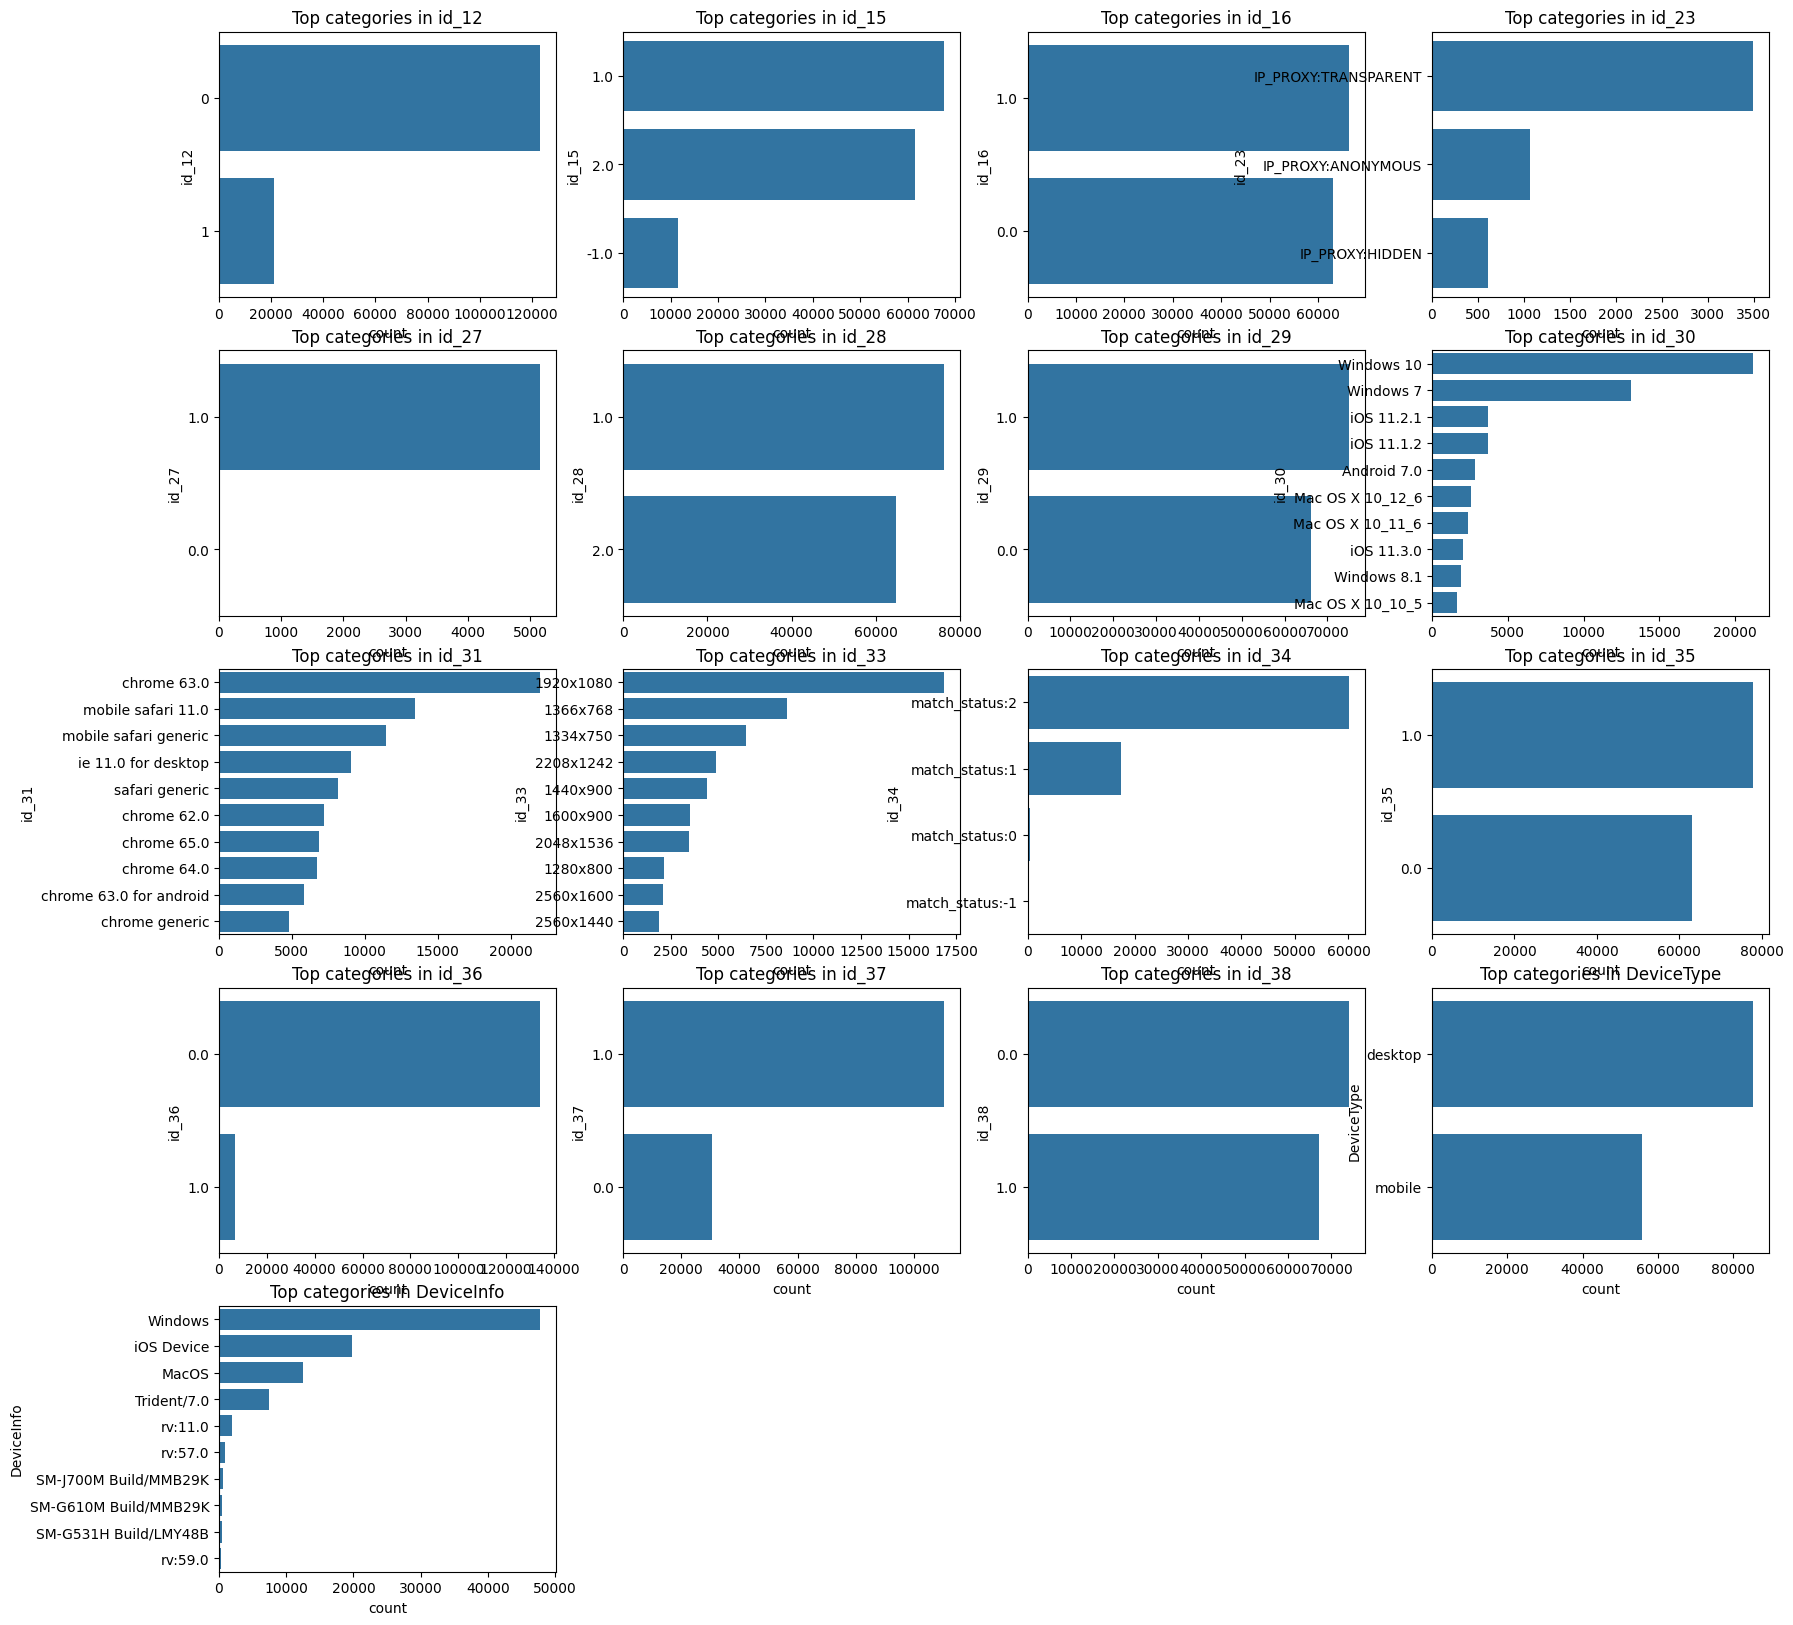

In [46]:
# ---------------------------
# Count Plots (Categorical)
# ---------------------------
n_cols = 4
n_rows = math.ceil(len(cat_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(y=col, data=train_identity, order=train_identity[col].value_counts().index[:10], ax=axes[i])
    axes[i].set_title(f"Top categories in {col}")

# Remove empty subplots if any
for idx in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[idx])

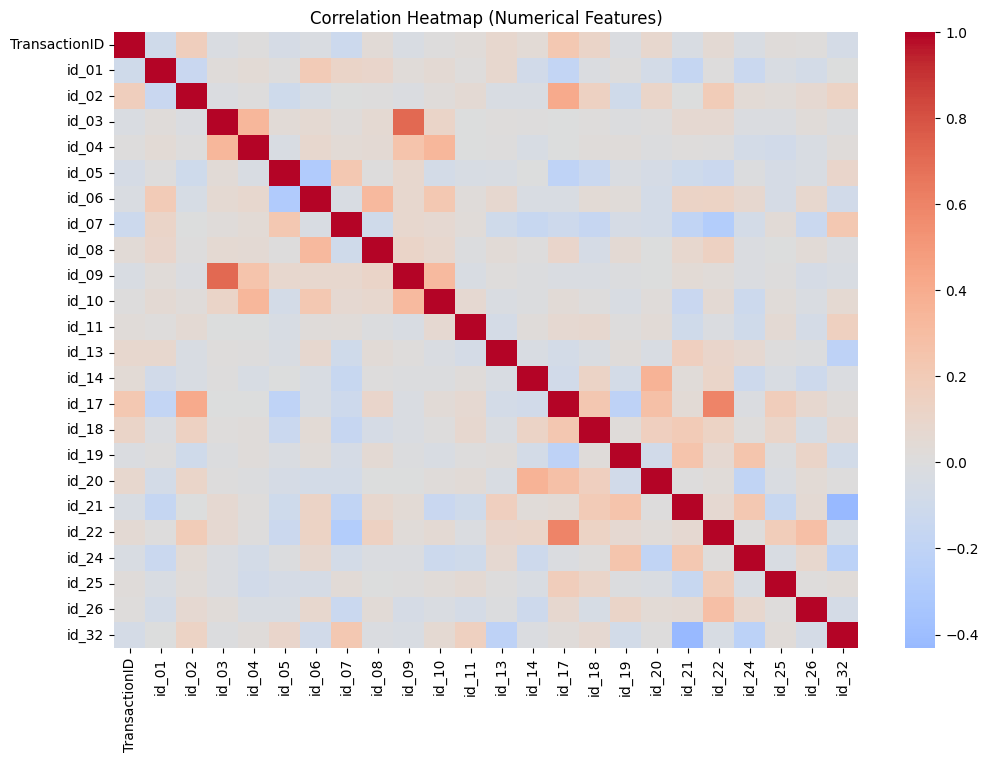

In [21]:
# ---------------------------
# Correlation Analysis
# ---------------------------
plt.figure(figsize=(12,8))
sns.heatmap(train_identity[num_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

## 10. Feature Interactions (EDA Deep Dive)

=== TRANSACTION AMOUNT INTERACTIONS ===


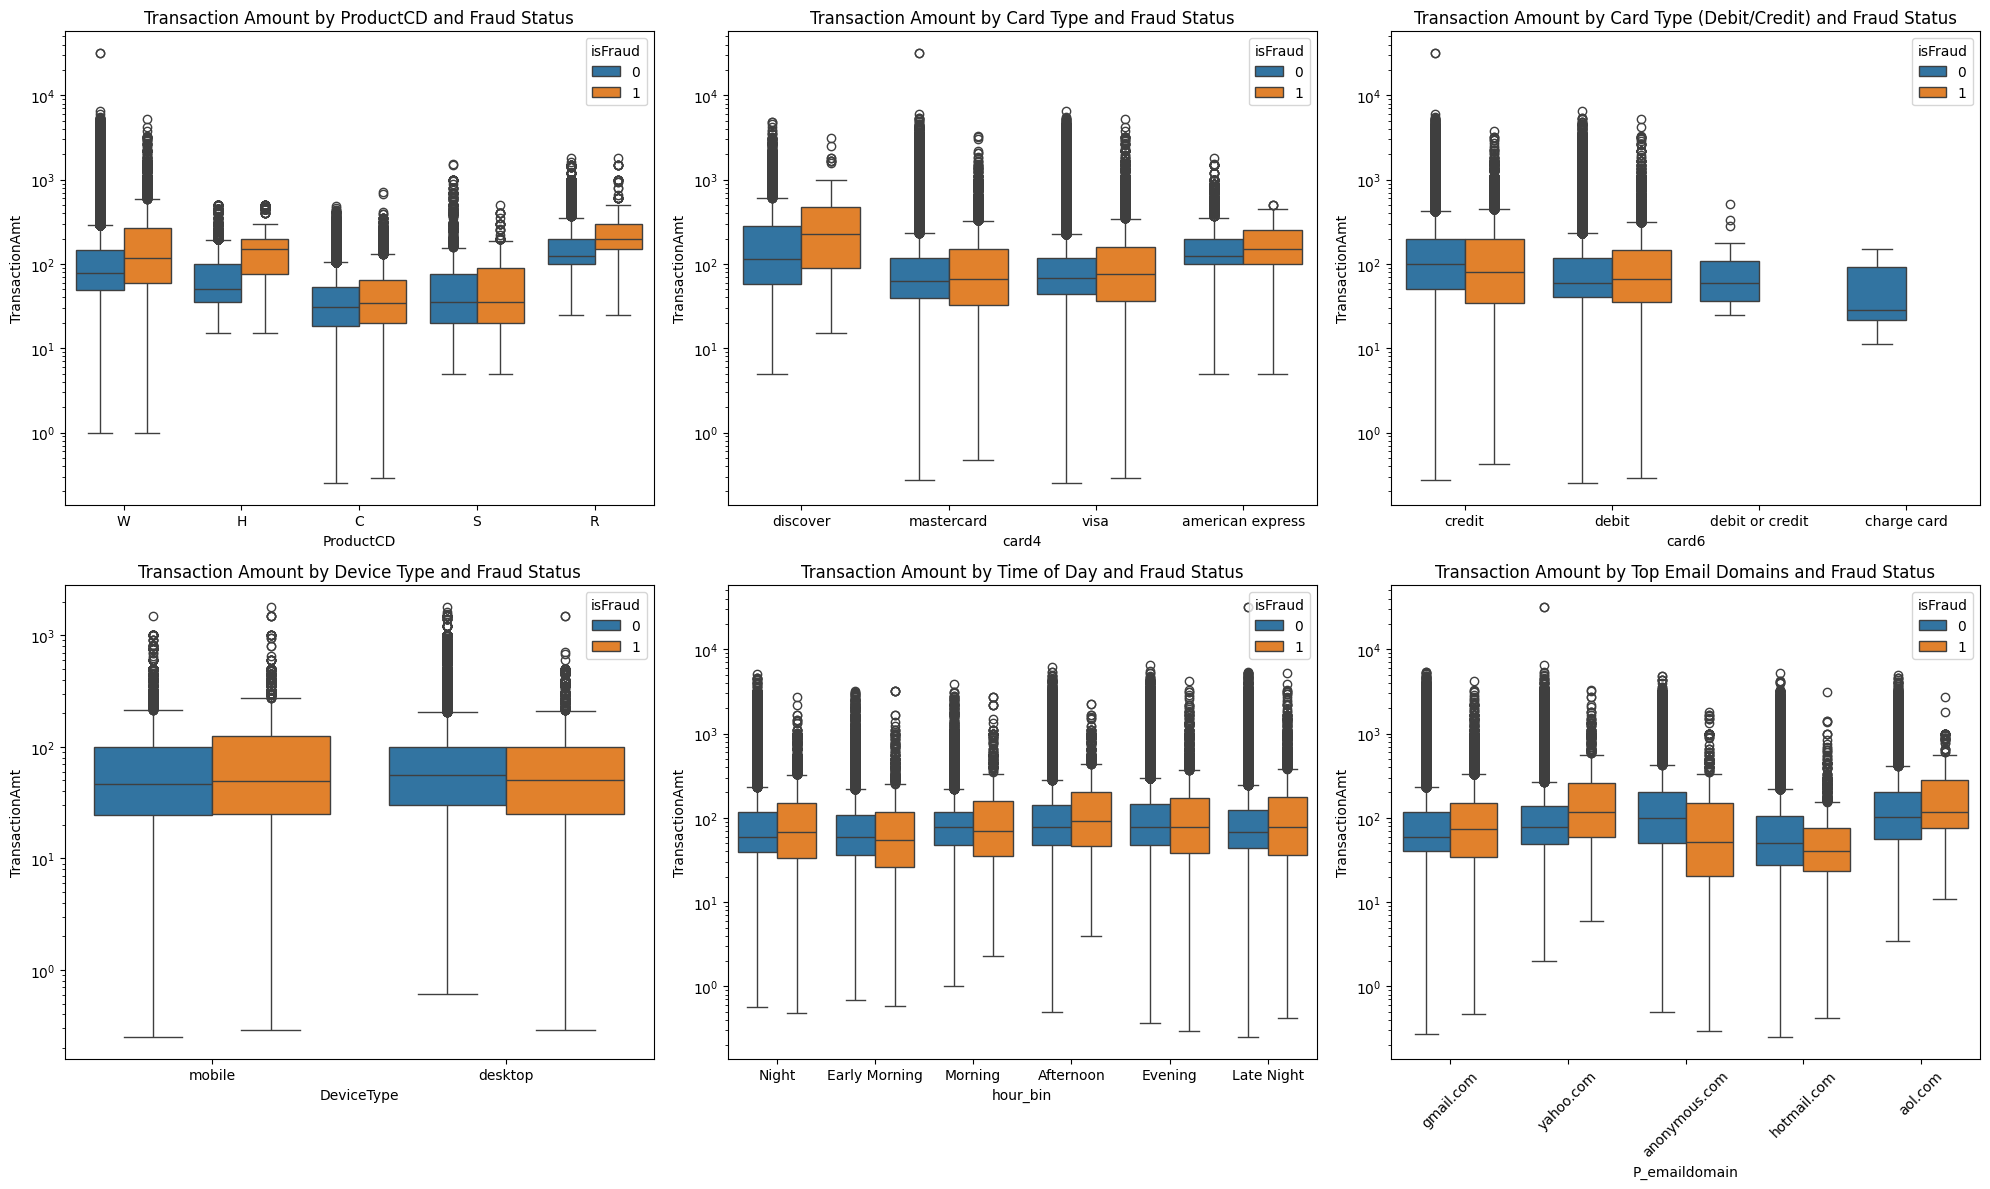


Fraud Rates by Transaction Amount and Categorical Features:
High value threshold: $275.29

ProductCD - High Value Transactions (>$275.29):
           Count  Fraud_Rate
ProductCD                   
H            805       0.395
C            147       0.224
R           4023       0.102
S            217       0.074
W          53861       0.041

card4 - High Value Transactions (>$275.29):
                  Count  Fraud_Rate
card4                              
discover           1783       0.134
visa              37166       0.050
mastercard        18746       0.046
american express   1145       0.036

card6 - High Value Transactions (>$275.29):
        Count  Fraud_Rate
card6                    
credit  25387       0.069
debit   33451       0.037


In [ ]:
# Advanced Feature Interaction Analysis
# 1. Transaction Amount × Categorical Features Interaction
print("=== TRANSACTION AMOUNT INTERACTIONS ===")

# Create interaction plots for amount vs key categoricals
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Amount vs ProductCD
sns.boxplot(data=train, x='ProductCD', y='TransactionAmt', hue='isFraud', ax=axes[0,0])
axes[0,0].set_yscale('log')
axes[0,0].set_title('Transaction Amount by ProductCD and Fraud Status')

# Amount vs Card4 (card type)
sns.boxplot(data=train, x='card4', y='TransactionAmt', hue='isFraud', ax=axes[0,1])
axes[0,1].set_yscale('log')
axes[0,1].set_title('Transaction Amount by Card Type and Fraud Status')

# Amount vs Card6 (debit/credit)
sns.boxplot(data=train, x='card6', y='TransactionAmt', hue='isFraud', ax=axes[0,2])
axes[0,2].set_yscale('log')
axes[0,2].set_title('Transaction Amount by Card Type (Debit/Credit) and Fraud Status')

# Amount vs DeviceType
device_data = train[train['DeviceType'].notna()]
sns.boxplot(data=device_data, x='DeviceType', y='TransactionAmt', hue='isFraud', ax=axes[1,0])
axes[1,0].set_yscale('log')
axes[1,0].set_title('Transaction Amount by Device Type and Fraud Status')

# Amount vs Hour of Day (binned)
train['hour_bin'] = pd.cut(train['hour_of_day'], bins=6, labels=['Night', 'Early Morning', 'Morning', 'Afternoon', 'Evening', 'Late Night'])
sns.boxplot(data=train, x='hour_bin', y='TransactionAmt', hue='isFraud', ax=axes[1,1])
axes[1,1].set_yscale('log')
axes[1,1].set_title('Transaction Amount by Time of Day and Fraud Status')

# Amount vs Email Domain (top 5)
top_email_domains = train['P_emaildomain'].value_counts().head(5).index
email_data = train[train['P_emaildomain'].isin(top_email_domains)]
sns.boxplot(data=email_data, x='P_emaildomain', y='TransactionAmt', hue='isFraud', ax=axes[1,2])
axes[1,2].set_yscale('log')
axes[1,2].set_title('Transaction Amount by Top Email Domains and Fraud Status')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Calculate fraud rates for high-value transactions
print("\nFraud Rates by Transaction Amount and Categorical Features:")
print("=" * 60)

# High value threshold (top 10% of transactions)
high_value_threshold = train['TransactionAmt'].quantile(0.9)
print(f"High value threshold: ${high_value_threshold:.2f}")

for feature in ['ProductCD', 'card4', 'card6']:
    if feature in train.columns:
        print(f"\n{feature} - High Value Transactions (>${high_value_threshold:.2f}):")
        high_value_data = train[train['TransactionAmt'] > high_value_threshold]
        fraud_rates = high_value_data.groupby(feature)['isFraud'].agg(['count', 'mean']).round(3)
        fraud_rates.columns = ['Count', 'Fraud_Rate']
        print(fraud_rates[fraud_rates['Count'] >= 10].sort_values('Fraud_Rate', ascending=False))



=== TIME-BASED INTERACTIONS ===


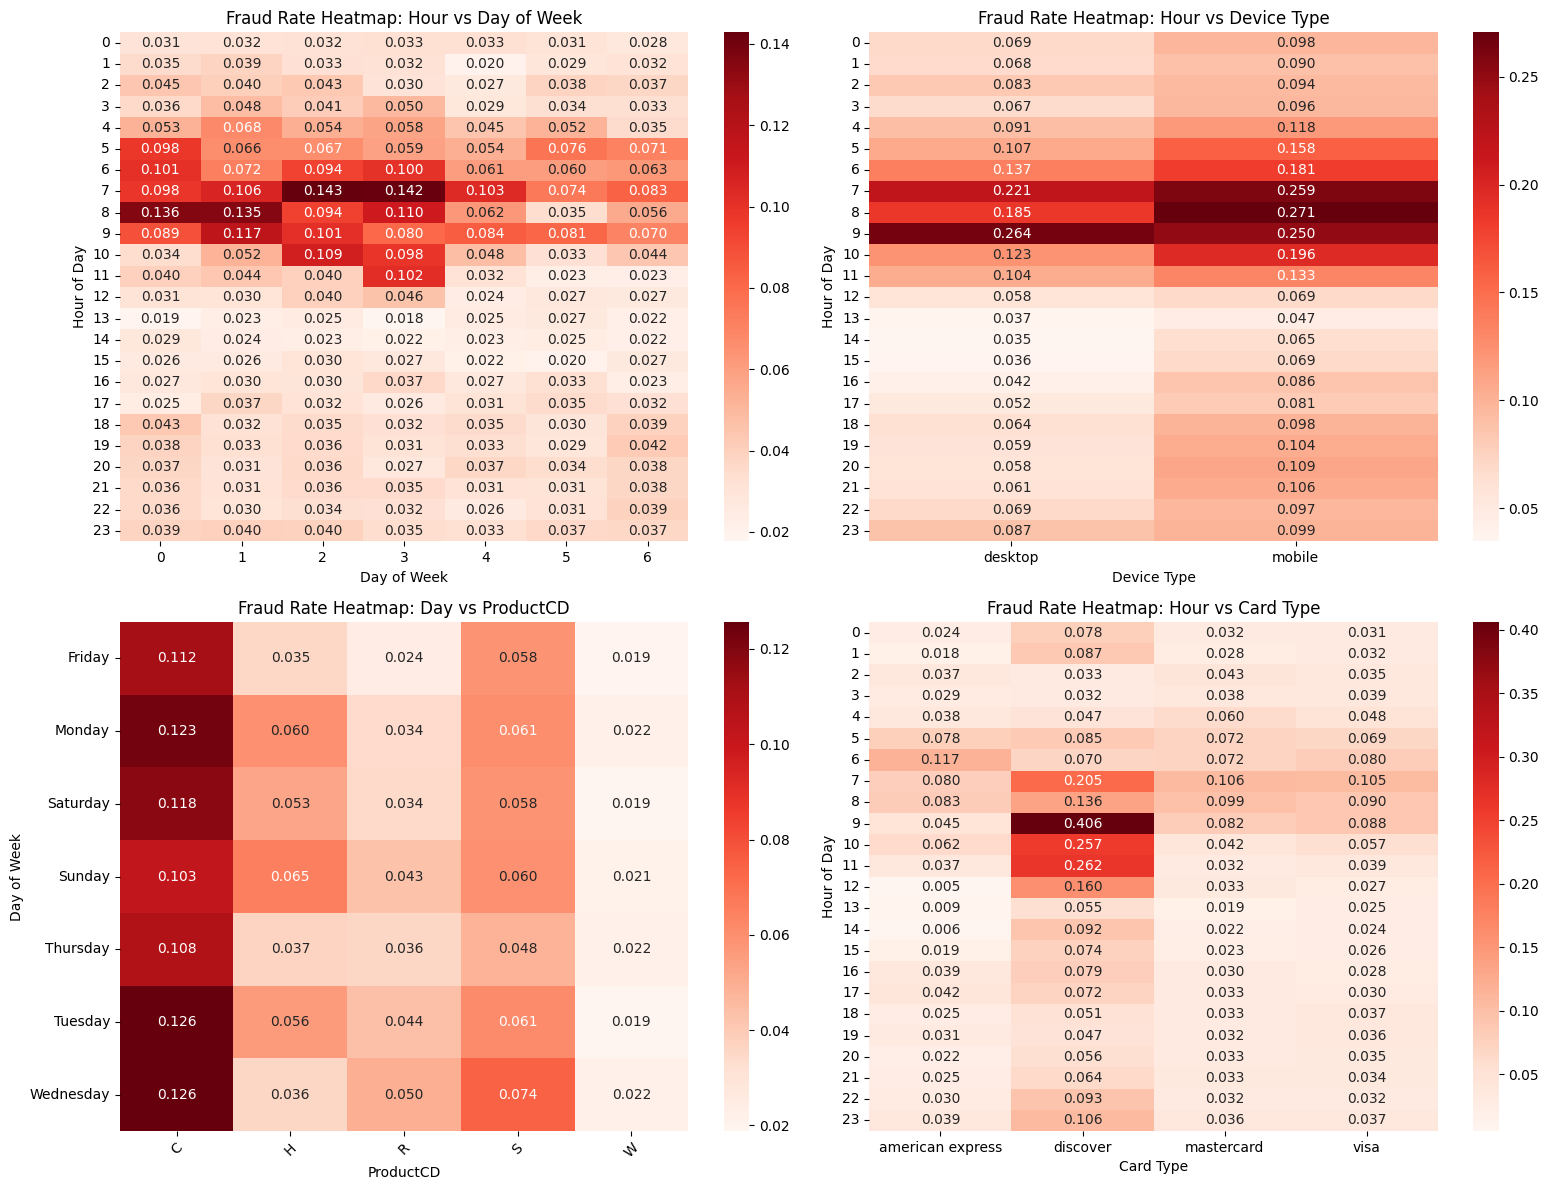


Peak Fraud Patterns:
Top 5 Hour-Day combinations with highest fraud rates:
                       Count  Fraud_Rate
hour_of_day day_name                    
7           Wednesday    490       0.143
            Thursday     465       0.142
8           Monday       413       0.136
            Tuesday      473       0.135
9           Tuesday      453       0.117


In [18]:
# 2. Time-based Feature Interactions
print("\n=== TIME-BASED INTERACTIONS ===")

# Create time interaction analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Hour vs Day of Week interaction
train['day_of_week'] = (train['TransactionDay'] % 7).astype(int)
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train['day_name'] = train['day_of_week'].map(dict(enumerate(day_names)))

# Heatmap: Hour vs Day of Week fraud rates
pivot_fraud = train.groupby(['hour_of_day', 'day_of_week'])['isFraud'].mean().unstack()
sns.heatmap(pivot_fraud, annot=True, fmt='.3f', cmap='Reds', ax=axes[0,0])
axes[0,0].set_title('Fraud Rate Heatmap: Hour vs Day of Week')
axes[0,0].set_xlabel('Day of Week')
axes[0,0].set_ylabel('Hour of Day')

# Hour vs Device Type interaction
device_hour_fraud = train[train['DeviceType'].notna()].groupby(['hour_of_day', 'DeviceType'])['isFraud'].mean().unstack()
sns.heatmap(device_hour_fraud, annot=True, fmt='.3f', cmap='Reds', ax=axes[0,1])
axes[0,1].set_title('Fraud Rate Heatmap: Hour vs Device Type')
axes[0,1].set_xlabel('Device Type')
axes[0,1].set_ylabel('Hour of Day')

# Day of Week vs ProductCD interaction
day_product_fraud = train.groupby(['day_name', 'ProductCD'])['isFraud'].mean().unstack()
sns.heatmap(day_product_fraud, annot=True, fmt='.3f', cmap='Reds', ax=axes[1,0])
axes[1,0].set_title('Fraud Rate Heatmap: Day vs ProductCD')
axes[1,0].set_xlabel('ProductCD')
axes[1,0].set_ylabel('Day of Week')
axes[1,0].tick_params(axis='x', rotation=45)

# Hour vs Card Type interaction
hour_card_fraud = train.groupby(['hour_of_day', 'card4'])['isFraud'].mean().unstack()
sns.heatmap(hour_card_fraud, annot=True, fmt='.3f', cmap='Reds', ax=axes[1,1])
axes[1,1].set_title('Fraud Rate Heatmap: Hour vs Card Type')
axes[1,1].set_xlabel('Card Type')
axes[1,1].set_ylabel('Hour of Day')

plt.tight_layout()
plt.show()

# Identify peak fraud hours and days
print("\nPeak Fraud Patterns:")
print("=" * 40)
print("Top 5 Hour-Day combinations with highest fraud rates:")
hour_day_fraud = train.groupby(['hour_of_day', 'day_name'])['isFraud'].agg(['count', 'mean']).round(3)
hour_day_fraud.columns = ['Count', 'Fraud_Rate']
top_fraud_combinations = hour_day_fraud[hour_day_fraud['Count'] >= 100].sort_values('Fraud_Rate', ascending=False).head()
print(top_fraud_combinations)



=== DEVICE & IDENTITY INTERACTIONS ===


C:\Users\ppapa\AppData\Local\Temp\ipykernel_1444\4210954482.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  device_amount_fraud = train[train['DeviceType'].notna()].groupby(['DeviceType', 'amount_bin'])['isFraud'].mean().unstack()


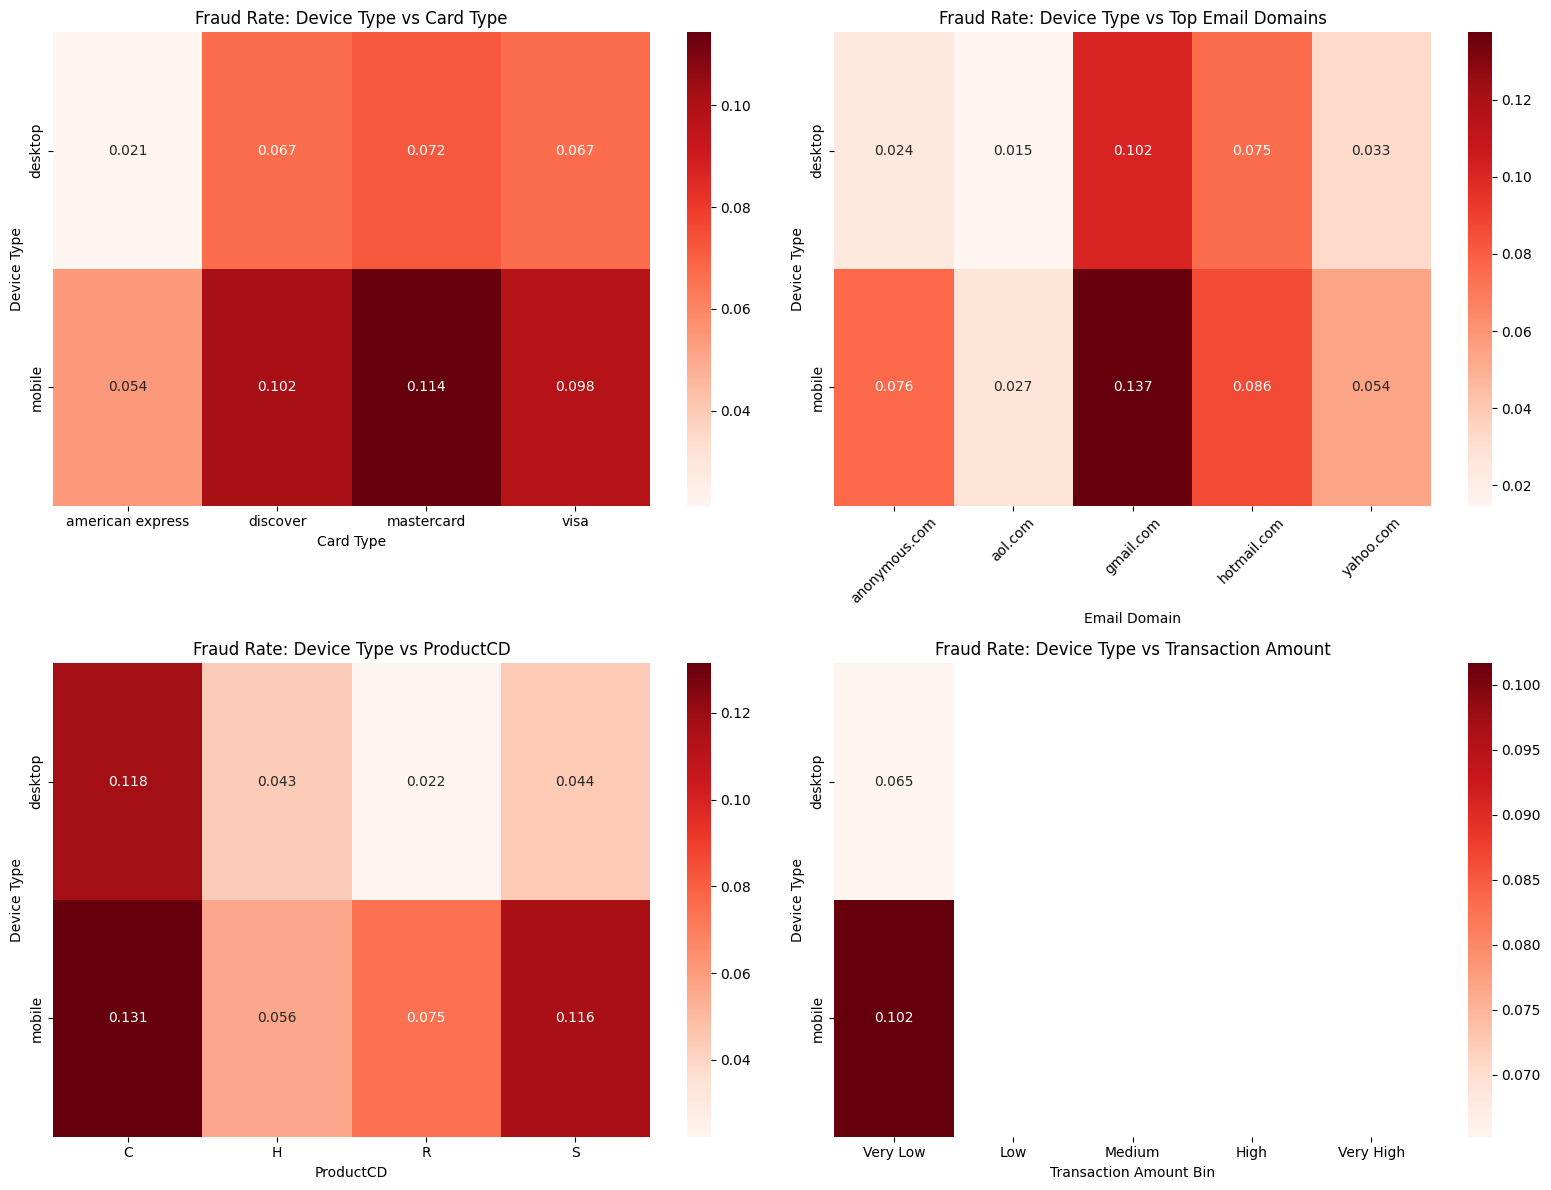


Device-Specific Fraud Patterns:
            Total_Transactions  Fraud_Rate  Avg_Amount  Avg_Hour
DeviceType                                                      
mobile                   55645       0.102      69.505    12.375
desktop                  85165       0.065      92.600    13.727


In [19]:
# 3. Device and Identity Feature Interactions
print("\n=== DEVICE & IDENTITY INTERACTIONS ===")

# Analyze device patterns with other features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Device Type vs Card Type
device_card_fraud = train[train['DeviceType'].notna()].groupby(['DeviceType', 'card4'])['isFraud'].mean().unstack()
sns.heatmap(device_card_fraud, annot=True, fmt='.3f', cmap='Reds', ax=axes[0,0])
axes[0,0].set_title('Fraud Rate: Device Type vs Card Type')
axes[0,0].set_xlabel('Card Type')
axes[0,0].set_ylabel('Device Type')

# Device Type vs Email Domain (top 5)
top_emails = train['P_emaildomain'].value_counts().head(5).index
device_email_data = train[(train['DeviceType'].notna()) & (train['P_emaildomain'].isin(top_emails))]
device_email_fraud = device_email_data.groupby(['DeviceType', 'P_emaildomain'])['isFraud'].mean().unstack()
sns.heatmap(device_email_fraud, annot=True, fmt='.3f', cmap='Reds', ax=axes[0,1])
axes[0,1].set_title('Fraud Rate: Device Type vs Top Email Domains')
axes[0,1].set_xlabel('Email Domain')
axes[0,1].set_ylabel('Device Type')
axes[0,1].tick_params(axis='x', rotation=45)

# Device Type vs ProductCD
device_product_fraud = train[train['DeviceType'].notna()].groupby(['DeviceType', 'ProductCD'])['isFraud'].mean().unstack()
sns.heatmap(device_product_fraud, annot=True, fmt='.3f', cmap='Reds', ax=axes[1,0])
axes[1,0].set_title('Fraud Rate: Device Type vs ProductCD')
axes[1,0].set_xlabel('ProductCD')
axes[1,0].set_ylabel('Device Type')

# Device Type vs Transaction Amount (binned)
train['amount_bin'] = pd.cut(train['TransactionAmt'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
device_amount_fraud = train[train['DeviceType'].notna()].groupby(['DeviceType', 'amount_bin'])['isFraud'].mean().unstack()
sns.heatmap(device_amount_fraud, annot=True, fmt='.3f', cmap='Reds', ax=axes[1,1])
axes[1,1].set_title('Fraud Rate: Device Type vs Transaction Amount')
axes[1,1].set_xlabel('Transaction Amount Bin')
axes[1,1].set_ylabel('Device Type')

plt.tight_layout()
plt.show()

# Analyze specific device patterns
print("\nDevice-Specific Fraud Patterns:")
print("=" * 50)
device_analysis = train[train['DeviceType'].notna()].groupby('DeviceType').agg({
    'isFraud': ['count', 'mean'],
    'TransactionAmt': 'mean',
    'hour_of_day': 'mean'
}).round(3)
device_analysis.columns = ['Total_Transactions', 'Fraud_Rate', 'Avg_Amount', 'Avg_Hour']
device_analysis = device_analysis.sort_values('Fraud_Rate', ascending=False)
print(device_analysis)



=== EMAIL & ADDRESS INTERACTIONS ===


C:\Users\ppapa\AppData\Local\Temp\ipykernel_1444\2615935398.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  email_addr_fraud = train[train['P_emaildomain'].notna()].groupby(['P_emaildomain', 'addr1_bin'])['isFraud'].mean().unstack()
C:\Users\ppapa\AppData\Local\Temp\ipykernel_1444\2615935398.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  email_amount_fraud = train[train['P_emaildomain'].notna()].groupby(['P_emaildomain', 'amount_bin'])['isFraud'].mean().unstack()


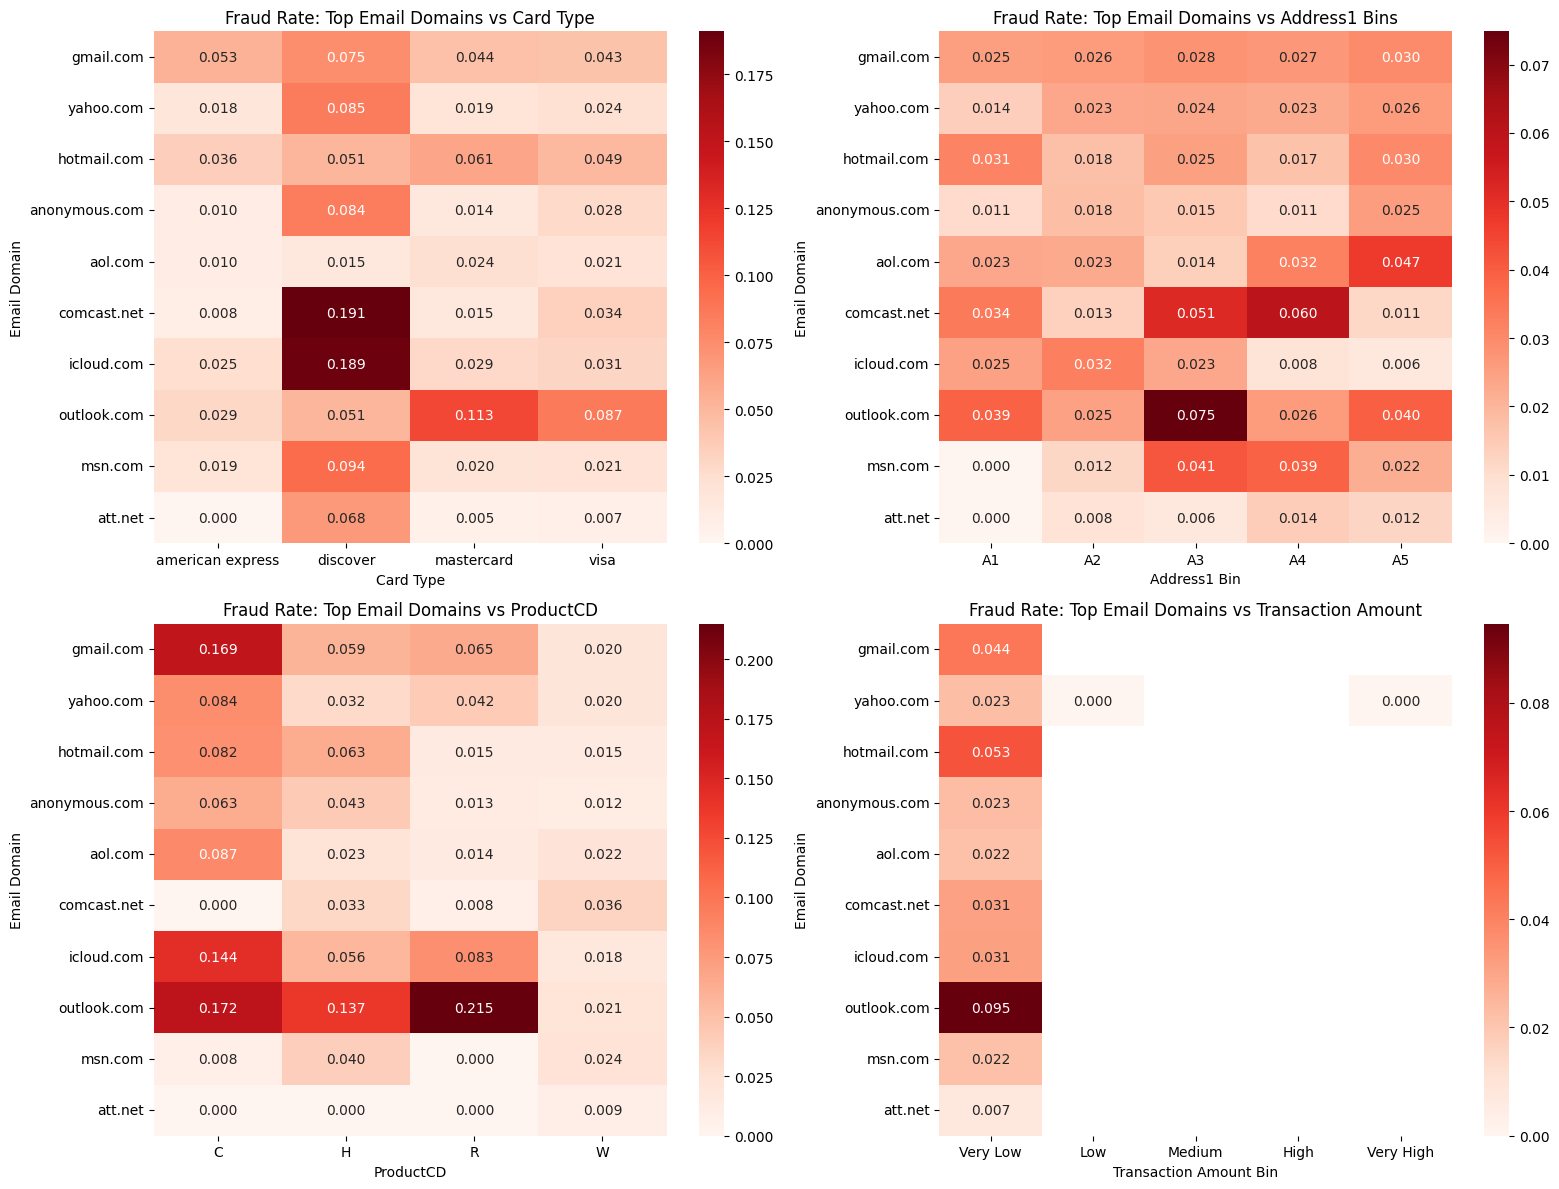


Suspicious Email Domain Patterns:
                Total_Transactions  Fraud_Rate  Avg_Amount Most_Common_Card
P_emaildomain                                                              
mail.com                       559       0.190     157.610             visa
outlook.es                     438       0.130      41.088             visa
aim.com                        315       0.127     128.741             visa
outlook.com                   5096       0.095     112.940             visa
hotmail.es                     305       0.066      43.061             visa
live.com.mx                    749       0.055      44.867             visa
hotmail.com                  45250       0.053      99.931             visa
gmail.com                   228355       0.044     128.630             visa
yahoo.fr                       143       0.035      47.433             visa
embarqmail.com                 260       0.035     126.767             visa


In [20]:
# 4. Email Domain and Address Interactions
print("\n=== EMAIL & ADDRESS INTERACTIONS ===")

# Analyze email domain patterns with other features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Email Domain vs Card Type (top combinations)
email_card_fraud = train[train['P_emaildomain'].notna()].groupby(['P_emaildomain', 'card4'])['isFraud'].mean().unstack()
# Get top 10 email domains by frequency
top_10_emails = train['P_emaildomain'].value_counts().head(10).index
email_card_top = email_card_fraud.loc[top_10_emails]
sns.heatmap(email_card_top, annot=True, fmt='.3f', cmap='Reds', ax=axes[0,0])
axes[0,0].set_title('Fraud Rate: Top Email Domains vs Card Type')
axes[0,0].set_xlabel('Card Type')
axes[0,0].set_ylabel('Email Domain')
axes[0,0].tick_params(axis='y', rotation=0)

# Email Domain vs Address1 (binned for readability)
train['addr1_bin'] = pd.cut(train['addr1'], bins=5, labels=['A1', 'A2', 'A3', 'A4', 'A5'])
email_addr_fraud = train[train['P_emaildomain'].notna()].groupby(['P_emaildomain', 'addr1_bin'])['isFraud'].mean().unstack()
email_addr_top = email_addr_fraud.loc[top_10_emails]
sns.heatmap(email_addr_top, annot=True, fmt='.3f', cmap='Reds', ax=axes[0,1])
axes[0,1].set_title('Fraud Rate: Top Email Domains vs Address1 Bins')
axes[0,1].set_xlabel('Address1 Bin')
axes[0,1].set_ylabel('Email Domain')
axes[0,1].tick_params(axis='y', rotation=0)

# Email Domain vs ProductCD
email_product_fraud = train[train['P_emaildomain'].notna()].groupby(['P_emaildomain', 'ProductCD'])['isFraud'].mean().unstack()
email_product_top = email_product_fraud.loc[top_10_emails]
sns.heatmap(email_product_top, annot=True, fmt='.3f', cmap='Reds', ax=axes[1,0])
axes[1,0].set_title('Fraud Rate: Top Email Domains vs ProductCD')
axes[1,0].set_xlabel('ProductCD')
axes[1,0].set_ylabel('Email Domain')
axes[1,0].tick_params(axis='y', rotation=0)

# Email Domain vs Transaction Amount (binned)
email_amount_fraud = train[train['P_emaildomain'].notna()].groupby(['P_emaildomain', 'amount_bin'])['isFraud'].mean().unstack()
email_amount_top = email_amount_fraud.loc[top_10_emails]
sns.heatmap(email_amount_top, annot=True, fmt='.3f', cmap='Reds', ax=axes[1,1])
axes[1,1].set_title('Fraud Rate: Top Email Domains vs Transaction Amount')
axes[1,1].set_xlabel('Transaction Amount Bin')
axes[1,1].set_ylabel('Email Domain')
axes[1,1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# Analyze suspicious email patterns
print("\nSuspicious Email Domain Patterns:")
print("=" * 50)
email_analysis = train[train['P_emaildomain'].notna()].groupby('P_emaildomain').agg({
    'isFraud': ['count', 'mean'],
    'TransactionAmt': 'mean',
    'card4': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown'
}).round(3)
email_analysis.columns = ['Total_Transactions', 'Fraud_Rate', 'Avg_Amount', 'Most_Common_Card']
email_analysis = email_analysis[email_analysis['Total_Transactions'] >= 100].sort_values('Fraud_Rate', ascending=False)
print(email_analysis.head(10))


## 11. Correlation Analysis


=== ADVANCED CORRELATION ANALYSIS ===


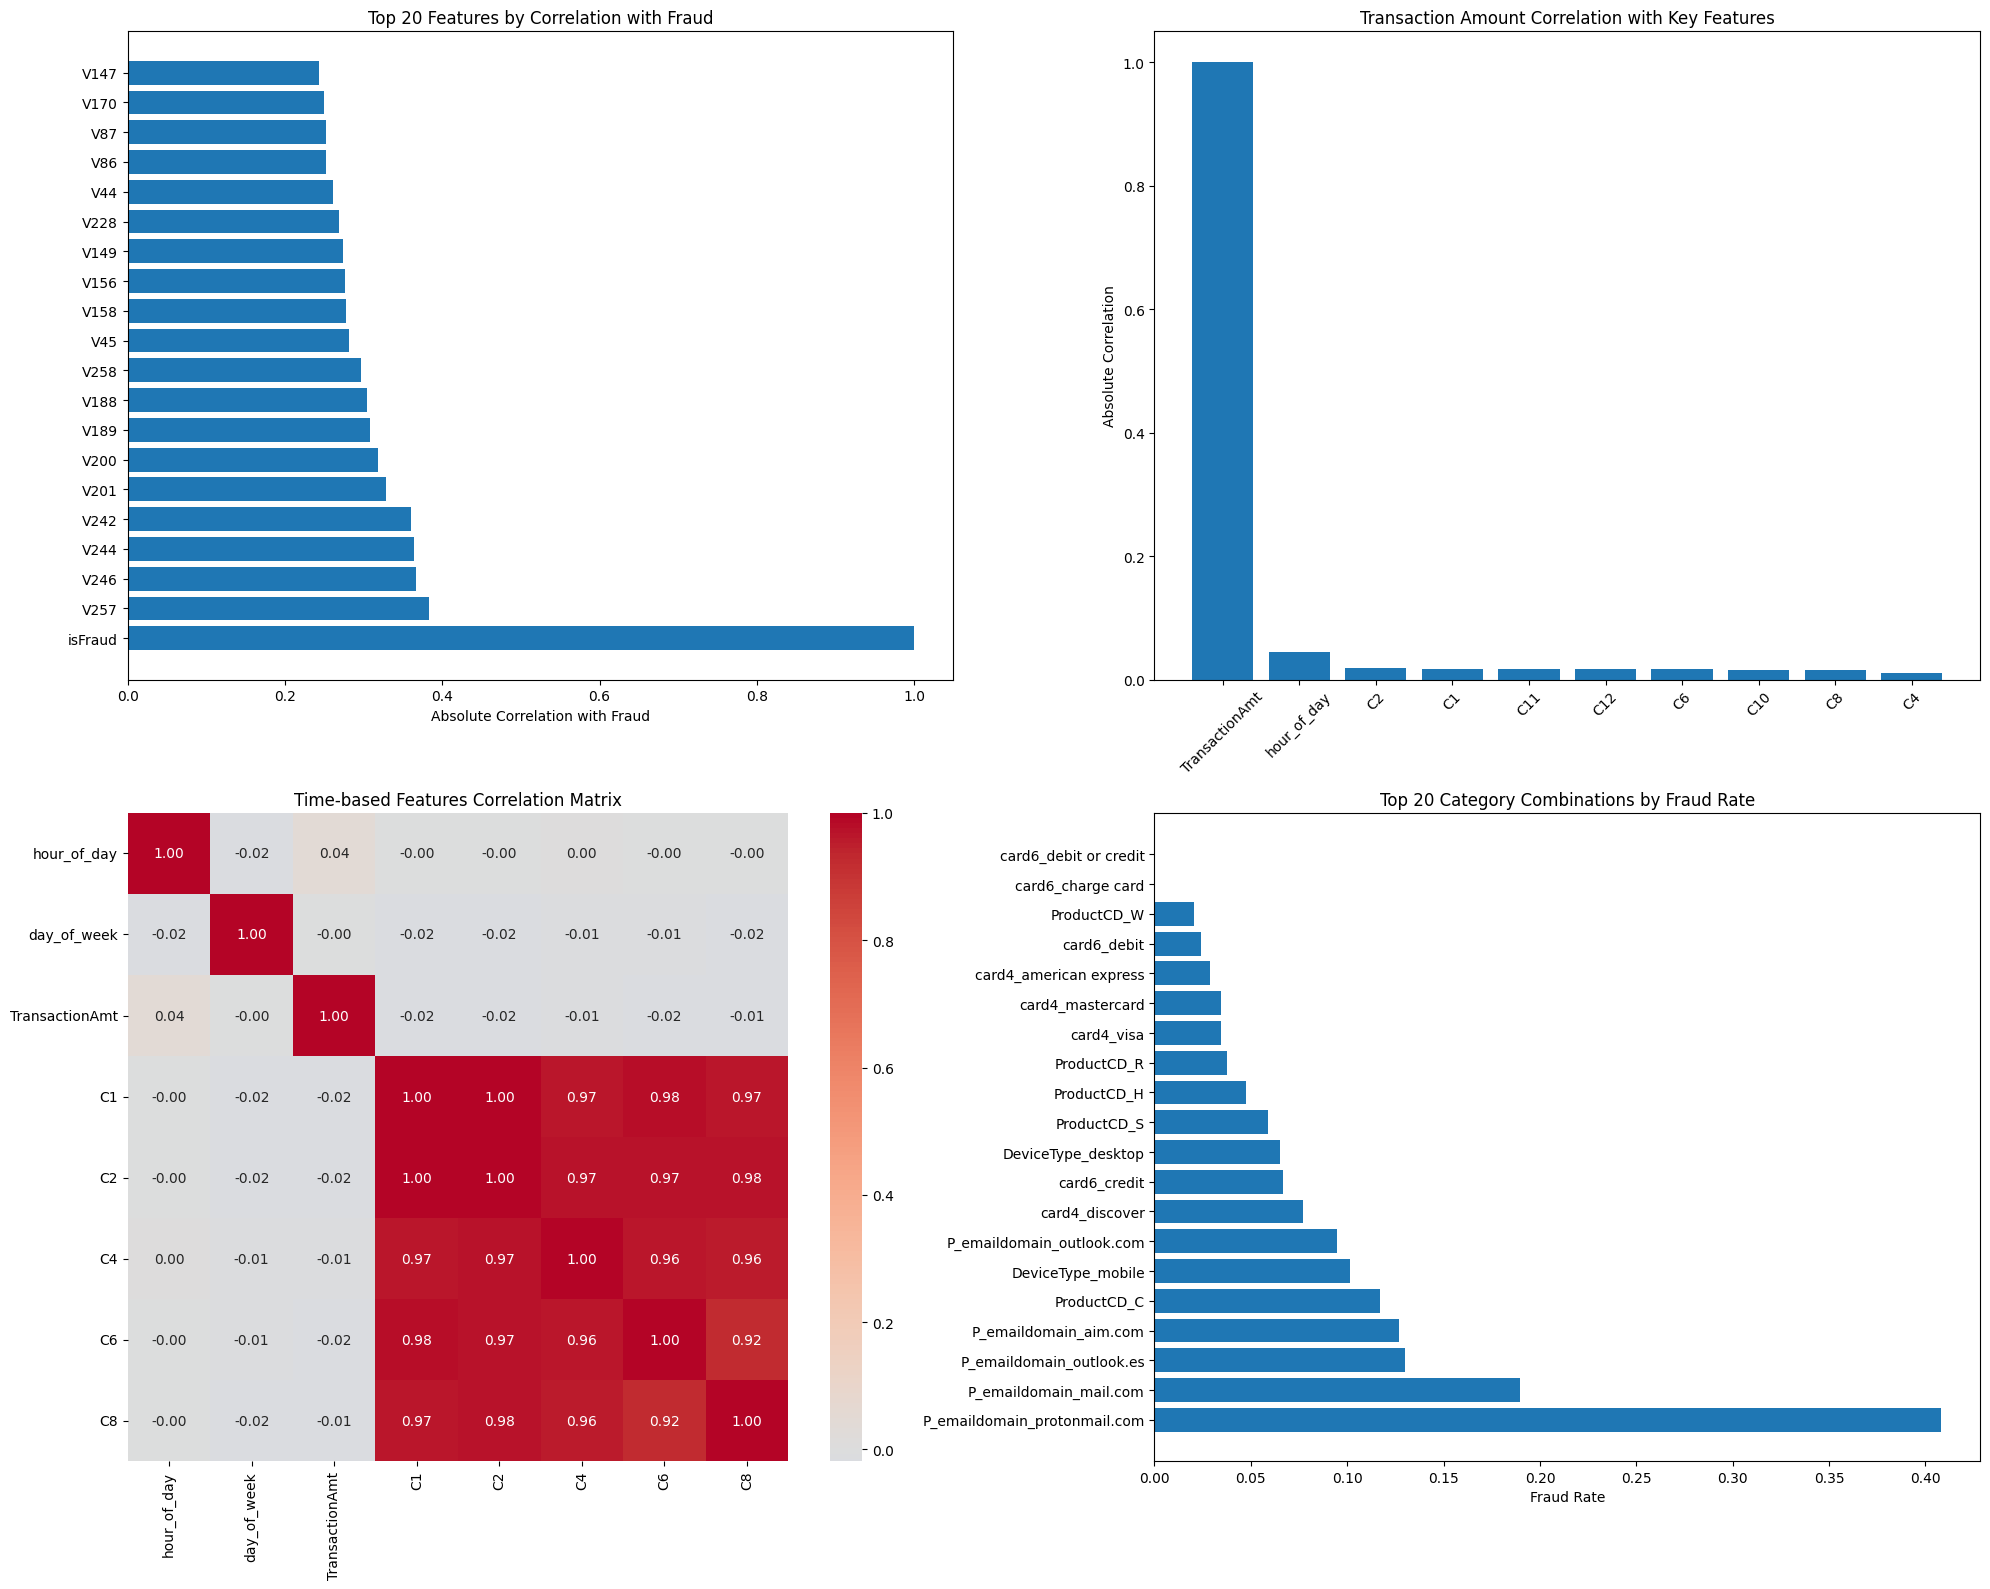


=== KEY INTERACTION FINDINGS ===
1. Most Correlated Features with Fraud:
isFraud    1.000000
V257       0.383060
V246       0.366878
V244       0.364129
V242       0.360590
V201       0.328005
V200       0.318783
V189       0.308219
V188       0.303582
V258       0.297151

2. High-Value Transaction Threshold: $275.29
3. Peak Fraud Time Patterns:
   - Highest fraud rate hours: [7, 8, 9]
   - Highest fraud rate days: ['Monday', 'Wednesday', 'Tuesday']

4. Device Type Fraud Rates:
DeviceType
mobile     0.101662
desktop    0.065215

5. Email Domain Risk Assessment:
High-risk email domains (>10% fraud rate): 4
P_emaildomain
protonmail.com    0.407895
mail.com          0.189624
outlook.es        0.130137
aim.com           0.126984


In [22]:
# 6. Advanced Correlation Analysis and Feature Importance
print("\n=== ADVANCED CORRELATION ANALYSIS ===")

# Create comprehensive correlation analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Correlation with fraud (all numeric features)
numeric_features = train.select_dtypes(include=[np.number]).columns
fraud_correlations = train[numeric_features].corr()['isFraud'].abs().sort_values(ascending=False)
top_correlations = fraud_correlations.head(20)

axes[0,0].barh(range(len(top_correlations)), top_correlations.values)
axes[0,0].set_yticks(range(len(top_correlations)))
axes[0,0].set_yticklabels(top_correlations.index)
axes[0,0].set_title('Top 20 Features by Correlation with Fraud')
axes[0,0].set_xlabel('Absolute Correlation with Fraud')

# 2. Transaction Amount vs other key features correlation
key_features = ['TransactionAmt', 'hour_of_day', 'C1', 'C2', 'C4', 'C6', 'C8', 'C10', 'C11', 'C12']
amount_correlations = train[key_features].corr()['TransactionAmt'].abs().sort_values(ascending=False)
axes[0,1].bar(range(len(amount_correlations)), amount_correlations.values)
axes[0,1].set_xticks(range(len(amount_correlations)))
axes[0,1].set_xticklabels(amount_correlations.index, rotation=45)
axes[0,1].set_title('Transaction Amount Correlation with Key Features')
axes[0,1].set_ylabel('Absolute Correlation')

# 3. Time-based correlations
time_features = ['hour_of_day', 'day_of_week', 'TransactionAmt', 'C1', 'C2', 'C4', 'C6', 'C8']
time_corr_matrix = train[time_features].corr()
sns.heatmap(time_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[1,0])
axes[1,0].set_title('Time-based Features Correlation Matrix')

# 4. Categorical feature fraud rates (top 20)
categorical_fraud_rates = []
for col in ['ProductCD', 'card4', 'card6', 'DeviceType', 'P_emaildomain']:
    if col in train.columns and train[col].notna().sum() > 1000:  # Only features with enough data
        fraud_rates = train.groupby(col)['isFraud'].mean().sort_values(ascending=False)
        for category, rate in fraud_rates.head(5).items():
            categorical_fraud_rates.append((f"{col}_{category}", rate))

categorical_fraud_rates = sorted(categorical_fraud_rates, key=lambda x: x[1], reverse=True)[:20]
categories, rates = zip(*categorical_fraud_rates)

axes[1,1].barh(range(len(categories)), rates)
axes[1,1].set_yticks(range(len(categories)))
axes[1,1].set_yticklabels(categories)
axes[1,1].set_title('Top 20 Category Combinations by Fraud Rate')
axes[1,1].set_xlabel('Fraud Rate')

plt.tight_layout()
plt.show()

# Summary of key findings
print("\n=== KEY INTERACTION FINDINGS ===")
print("=" * 50)
print("1. Most Correlated Features with Fraud:")
print(fraud_correlations.head(10).to_string())

print(f"\n2. High-Value Transaction Threshold: ${high_value_threshold:.2f}")
print("3. Peak Fraud Time Patterns:")
print("   - Highest fraud rate hours:", train.groupby('hour_of_day')['isFraud'].mean().nlargest(3).index.tolist())
print("   - Highest fraud rate days:", train.groupby('day_name')['isFraud'].mean().nlargest(3).index.tolist())

print("\n4. Device Type Fraud Rates:")
if 'DeviceType' in train.columns:
    device_fraud = train[train['DeviceType'].notna()].groupby('DeviceType')['isFraud'].mean().sort_values(ascending=False)
    print(device_fraud.to_string())

print("\n5. Email Domain Risk Assessment:")
if 'P_emaildomain' in train.columns:
    email_fraud = train[train['P_emaildomain'].notna()].groupby('P_emaildomain')['isFraud'].mean()
    high_risk_emails = email_fraud[email_fraud > 0.1].sort_values(ascending=False)
    print(f"High-risk email domains (>10% fraud rate): {len(high_risk_emails)}")
    if len(high_risk_emails) > 0:
        print(high_risk_emails.head().to_string())


## 12. Summary & Insights

# Preprocessing

In [12]:
target = train['isFraud']
train.drop('isFraud', axis=1, inplace=True)

Encoders copied from [here](https://www.kaggle.com/code/cdeotte/xgb-fraud-with-magic-0-9600#Encoding-Functions)

In [ ]:
# https://www.kaggle.com/code/cdeotte/xgb-fraud-with-magic-0-9600#Encoding-Functions
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda

# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE 
# 'Models like decision trees or random forests are insensitive to numerical order assumptions.'
# (https://www.geeksforgeeks.org/machine-learning/ml-label-encoding-of-datasets-in-python/)
def encode_LE(col,train=train,test=test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb
    x=gc.collect()
    if verbose: print(nm,', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=train,df2=test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')

# GROUP AGGREGATION MEAN AND STD
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=train, test_df=test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=train, test_df=test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

As we saw during EDA, **PCA with 13 components maintains 100% variance explained in train set**

In [ ]:
pca = PCA(n_components=13).fit(v_data_clean)
v_data_pca = pca.transform(v_data_clean)
v_pca_cols = [f'V_PCA_{i+1}' for i in range(v_data_pca.shape[1])]
v_data_pca_df = pd.DataFrame(v_data_pca, columns=v_pca_cols)
v_data_pca_df.index = v_data_clean.index

train = pd.concat([train, v_data_pca_df], axis=1)

# drop original V features
v_all = [f'V{i}' for i in range(340) if f'V{i}' in train.columns]
train.drop(v_all, axis=1, inplace=True)

# apply same PCA transformation to test set
v_data_test = test[v_features]
v_data_test_clean = v_data_test.fillna(1)
v_data_test_pca = pca.transform(v_data_test_clean)
v_data_test_pca_df = pd.DataFrame(v_data_test_pca, columns=v_pca_cols)
v_data_test_pca_df.index = v_data_test.index
test = pd.concat([test, v_data_test_pca_df], axis=1)
test.drop(v_all, axis=1, inplace=True)

In [15]:
train['uid'] = train['card1'].astype(str)+'_'+train['addr1'].astype(str)+'_'+np.floor(train['TransactionDay']-train['D1']).astype(str)
test['uid'] = test['card1'].astype(str)+'_'+test['addr1'].astype(str)+'_'+np.floor(test['TransactionDay']-test['D1']).astype(str)

In [35]:
np.array(train.select_dtypes(exclude=['object']).columns)

array(['TransactionID', 'TransactionDT', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
       'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
       'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11',
       'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6',
       'M7', 'M8', 'M9', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05',
       'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12',
       'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19',
       'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26',
       'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo', 'TransactionDay', 'day_of_week', 'hour_of_day',
       'V_PCA_1', 'V_PCA_2', 'V_PCA_3', 'V_PCA_4', 'V_PCA_5', 'V_PCA_6',
       '

In [36]:
np.array(train.select_dtypes(include=['object']).columns)

array([], dtype=object)

In [29]:
# encode_FE categorical features
# get categorical columns
cat_columns = train.select_dtypes(include=['object']).columns.tolist()
for col in cat_columns:
    encode_LE(col, train, test)

card4 , card6 , P_emaildomain , R_emaildomain , M1 , M2 , M3 , M4 , M5 , M6 , M7 , M8 , M9 , id_23 , id_30 , id_31 , id_33 , id_34 , DeviceType , DeviceInfo , uid , 

In [32]:
# normalize transaction amount
scaler = StandardScaler()
train['TransactionAmt_Scaled'] = scaler.fit_transform(train[['TransactionAmt']])
test['TransactionAmt_Scaled'] = scaler.transform(test[['TransactionAmt']])
train.drop('TransactionAmt', axis=1, inplace=True)
test.drop('TransactionAmt', axis=1, inplace=True)

We keep categorical features: `day of week` and `hour of day` that we generated in EDA, and drop the `transaction DT` column.

In [37]:
# drop transaction dt, keep day and hour features
train.drop(['TransactionDT', 'TransactionDay'], axis=1, inplace=True)
test.drop(['TransactionDT', 'TransactionDay'], axis=1, inplace=True)

In [47]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

X = train
y = target

# Simple train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Set up the model - basic configuration
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=(y == 0).sum() / (y == 1).sum()
)

# Train the model
xgb_clf.fit(X_train, y_train)

# show results on training set
y_train_pred = xgb_clf.predict_proba(X_train)[:,1]
# Get binary predictions (assuming threshold=0.5)
y_train_pred_class = (y_train_pred >= 0.5).astype(int)
# Confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred_class)
print("Confusion Matrix:")
print(cm)

# Metrics
accuracy = accuracy_score(y_train, y_train_pred_class)
precision = precision_score(y_train, y_train_pred_class)
recall = recall_score(y_train, y_train_pred_class)
f1 = f1_score(y_train, y_train_pred_class)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Evaluate ROC-AUC
auc = roc_auc_score(y_train, y_train_pred)

print(f"Validation ROC-AUC: {auc:.4f}")

# Predict on validation set
y_val_pred = xgb_clf.predict_proba(X_val)[:,1]
# Get binary predictions (assuming threshold=0.5)
y_val_pred_class = (y_val_pred >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred_class)
print("Confusion Matrix:")
print(cm)

# Metrics
accuracy = accuracy_score(y_val, y_val_pred_class)
precision = precision_score(y_val, y_val_pred_class)
recall = recall_score(y_val, y_val_pred_class)
f1 = f1_score(y_val, y_val_pred_class)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Evaluate ROC-AUC
auc = roc_auc_score(y_val, y_val_pred)

print(f"Validation ROC-AUC: {auc:.4f}")


Confusion Matrix:
[[98918 15057]
 [  833  3300]]
Accuracy: 0.8646
Precision: 0.1799
Recall: 0.8061
F1 Score: 0.2941
Validation ROC-AUC: 0.9138
Confusion Matrix:
[[98918 15057]
 [  833  3300]]
Accuracy: 0.8655
Precision: 0.1798
Recall: 0.7985
F1 Score: 0.2935
Validation ROC-AUC: 0.9077


In [48]:
# 13. Model Training with Optuna + MLflow (Scripted)
import json, os, glob, subprocess, sys
from pathlib import Path

project_root = Path('.')
venv_python = project_root / '.venv' / 'Scripts' / 'python.exe'

cmd = [
    str(venv_python), 'train_xgb.py',
    '--data-dir', 'ieee-fraud-detection-data',
    '--n-trials', '20',
    '--max-time-minutes', '20',
    '--experiment-name', 'ieee-cis-xgb',
    '--results-dir', 'artifacts'
]
print('Running training:', ' '.join(cmd))
_ = subprocess.run(cmd, check=True)

# summarize latest artifacts
artifacts_dir = Path('artifacts')
run_dirs = sorted(artifacts_dir.glob('run_*'))
assert len(run_dirs) > 0, 'No artifacts found.'
latest = run_dirs[-1]
print('Latest artifacts:', latest)

with open(latest / 'metrics_valid.json', 'r') as f:
    valid_metrics = json.load(f)
with open(latest / 'metrics_train.json', 'r') as f:
    train_metrics = json.load(f)
with open(latest / 'best_params.json', 'r') as f:
    best_params = json.load(f)

print('\nTrain metrics:', train_metrics)
print('Valid metrics:', valid_metrics)
print('\nBest params:')
for k in sorted(best_params.keys()):
    print(f'  {k}: {best_params[k]}')

print('\nTo view MLflow UI, run:')
print('  ./.venv/Scripts/Activate.ps1')
print('  mlflow ui --backend-store-uri mlruns --port 5000')


Running training: .venv\Scripts\python.exe train_xgb.py --data-dir ieee-fraud-detection-data --n-trials 20 --max-time-minutes 20 --experiment-name ieee-cis-xgb --results-dir artifacts


CalledProcessError: Command '['.venv\\Scripts\\python.exe', 'train_xgb.py', '--data-dir', 'ieee-fraud-detection-data', '--n-trials', '20', '--max-time-minutes', '20', '--experiment-name', 'ieee-cis-xgb', '--results-dir', 'artifacts']' returned non-zero exit status 1.